In [1]:
import numpy as np
from scipy import signal 
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [80]:
def function_gen(x, a, b, c, d, e, f, g):
    y1 = a*(x-e)**3 + b*(x-f)**2+c*(x-g)+d
    y2 = d*(x-g)**2 + c*x +a
    return y1, y2

In [25]:
x = np.linspace(0,1,100)

y1 = []
y2 = []
a = []
b = []
c = []
d = []

for i in range(10000):

    a_ = np.random.normal(8, 1.5, 1)
    b_ = np.random.normal(2, 2, 1)
    c_ = np.random.normal(4, 1, 1)
    d_ = np.random.normal(0, 0.5, 1)

    y1_, y2_ = function_gen(x, a_, b_, c_, d_)
    
    y1.append(y1_)
    y2.append(y2_)
    a.append(a_)
    b.append(b_)
    c.append(c_)
    d.append(d_)

In [26]:
reg1 = np.polyfit(x,y1[0],3)

In [27]:
reg1

array([1.51697556e-14, 6.54842702e+00, 2.19723174e+00, 3.27890933e+00])

In [28]:
print(a[0],b[0],c[0],d[0])

[6.54842702] [2.19723174] [3.27890933] [0.21509247]


In [29]:
plt.plot(x, np.polyval(reg1,x))
plt.plot(x, y1[0])

In [30]:
reg2 = np.polyfit(x,y2[0],4)

In [31]:
reg2

array([2.41425171e-14, 2.15092467e-01, 3.27890933e+00, 2.19723174e+00,
       6.54842702e+00])

In [32]:
print(a[0],b[0],c[0],d[0])

[6.54842702] [2.19723174] [3.27890933] [0.21509247]


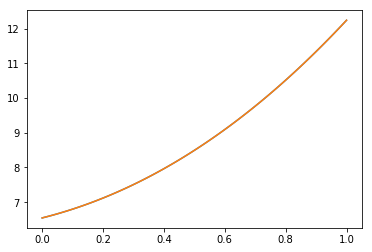

In [33]:
plt.plot(x, np.polyval(reg2,x))
plt.plot(x, y2[0])

In [34]:
fig, axs = plt.subplots(ncols=2, nrows=2)

axs[0,0].plot(np.asarray(a),'r.')
axs[1,0].plot(np.asarray(b),'g.')
axs[0,1].plot(np.asarray(c),'b.')
axs[1,1].plot(np.asarray(d),'y.')

In [35]:
series1 = np.rollaxis(np.asarray(y1),1)
series2 = np.rollaxis(np.asarray(y2),1)

In [36]:
# # defines the model
# model = Sequential()
# model.add(Bidirectional())

In [37]:
import keras as K

In [38]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense


import keras
from keras.models import Sequential, Input, Model
from keras.layers import (Dense, Conv1D, Convolution2D, GRU, LSTM, Recurrent, Bidirectional, TimeDistributed,
                          Dropout, Flatten, RepeatVector, Reshape, MaxPooling1D, UpSampling1D, BatchNormalization)
from keras.layers.core import Lambda
from keras.optimizers import Adam
from keras.regularizers import l1

In [83]:
def rnn_auto(layer, size, num_encode_layers, num_decode_layers, embedding, n_step, lr = 3e-5, drop_frac=0.,bidirectional=False, l1_norm = 1e-4,**kwargs):
    """
    Function which builds the reccurrent neural network autoencoder
    Parameters
    ----------
    layer : string; options: 'lstm','gru'
        selects the layer type
    size  : numpy, int
        sets the size of encoding and decoding layers in the network
    num_encode_layers  : numpy, int
        sets the number of encoding layers in the network
    num_decode_layers : numpy, int
        sets the number of decoding layers in the network
    embedding : numpy, int
        sets the size of the embedding layer
    n_steps : numpy, int
        length of the input time series
    lr : numpy, float
        sets the learning rate for the model
    drop_frac : numpy, float
        sets the dropout fraction
    bidirectional : numpy, bool
        selects if the model is linear or bidirectional
    l1_norm : numpy. float
        sets the lambda value of the l1 normalization. The larger the value the greater the
        sparsity. None can be passed to exclude the use or l1 normailzation.
    Returns
    -------
    model : Keras, object
        Keras tensorflow model
    """

    # defines the model
    model = Sequential()

    # selects if the model is bidirectional
    if bidirectional:
        wrapper = Bidirectional
        # builds the first layer
        model.add(Bidirectional(layer(size, return_sequences=(num_encode_layers > 1),  dropout=drop_frac),
                            input_shape=(n_step, 1)))
    else:
        wrapper = lambda x: x
        # builds the first layer
        model.add(wrapper(layer(size, return_sequences=(num_encode_layers > 1),  dropout=drop_frac,
                input_shape=(n_step, 1))))

    # builds the encoding layers
    for i in range(1, num_encode_layers):
        model.add(wrapper(layer(size, return_sequences=(i < num_encode_layers - 1), dropout=drop_frac)))

    # builds the embedding layer
    if l1_norm == None:
        # embedding layer without l1 regulariization
        model.add(Dense(embedding, activation='relu', name='encoding'))
    else:
        # embedding layer with l1 regularization
        model.add(Dense(embedding, activation='relu', name='encoding',activity_regularizer=l1(l1_norm)))

    # builds the repeat vector
    model.add(RepeatVector(n_step))

    # builds the decoding layer
    for i in range(num_decode_layers):
        model.add(wrapper(layer(size, return_sequences=True, dropout=drop_frac)))

    # builds the time distributed layer to reconstruct the original input
    model.add(TimeDistributed(Dense(1, activation='linear')))

    # complies the model
    model.compile(Adam(lr), loss='mse')

    # returns the model
    return model

def train_model(model, data_train, data_test, path, epochs, batch_size):
    """
    Function which trains the neural network
    Parameters
    ----------
    model : Keras, object
        model to train
    data_train  : numpy, float
        data to train the network
    data_test  : numpy, float
        data to test the network
    path : string
        sets the folder to save the data
    epochs : numpy, int
        train the network for this number of epochs
    batch_size : numpy, int
        sets the size of the batch. Batch size should be as large as possible. The batch
        size is limited by the GPU memory.
    """

    #builds the filename
    filepath = path + '/weights.{epoch:02d}-{val_loss:.2f}.hdf5'
    # sets the control of checkpoints
    checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True,
                                             save_weights_only=True, mode='min', period=1)

    # fits the model
    model.fit(np.atleast_3d(data1), np.atleast_3d(data2), epochs=250000,
          batch_size=1200, validation_data=(np.atleast_3d(data), np.atleast_3d(data)),
          callbacks=[tbCallBack, checkpoint])


In [22]:
auto_test = rnn_auto(LSTM, 64, 1, 1, 10, 100)

In [56]:
# fits the model
auto_test.fit(np.atleast_3d(y1), np.atleast_3d(y2), epochs=2500, batch_size=2000)

Epoch 1/2500
10000/10000 [==============================] - 4s 382us/step - loss: 2.5544
Epoch 2/2500
10000/10000 [==============================] - 4s 373us/step - loss: 2.5485
Epoch 3/2500
10000/10000 [==============================] - 4s 376us/step - loss: 2.5417
Epoch 4/2500
10000/10000 [==============================] - 4s 384us/step - loss: 2.5346
Epoch 5/2500
10000/10000 [==============================] - 4s 379us/step - loss: 2.5285
Epoch 6/2500
10000/10000 [==============================] - 4s 376us/step - loss: 2.5227
Epoch 7/2500
10000/10000 [==============================] - 4s 375us/step - loss: 2.5161
Epoch 8/2500
10000/10000 [==============================] - 4s 392us/step - loss: 2.5099
Epoch 9/2500
10000/10000 [==============================] - 4s 375us/step - loss: 2.5028
Epoch 10/2500
10000/10000 [==============================] - 4s 384us/step - loss: 2.4957
Epoch 11/2500
10000/10000 [==============================] - 4s 379us/step - loss: 2.4899
Epoch 12/2500
10000

10000/10000 [==============================] - 4s 374us/step - loss: 2.0110
Epoch 93/2500
10000/10000 [==============================] - 4s 378us/step - loss: 2.0070
Epoch 94/2500
10000/10000 [==============================] - 4s 376us/step - loss: 2.0009
Epoch 95/2500
10000/10000 [==============================] - 4s 378us/step - loss: 1.9961
Epoch 96/2500
10000/10000 [==============================] - 4s 376us/step - loss: 1.9920
Epoch 97/2500
10000/10000 [==============================] - 4s 379us/step - loss: 1.9878
Epoch 98/2500
10000/10000 [==============================] - 4s 377us/step - loss: 1.9816
Epoch 99/2500
10000/10000 [==============================] - 4s 375us/step - loss: 1.9766
Epoch 100/2500
10000/10000 [==============================] - 4s 378us/step - loss: 1.9720
Epoch 101/2500
10000/10000 [==============================] - 4s 375us/step - loss: 1.9675
Epoch 102/2500
10000/10000 [==============================] - 4s 375us/step - loss: 1.9620
Epoch 103/2500
10000/

10000/10000 [==============================] - 4s 376us/step - loss: 1.3808
Epoch 273/2500
10000/10000 [==============================] - 4s 376us/step - loss: 1.3809
Epoch 274/2500
10000/10000 [==============================] - 4s 375us/step - loss: 1.3763
Epoch 275/2500
10000/10000 [==============================] - 4s 376us/step - loss: 1.3754
Epoch 276/2500
10000/10000 [==============================] - 4s 377us/step - loss: 1.3706
Epoch 277/2500
10000/10000 [==============================] - 4s 375us/step - loss: 1.3679
Epoch 278/2500
10000/10000 [==============================] - 4s 377us/step - loss: 1.3649
Epoch 279/2500
10000/10000 [==============================] - 4s 375us/step - loss: 1.3624
Epoch 280/2500
10000/10000 [==============================] - 4s 375us/step - loss: 1.3593
Epoch 281/2500
10000/10000 [==============================] - 4s 374us/step - loss: 1.3562
Epoch 282/2500
10000/10000 [==============================] - 4s 375us/step - loss: 1.3534
Epoch 283/2500

10000/10000 [==============================] - 4s 377us/step - loss: 0.9880
Epoch 453/2500
10000/10000 [==============================] - 4s 375us/step - loss: 0.9844
Epoch 454/2500
10000/10000 [==============================] - 4s 374us/step - loss: 0.9840
Epoch 455/2500
10000/10000 [==============================] - 4s 375us/step - loss: 0.9819
Epoch 456/2500
10000/10000 [==============================] - 4s 376us/step - loss: 0.9794
Epoch 457/2500
10000/10000 [==============================] - 4s 375us/step - loss: 0.9786
Epoch 458/2500
10000/10000 [==============================] - 4s 377us/step - loss: 0.9762
Epoch 459/2500
10000/10000 [==============================] - 4s 377us/step - loss: 0.9743
Epoch 460/2500
10000/10000 [==============================] - 4s 375us/step - loss: 0.9718
Epoch 461/2500
10000/10000 [==============================] - 4s 376us/step - loss: 0.9702
Epoch 462/2500
10000/10000 [==============================] - 4s 377us/step - loss: 0.9696
Epoch 463/2500

KeyboardInterrupt: 

In [57]:
auto_test.save('auto_test')

In [58]:
y1_results = auto_test.predict(np.atleast_3d(y1))

In [59]:
y1_results

array([[[ 5.703536 ],
        [ 5.8067884],
        [ 5.8990645],
        ...,
        [10.774312 ],
        [10.458518 ],
        [10.168419 ]],

       [[ 8.12177  ],
        [ 8.245468 ],
        [ 8.355945 ],
        ...,
        [11.416098 ],
        [10.837579 ],
        [10.361101 ]],

       [[ 8.297416 ],
        [ 8.457934 ],
        [ 8.602529 ],
        ...,
        [12.0900135],
        [11.214003 ],
        [10.538136 ]],

       ...,

       [[ 8.600521 ],
        [ 8.858601 ],
        [ 9.098157 ],
        ...,
        [13.31704  ],
        [11.909701 ],
        [10.839916 ]],

       [[ 4.979612 ],
        [ 5.081118 ],
        [ 5.171499 ],
        ...,
        [10.720121 ],
        [10.425514 ],
        [10.14757  ]],

       [[ 7.2520633],
        [ 7.3573656],
        [ 7.449191 ],
        ...,
        [11.20881  ],
        [10.7185   ],
        [10.300197 ]]], dtype=float32)

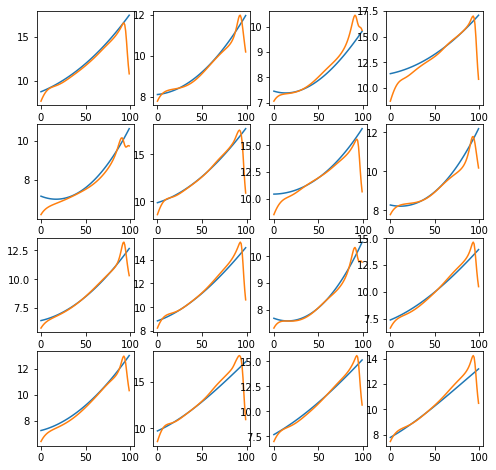

In [60]:
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
axs.reshape(-1)
for i in range (0,4):
    for j in range(0,4):
        k = np.random.randint(0, y1_results.shape[0])
        ax = axs[i,j]
        ax.plot(y2[k])
        ax.plot(y1_results[k])

In [61]:
auto_test = rnn_auto(LSTM, 64, 2, 2, 10, 100)
auto_test.fit(np.atleast_3d(y1), np.atleast_3d(y2), epochs=2500, batch_size=2000)

Epoch 1/2500
10000/10000 [==============================] - 11s 1ms/step - loss: 113.0746
Epoch 2/2500
10000/10000 [==============================] - 10s 954us/step - loss: 111.8205
Epoch 3/2500
10000/10000 [==============================] - 9s 945us/step - loss: 110.4172
Epoch 4/2500
10000/10000 [==============================] - 9s 943us/step - loss: 108.8167
Epoch 5/2500
10000/10000 [==============================] - 9s 933us/step - loss: 107.0193
Epoch 6/2500
10000/10000 [==============================] - 9s 929us/step - loss: 104.9835
Epoch 7/2500
10000/10000 [==============================] - 9s 932us/step - loss: 102.6953
Epoch 8/2500
10000/10000 [==============================] - 9s 928us/step - loss: 100.1487
Epoch 9/2500
10000/10000 [==============================] - 9s 939us/step - loss: 97.3310
Epoch 10/2500
10000/10000 [==============================] - 9s 931us/step - loss: 94.2517
Epoch 11/2500
10000/10000 [==============================] - 9s 925us/step - loss: 90.9375


10000/10000 [==============================] - 9s 916us/step - loss: 10.1000
Epoch 92/2500
10000/10000 [==============================] - 9s 920us/step - loss: 10.0689
Epoch 93/2500
10000/10000 [==============================] - 9s 924us/step - loss: 10.0375
Epoch 94/2500
10000/10000 [==============================] - 9s 915us/step - loss: 10.0058
Epoch 95/2500
10000/10000 [==============================] - 9s 911us/step - loss: 9.9736
Epoch 96/2500
10000/10000 [==============================] - 9s 914us/step - loss: 9.9407
Epoch 97/2500
10000/10000 [==============================] - 9s 913us/step - loss: 9.9064
Epoch 98/2500
10000/10000 [==============================] - 9s 924us/step - loss: 9.8705
Epoch 99/2500
10000/10000 [==============================] - 9s 922us/step - loss: 9.8322
Epoch 100/2500
10000/10000 [==============================] - 9s 940us/step - loss: 9.7914
Epoch 101/2500
10000/10000 [==============================] - 9s 943us/step - loss: 9.7491
Epoch 102/2500
100

10000/10000 [==============================] - 9s 914us/step - loss: 1.5400
Epoch 272/2500
10000/10000 [==============================] - 9s 916us/step - loss: 1.5319
Epoch 273/2500
10000/10000 [==============================] - 9s 914us/step - loss: 1.5210
Epoch 274/2500
10000/10000 [==============================] - 9s 918us/step - loss: 1.5112
Epoch 275/2500
10000/10000 [==============================] - 9s 916us/step - loss: 1.5001
Epoch 276/2500
10000/10000 [==============================] - 9s 919us/step - loss: 1.4895
Epoch 277/2500
10000/10000 [==============================] - 9s 917us/step - loss: 1.4781
Epoch 278/2500
10000/10000 [==============================] - 9s 916us/step - loss: 1.4693
Epoch 279/2500
10000/10000 [==============================] - 9s 913us/step - loss: 1.4626
Epoch 280/2500
10000/10000 [==============================] - 9s 919us/step - loss: 1.4506
Epoch 281/2500
10000/10000 [==============================] - 9s 914us/step - loss: 1.4404
Epoch 282/2500

10000/10000 [==============================] - 9s 917us/step - loss: 0.5572
Epoch 452/2500
10000/10000 [==============================] - 9s 914us/step - loss: 0.5570
Epoch 453/2500
10000/10000 [==============================] - 9s 921us/step - loss: 0.5642
Epoch 454/2500
10000/10000 [==============================] - 9s 917us/step - loss: 0.5628
Epoch 455/2500
10000/10000 [==============================] - 9s 915us/step - loss: 0.5502
Epoch 456/2500
10000/10000 [==============================] - 9s 916us/step - loss: 0.5490
Epoch 457/2500
10000/10000 [==============================] - 9s 912us/step - loss: 0.5468
Epoch 458/2500
10000/10000 [==============================] - 9s 917us/step - loss: 0.5407
Epoch 459/2500
10000/10000 [==============================] - 9s 913us/step - loss: 0.5376
Epoch 460/2500
10000/10000 [==============================] - 9s 917us/step - loss: 0.5360
Epoch 461/2500
10000/10000 [==============================] - 9s 913us/step - loss: 0.5368
Epoch 462/2500

10000/10000 [==============================] - 9s 914us/step - loss: 0.3264
Epoch 632/2500
10000/10000 [==============================] - 9s 915us/step - loss: 0.3256
Epoch 633/2500
10000/10000 [==============================] - 9s 916us/step - loss: 0.3286
Epoch 634/2500
10000/10000 [==============================] - 9s 915us/step - loss: 0.3264
Epoch 635/2500
10000/10000 [==============================] - 9s 915us/step - loss: 0.3229
Epoch 636/2500
10000/10000 [==============================] - 9s 915us/step - loss: 0.3216
Epoch 637/2500
10000/10000 [==============================] - 9s 920us/step - loss: 0.3215
Epoch 638/2500
10000/10000 [==============================] - 9s 918us/step - loss: 0.3264
Epoch 639/2500
10000/10000 [==============================] - 9s 912us/step - loss: 0.3238
Epoch 640/2500
10000/10000 [==============================] - 9s 914us/step - loss: 0.3262
Epoch 641/2500
10000/10000 [==============================] - 9s 912us/step - loss: 0.3305
Epoch 642/2500

10000/10000 [==============================] - 9s 914us/step - loss: 0.2422
Epoch 812/2500
10000/10000 [==============================] - 9s 911us/step - loss: 0.2354
Epoch 813/2500
10000/10000 [==============================] - 9s 916us/step - loss: 0.2276
Epoch 814/2500
10000/10000 [==============================] - 9s 914us/step - loss: 0.2269
Epoch 815/2500
10000/10000 [==============================] - 9s 911us/step - loss: 0.2264
Epoch 816/2500
10000/10000 [==============================] - 9s 915us/step - loss: 0.2249
Epoch 817/2500
10000/10000 [==============================] - 9s 911us/step - loss: 0.2244
Epoch 818/2500
10000/10000 [==============================] - 9s 909us/step - loss: 0.2234
Epoch 819/2500
10000/10000 [==============================] - 9s 913us/step - loss: 0.2231
Epoch 820/2500
10000/10000 [==============================] - 9s 910us/step - loss: 0.2228
Epoch 821/2500
10000/10000 [==============================] - 9s 913us/step - loss: 0.2219
Epoch 822/2500

10000/10000 [==============================] - 9s 914us/step - loss: 0.1773
Epoch 992/2500
10000/10000 [==============================] - 9s 916us/step - loss: 0.1745
Epoch 993/2500
10000/10000 [==============================] - 9s 915us/step - loss: 0.1750
Epoch 994/2500
10000/10000 [==============================] - 9s 914us/step - loss: 0.1751
Epoch 995/2500
10000/10000 [==============================] - 9s 916us/step - loss: 0.1739
Epoch 996/2500
10000/10000 [==============================] - 9s 915us/step - loss: 0.1726
Epoch 997/2500
10000/10000 [==============================] - 9s 916us/step - loss: 0.1717
Epoch 998/2500
10000/10000 [==============================] - 9s 915us/step - loss: 0.1724
Epoch 999/2500
10000/10000 [==============================] - 9s 916us/step - loss: 0.1729
Epoch 1000/2500
10000/10000 [==============================] - 9s 912us/step - loss: 0.1756
Epoch 1001/2500
10000/10000 [==============================] - 9s 914us/step - loss: 0.1774
Epoch 1002/2

10000/10000 [==============================] - 9s 915us/step - loss: 0.1462
Epoch 1170/2500
10000/10000 [==============================] - 9s 915us/step - loss: 0.1463
Epoch 1171/2500
10000/10000 [==============================] - 9s 914us/step - loss: 0.1500
Epoch 1172/2500
10000/10000 [==============================] - 9s 908us/step - loss: 0.1455
Epoch 1173/2500
10000/10000 [==============================] - 9s 915us/step - loss: 0.1434
Epoch 1174/2500
10000/10000 [==============================] - 9s 916us/step - loss: 0.1459
Epoch 1175/2500
10000/10000 [==============================] - 9s 912us/step - loss: 0.1431
Epoch 1176/2500
10000/10000 [==============================] - 9s 911us/step - loss: 0.1444
Epoch 1177/2500
10000/10000 [==============================] - 9s 914us/step - loss: 0.1409
Epoch 1178/2500
10000/10000 [==============================] - 9s 912us/step - loss: 0.1425
Epoch 1179/2500
10000/10000 [==============================] - 9s 912us/step - loss: 0.1423
Epoc

10000/10000 [==============================] - 9s 916us/step - loss: 0.1185
Epoch 1348/2500
10000/10000 [==============================] - 9s 915us/step - loss: 0.1209
Epoch 1349/2500
10000/10000 [==============================] - 9s 912us/step - loss: 0.1210
Epoch 1350/2500
10000/10000 [==============================] - 9s 914us/step - loss: 0.1189
Epoch 1351/2500
10000/10000 [==============================] - 9s 915us/step - loss: 0.1214
Epoch 1352/2500
10000/10000 [==============================] - 9s 913us/step - loss: 0.1192
Epoch 1353/2500
10000/10000 [==============================] - 9s 914us/step - loss: 0.1205
Epoch 1354/2500
10000/10000 [==============================] - 9s 916us/step - loss: 0.1196
Epoch 1355/2500
10000/10000 [==============================] - 9s 915us/step - loss: 0.1223
Epoch 1356/2500
10000/10000 [==============================] - 9s 917us/step - loss: 0.1287
Epoch 1357/2500
10000/10000 [==============================] - 9s 919us/step - loss: 0.1259
Epoc

10000/10000 [==============================] - 9s 922us/step - loss: 0.1096
Epoch 1526/2500
10000/10000 [==============================] - 9s 918us/step - loss: 0.1153
Epoch 1527/2500
10000/10000 [==============================] - 9s 922us/step - loss: 0.1316
Epoch 1528/2500
10000/10000 [==============================] - 9s 915us/step - loss: 0.1382
Epoch 1529/2500
10000/10000 [==============================] - 9s 913us/step - loss: 0.1223
Epoch 1530/2500
10000/10000 [==============================] - 9s 916us/step - loss: 0.1228
Epoch 1531/2500
10000/10000 [==============================] - 9s 918us/step - loss: 0.1149
Epoch 1532/2500
10000/10000 [==============================] - 9s 917us/step - loss: 0.1175
Epoch 1533/2500
10000/10000 [==============================] - 9s 920us/step - loss: 0.1317
Epoch 1534/2500
10000/10000 [==============================] - 9s 918us/step - loss: 0.1184
Epoch 1535/2500
10000/10000 [==============================] - 9s 919us/step - loss: 0.1154
Epoc

10000/10000 [==============================] - 9s 919us/step - loss: 0.1167
Epoch 1704/2500
10000/10000 [==============================] - 9s 921us/step - loss: 0.1069
Epoch 1705/2500
10000/10000 [==============================] - 9s 915us/step - loss: 0.0992
Epoch 1706/2500
10000/10000 [==============================] - 9s 917us/step - loss: 0.0973
Epoch 1707/2500
10000/10000 [==============================] - 9s 913us/step - loss: 0.1012
Epoch 1708/2500
10000/10000 [==============================] - 9s 917us/step - loss: 0.0998
Epoch 1709/2500
10000/10000 [==============================] - 9s 922us/step - loss: 0.1039
Epoch 1710/2500
10000/10000 [==============================] - 9s 921us/step - loss: 0.0940
Epoch 1711/2500
10000/10000 [==============================] - 9s 918us/step - loss: 0.0944
Epoch 1712/2500
10000/10000 [==============================] - 9s 913us/step - loss: 0.0960
Epoch 1713/2500
10000/10000 [==============================] - 9s 917us/step - loss: 0.0993
Epoc

10000/10000 [==============================] - 9s 918us/step - loss: 0.0887
Epoch 1882/2500
10000/10000 [==============================] - 9s 917us/step - loss: 0.0871
Epoch 1883/2500
10000/10000 [==============================] - 9s 916us/step - loss: 0.0872
Epoch 1884/2500
10000/10000 [==============================] - 9s 914us/step - loss: 0.0975
Epoch 1885/2500
10000/10000 [==============================] - 9s 917us/step - loss: 0.0853
Epoch 1886/2500
10000/10000 [==============================] - 9s 915us/step - loss: 0.0855
Epoch 1887/2500
10000/10000 [==============================] - 9s 916us/step - loss: 0.0872
Epoch 1888/2500
10000/10000 [==============================] - 9s 918us/step - loss: 0.0900
Epoch 1889/2500
10000/10000 [==============================] - 9s 912us/step - loss: 0.0868
Epoch 1890/2500
10000/10000 [==============================] - 9s 920us/step - loss: 0.0867
Epoch 1891/2500
10000/10000 [==============================] - 9s 921us/step - loss: 0.0958
Epoc

10000/10000 [==============================] - 9s 924us/step - loss: 0.0875
Epoch 2060/2500
10000/10000 [==============================] - 9s 925us/step - loss: 0.0933
Epoch 2061/2500
10000/10000 [==============================] - 9s 925us/step - loss: 0.0940
Epoch 2062/2500
10000/10000 [==============================] - 9s 924us/step - loss: 0.0972
Epoch 2063/2500
10000/10000 [==============================] - 9s 921us/step - loss: 0.1010
Epoch 2064/2500
10000/10000 [==============================] - 9s 924us/step - loss: 0.1060
Epoch 2065/2500
10000/10000 [==============================] - 9s 921us/step - loss: 0.1014
Epoch 2066/2500
10000/10000 [==============================] - 9s 918us/step - loss: 0.0949
Epoch 2067/2500
10000/10000 [==============================] - 9s 923us/step - loss: 0.0851
Epoch 2068/2500
10000/10000 [==============================] - 9s 922us/step - loss: 0.0834
Epoch 2069/2500
10000/10000 [==============================] - 9s 921us/step - loss: 0.0810
Epoc

10000/10000 [==============================] - 9s 927us/step - loss: 0.0820
Epoch 2238/2500
10000/10000 [==============================] - 9s 922us/step - loss: 0.0813
Epoch 2239/2500
10000/10000 [==============================] - 9s 921us/step - loss: 0.0830
Epoch 2240/2500
10000/10000 [==============================] - 9s 923us/step - loss: 0.0817
Epoch 2241/2500
10000/10000 [==============================] - 9s 926us/step - loss: 0.0786
Epoch 2242/2500
10000/10000 [==============================] - 9s 923us/step - loss: 0.0802
Epoch 2243/2500
10000/10000 [==============================] - 9s 925us/step - loss: 0.0750
Epoch 2244/2500
10000/10000 [==============================] - 9s 924us/step - loss: 0.0746
Epoch 2245/2500
10000/10000 [==============================] - 9s 924us/step - loss: 0.0737
Epoch 2246/2500
10000/10000 [==============================] - 9s 925us/step - loss: 0.0734
Epoch 2247/2500
10000/10000 [==============================] - 9s 927us/step - loss: 0.0737
Epoc

10000/10000 [==============================] - 9s 923us/step - loss: 0.0778
Epoch 2416/2500
10000/10000 [==============================] - 9s 927us/step - loss: 0.0758
Epoch 2417/2500
10000/10000 [==============================] - 9s 925us/step - loss: 0.0714
Epoch 2418/2500
10000/10000 [==============================] - 9s 922us/step - loss: 0.0720
Epoch 2419/2500
10000/10000 [==============================] - 9s 925us/step - loss: 0.0735
Epoch 2420/2500
10000/10000 [==============================] - 9s 923us/step - loss: 0.0705
Epoch 2421/2500
10000/10000 [==============================] - 9s 921us/step - loss: 0.0714
Epoch 2422/2500
10000/10000 [==============================] - 9s 920us/step - loss: 0.0719
Epoch 2423/2500
10000/10000 [==============================] - 9s 927us/step - loss: 0.0738
Epoch 2424/2500
10000/10000 [==============================] - 9s 924us/step - loss: 0.0740
Epoch 2425/2500
10000/10000 [==============================] - 9s 919us/step - loss: 0.0778
Epoc

In [62]:
auto_test.save('auto_test')

In [64]:
y1_results2 = auto_test.predict(np.atleast_3d(y1))

In [66]:
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
axs.reshape(-1)
for i in range (0,4):
    for j in range(0,4):
        k = np.random.randint(0, y1_results2.shape[0])
        ax = axs[i,j]
        ax.plot(y2[k])
        ax.plot(y1_results[k])

In [45]:
np.random.shuffle(y2)


In [47]:
auto_test = rnn_auto(LSTM, 64, 1, 1, 10, 100)
auto_test.fit(np.atleast_3d(y1), np.atleast_3d(y2), epochs=2500, batch_size=2000)

Epoch 1/2500
10000/10000 [==============================] - 5s 544us/step - loss: 114.6657
Epoch 2/2500
10000/10000 [==============================] - 4s 411us/step - loss: 114.3485
Epoch 3/2500
10000/10000 [==============================] - 4s 400us/step - loss: 114.0167
Epoch 4/2500
10000/10000 [==============================] - 4s 399us/step - loss: 113.6820
Epoch 5/2500
10000/10000 [==============================] - 4s 388us/step - loss: 113.3423
Epoch 6/2500
10000/10000 [==============================] - 4s 390us/step - loss: 112.9930
Epoch 7/2500
10000/10000 [==============================] - 4s 384us/step - loss: 112.6352
Epoch 8/2500
10000/10000 [==============================] - 4s 379us/step - loss: 112.2705
Epoch 9/2500
10000/10000 [==============================] - 4s 383us/step - loss: 111.8970
Epoch 10/2500
10000/10000 [==============================] - 4s 380us/step - loss: 111.4987
Epoch 11/2500
10000/10000 [==============================] - 4s 379us/step - loss: 111.06

10000/10000 [==============================] - 4s 374us/step - loss: 23.1953
Epoch 91/2500
10000/10000 [==============================] - 4s 372us/step - loss: 22.7997
Epoch 92/2500
10000/10000 [==============================] - 4s 376us/step - loss: 22.4122
Epoch 93/2500
10000/10000 [==============================] - 4s 373us/step - loss: 22.0364
Epoch 94/2500
10000/10000 [==============================] - 4s 373us/step - loss: 21.6697
Epoch 95/2500
10000/10000 [==============================] - 4s 371us/step - loss: 21.3115
Epoch 96/2500
10000/10000 [==============================] - 4s 374us/step - loss: 20.9638
Epoch 97/2500
10000/10000 [==============================] - 4s 373us/step - loss: 20.6229
Epoch 98/2500
10000/10000 [==============================] - 4s 372us/step - loss: 20.2922
Epoch 99/2500
10000/10000 [==============================] - 4s 372us/step - loss: 19.9694
Epoch 100/2500
10000/10000 [==============================] - 4s 373us/step - loss: 19.6552
Epoch 101/25

10000/10000 [==============================] - 4s 380us/step - loss: 10.4034
Epoch 180/2500
10000/10000 [==============================] - 4s 384us/step - loss: 10.3809
Epoch 181/2500
10000/10000 [==============================] - 4s 384us/step - loss: 10.3589
Epoch 182/2500
10000/10000 [==============================] - 4s 383us/step - loss: 10.3377
Epoch 183/2500
10000/10000 [==============================] - 4s 381us/step - loss: 10.3167
Epoch 184/2500
10000/10000 [==============================] - 4s 375us/step - loss: 10.2963
Epoch 185/2500
10000/10000 [==============================] - 4s 374us/step - loss: 10.2766
Epoch 186/2500
10000/10000 [==============================] - 4s 372us/step - loss: 10.2573
Epoch 187/2500
10000/10000 [==============================] - 4s 374us/step - loss: 10.2384
Epoch 188/2500
10000/10000 [==============================] - 4s 375us/step - loss: 10.2200
Epoch 189/2500
10000/10000 [==============================] - 4s 376us/step - loss: 10.2018
Epo

Epoch 269/2500
10000/10000 [==============================] - 4s 373us/step - loss: 7.8348
Epoch 270/2500
10000/10000 [==============================] - 4s 375us/step - loss: 7.8137
Epoch 271/2500
10000/10000 [==============================] - 4s 374us/step - loss: 7.7931
Epoch 272/2500
10000/10000 [==============================] - 4s 371us/step - loss: 7.7727
Epoch 273/2500
10000/10000 [==============================] - 4s 375us/step - loss: 7.7526
Epoch 274/2500
10000/10000 [==============================] - 4s 376us/step - loss: 7.7330
Epoch 275/2500
10000/10000 [==============================] - 4s 374us/step - loss: 7.7134
Epoch 276/2500
10000/10000 [==============================] - 4s 373us/step - loss: 7.6942
Epoch 277/2500
10000/10000 [==============================] - 4s 374us/step - loss: 7.6752
Epoch 278/2500
10000/10000 [==============================] - 4s 374us/step - loss: 7.6565
Epoch 279/2500
10000/10000 [==============================] - 4s 372us/step - loss: 7.6375

10000/10000 [==============================] - 4s 372us/step - loss: 6.6807
Epoch 360/2500
10000/10000 [==============================] - 4s 373us/step - loss: 6.6732
Epoch 361/2500
10000/10000 [==============================] - 4s 376us/step - loss: 6.6632
Epoch 362/2500
10000/10000 [==============================] - 4s 371us/step - loss: 6.6560
Epoch 363/2500
10000/10000 [==============================] - 4s 375us/step - loss: 6.6486
Epoch 364/2500
10000/10000 [==============================] - 4s 371us/step - loss: 6.6412
Epoch 365/2500
10000/10000 [==============================] - 4s 374us/step - loss: 6.6334
Epoch 366/2500
10000/10000 [==============================] - 4s 374us/step - loss: 6.6259
Epoch 367/2500
10000/10000 [==============================] - 4s 373us/step - loss: 6.6184
Epoch 368/2500
10000/10000 [==============================] - 4s 373us/step - loss: 6.6132
Epoch 369/2500
10000/10000 [==============================] - 4s 375us/step - loss: 6.6067
Epoch 370/2500

10000/10000 [==============================] - 4s 374us/step - loss: 6.1119
Epoch 450/2500
10000/10000 [==============================] - 4s 374us/step - loss: 6.1080
Epoch 451/2500
10000/10000 [==============================] - 4s 374us/step - loss: 6.1022
Epoch 452/2500
10000/10000 [==============================] - 4s 374us/step - loss: 6.0978
Epoch 453/2500
10000/10000 [==============================] - 4s 374us/step - loss: 6.0907
Epoch 454/2500
10000/10000 [==============================] - 4s 372us/step - loss: 6.0877
Epoch 455/2500
10000/10000 [==============================] - 4s 372us/step - loss: 6.0836
Epoch 456/2500
10000/10000 [==============================] - 4s 379us/step - loss: 6.0789
Epoch 457/2500
10000/10000 [==============================] - 4s 386us/step - loss: 6.0737
Epoch 458/2500
10000/10000 [==============================] - 4s 382us/step - loss: 6.0673
Epoch 459/2500
10000/10000 [==============================] - 4s 376us/step - loss: 6.0617
Epoch 460/2500

10000/10000 [==============================] - 4s 375us/step - loss: 5.7337
Epoch 540/2500
10000/10000 [==============================] - 4s 372us/step - loss: 5.7344
Epoch 541/2500
10000/10000 [==============================] - 4s 372us/step - loss: 5.7251
Epoch 542/2500
10000/10000 [==============================] - 4s 373us/step - loss: 5.7219
Epoch 543/2500
10000/10000 [==============================] - 4s 373us/step - loss: 5.7212
Epoch 544/2500
10000/10000 [==============================] - 4s 375us/step - loss: 5.7149
Epoch 545/2500
10000/10000 [==============================] - 4s 371us/step - loss: 5.7100
Epoch 546/2500
10000/10000 [==============================] - 4s 370us/step - loss: 5.7086
Epoch 547/2500
10000/10000 [==============================] - 4s 375us/step - loss: 5.7054
Epoch 548/2500
10000/10000 [==============================] - 4s 382us/step - loss: 5.7002
Epoch 549/2500
10000/10000 [==============================] - 4s 375us/step - loss: 5.6957
Epoch 550/2500

10000/10000 [==============================] - 4s 371us/step - loss: 5.4366
Epoch 630/2500
10000/10000 [==============================] - 4s 374us/step - loss: 5.4410
Epoch 631/2500
10000/10000 [==============================] - 4s 373us/step - loss: 5.4390
Epoch 632/2500
10000/10000 [==============================] - 4s 373us/step - loss: 5.4289
Epoch 633/2500
10000/10000 [==============================] - 4s 371us/step - loss: 5.4263
Epoch 634/2500
10000/10000 [==============================] - 4s 373us/step - loss: 5.4223
Epoch 635/2500
10000/10000 [==============================] - 4s 371us/step - loss: 5.4206
Epoch 636/2500
10000/10000 [==============================] - 4s 372us/step - loss: 5.4170
Epoch 637/2500
10000/10000 [==============================] - 4s 374us/step - loss: 5.4140
Epoch 638/2500
10000/10000 [==============================] - 4s 373us/step - loss: 5.4123
Epoch 639/2500
10000/10000 [==============================] - 4s 374us/step - loss: 5.4126
Epoch 640/2500

10000/10000 [==============================] - 4s 372us/step - loss: 5.1976
Epoch 720/2500
10000/10000 [==============================] - 4s 371us/step - loss: 5.1916
Epoch 721/2500
10000/10000 [==============================] - 4s 372us/step - loss: 5.1894
Epoch 722/2500
10000/10000 [==============================] - 4s 372us/step - loss: 5.1894
Epoch 723/2500
10000/10000 [==============================] - 4s 372us/step - loss: 5.1861
Epoch 724/2500
10000/10000 [==============================] - 4s 374us/step - loss: 5.1843
Epoch 725/2500
10000/10000 [==============================] - 4s 373us/step - loss: 5.1805
Epoch 726/2500
10000/10000 [==============================] - 4s 374us/step - loss: 5.1792
Epoch 727/2500
10000/10000 [==============================] - 4s 373us/step - loss: 5.1823
Epoch 728/2500
10000/10000 [==============================] - 4s 373us/step - loss: 5.1741
Epoch 729/2500
10000/10000 [==============================] - 4s 376us/step - loss: 5.1712
Epoch 730/2500

10000/10000 [==============================] - 4s 372us/step - loss: 5.0115
Epoch 810/2500
10000/10000 [==============================] - 4s 373us/step - loss: 5.0101
Epoch 811/2500
10000/10000 [==============================] - 4s 372us/step - loss: 5.0085
Epoch 812/2500
10000/10000 [==============================] - 4s 373us/step - loss: 5.0065
Epoch 813/2500
10000/10000 [==============================] - 4s 373us/step - loss: 5.0071
Epoch 814/2500
10000/10000 [==============================] - 4s 375us/step - loss: 5.0039
Epoch 815/2500
10000/10000 [==============================] - 4s 375us/step - loss: 5.0032
Epoch 816/2500
10000/10000 [==============================] - 4s 372us/step - loss: 5.0010
Epoch 817/2500
10000/10000 [==============================] - 4s 375us/step - loss: 4.9992
Epoch 818/2500
10000/10000 [==============================] - 4s 374us/step - loss: 4.9958
Epoch 819/2500
10000/10000 [==============================] - 4s 374us/step - loss: 4.9938
Epoch 820/2500

10000/10000 [==============================] - 4s 371us/step - loss: 4.8576
Epoch 900/2500
10000/10000 [==============================] - 4s 372us/step - loss: 4.8570
Epoch 901/2500
10000/10000 [==============================] - 4s 375us/step - loss: 4.8614
Epoch 902/2500
10000/10000 [==============================] - 4s 374us/step - loss: 4.8496
Epoch 903/2500
10000/10000 [==============================] - 4s 371us/step - loss: 4.8501
Epoch 904/2500
10000/10000 [==============================] - 4s 372us/step - loss: 4.8480
Epoch 905/2500
10000/10000 [==============================] - 4s 370us/step - loss: 4.8520
Epoch 906/2500
10000/10000 [==============================] - 4s 373us/step - loss: 4.8600
Epoch 907/2500
10000/10000 [==============================] - 4s 371us/step - loss: 4.8583
Epoch 908/2500
10000/10000 [==============================] - 4s 372us/step - loss: 4.8583
Epoch 909/2500
10000/10000 [==============================] - 4s 373us/step - loss: 4.8762
Epoch 910/2500

10000/10000 [==============================] - 4s 374us/step - loss: 4.7295
Epoch 990/2500
10000/10000 [==============================] - 4s 375us/step - loss: 4.7271
Epoch 991/2500
10000/10000 [==============================] - 4s 370us/step - loss: 4.7240
Epoch 992/2500
10000/10000 [==============================] - 4s 369us/step - loss: 4.7218
Epoch 993/2500
10000/10000 [==============================] - 4s 373us/step - loss: 4.7226
Epoch 994/2500
10000/10000 [==============================] - 4s 372us/step - loss: 4.7217
Epoch 995/2500
10000/10000 [==============================] - 4s 376us/step - loss: 4.7212
Epoch 996/2500
10000/10000 [==============================] - 4s 373us/step - loss: 4.7234
Epoch 997/2500
10000/10000 [==============================] - 4s 370us/step - loss: 4.7246
Epoch 998/2500
10000/10000 [==============================] - 4s 368us/step - loss: 4.7366
Epoch 999/2500
10000/10000 [==============================] - 4s 372us/step - loss: 4.7124
Epoch 1000/250

10000/10000 [==============================] - 4s 373us/step - loss: 4.6281
Epoch 1079/2500
10000/10000 [==============================] - 4s 373us/step - loss: 4.6202
Epoch 1080/2500
10000/10000 [==============================] - 4s 373us/step - loss: 4.6146
Epoch 1081/2500
10000/10000 [==============================] - 4s 372us/step - loss: 4.6166
Epoch 1082/2500
10000/10000 [==============================] - 4s 373us/step - loss: 4.6118
Epoch 1083/2500
10000/10000 [==============================] - 4s 372us/step - loss: 4.6115
Epoch 1084/2500
10000/10000 [==============================] - 4s 372us/step - loss: 4.6172
Epoch 1085/2500
10000/10000 [==============================] - 4s 372us/step - loss: 4.6130
Epoch 1086/2500
10000/10000 [==============================] - 4s 373us/step - loss: 4.6102
Epoch 1087/2500
10000/10000 [==============================] - 4s 372us/step - loss: 4.6075
Epoch 1088/2500
10000/10000 [==============================] - 4s 373us/step - loss: 4.6072
Epoc

10000/10000 [==============================] - 4s 375us/step - loss: 4.5179
Epoch 1168/2500
10000/10000 [==============================] - 4s 373us/step - loss: 4.5219
Epoch 1169/2500
10000/10000 [==============================] - 4s 377us/step - loss: 4.5255
Epoch 1170/2500
10000/10000 [==============================] - 4s 372us/step - loss: 4.5184
Epoch 1171/2500
10000/10000 [==============================] - 4s 373us/step - loss: 4.5143
Epoch 1172/2500
10000/10000 [==============================] - 4s 374us/step - loss: 4.5152
Epoch 1173/2500
10000/10000 [==============================] - 4s 373us/step - loss: 4.5140
Epoch 1174/2500
10000/10000 [==============================] - 4s 375us/step - loss: 4.5129
Epoch 1175/2500
10000/10000 [==============================] - 4s 373us/step - loss: 4.5098
Epoch 1176/2500
10000/10000 [==============================] - 4s 374us/step - loss: 4.5070
Epoch 1177/2500
10000/10000 [==============================] - 4s 375us/step - loss: 4.5064
Epoc

10000/10000 [==============================] - 4s 374us/step - loss: 4.4294
Epoch 1257/2500
10000/10000 [==============================] - 4s 374us/step - loss: 4.4261
Epoch 1258/2500
10000/10000 [==============================] - 4s 375us/step - loss: 4.4363
Epoch 1259/2500
10000/10000 [==============================] - 4s 371us/step - loss: 4.4367
Epoch 1260/2500
10000/10000 [==============================] - 4s 372us/step - loss: 4.4264
Epoch 1261/2500
10000/10000 [==============================] - 4s 373us/step - loss: 4.4245
Epoch 1262/2500
10000/10000 [==============================] - 4s 372us/step - loss: 4.4237
Epoch 1263/2500
10000/10000 [==============================] - 4s 373us/step - loss: 4.4260
Epoch 1264/2500
10000/10000 [==============================] - 4s 372us/step - loss: 4.4248
Epoch 1265/2500
10000/10000 [==============================] - 4s 372us/step - loss: 4.4232
Epoch 1266/2500
10000/10000 [==============================] - 4s 370us/step - loss: 4.4248
Epoc

10000/10000 [==============================] - 4s 372us/step - loss: 4.3494
Epoch 1346/2500
10000/10000 [==============================] - 4s 372us/step - loss: 4.3356
Epoch 1347/2500
10000/10000 [==============================] - 4s 370us/step - loss: 4.3336
Epoch 1348/2500
10000/10000 [==============================] - 4s 371us/step - loss: 4.3335
Epoch 1349/2500
10000/10000 [==============================] - 4s 374us/step - loss: 4.3328
Epoch 1350/2500
10000/10000 [==============================] - 4s 372us/step - loss: 4.3302
Epoch 1351/2500
10000/10000 [==============================] - 4s 374us/step - loss: 4.3256
Epoch 1352/2500
10000/10000 [==============================] - 4s 372us/step - loss: 4.3239
Epoch 1353/2500
10000/10000 [==============================] - 4s 373us/step - loss: 4.3268
Epoch 1354/2500
10000/10000 [==============================] - 4s 372us/step - loss: 4.3348
Epoch 1355/2500
10000/10000 [==============================] - 4s 373us/step - loss: 4.3293
Epoc

10000/10000 [==============================] - 4s 371us/step - loss: 4.2404
Epoch 1435/2500
10000/10000 [==============================] - 4s 373us/step - loss: 4.2404
Epoch 1436/2500
10000/10000 [==============================] - 4s 375us/step - loss: 4.2456
Epoch 1437/2500
10000/10000 [==============================] - 4s 373us/step - loss: 4.2553
Epoch 1438/2500
10000/10000 [==============================] - 4s 378us/step - loss: 4.2468
Epoch 1439/2500
10000/10000 [==============================] - 4s 373us/step - loss: 4.2361
Epoch 1440/2500
10000/10000 [==============================] - 4s 370us/step - loss: 4.2366
Epoch 1441/2500
10000/10000 [==============================] - 4s 374us/step - loss: 4.2356
Epoch 1442/2500
10000/10000 [==============================] - 4s 375us/step - loss: 4.2322
Epoch 1443/2500
10000/10000 [==============================] - 4s 371us/step - loss: 4.2369
Epoch 1444/2500
10000/10000 [==============================] - 4s 372us/step - loss: 4.2419
Epoc

10000/10000 [==============================] - 4s 372us/step - loss: 4.1623
Epoch 1524/2500
10000/10000 [==============================] - 4s 372us/step - loss: 4.1612
Epoch 1525/2500
10000/10000 [==============================] - 4s 375us/step - loss: 4.1633
Epoch 1526/2500
10000/10000 [==============================] - 4s 374us/step - loss: 4.1593
Epoch 1527/2500
10000/10000 [==============================] - 4s 374us/step - loss: 4.1601
Epoch 1528/2500
10000/10000 [==============================] - 4s 371us/step - loss: 4.1680
Epoch 1529/2500
10000/10000 [==============================] - 4s 370us/step - loss: 4.1875
Epoch 1530/2500
10000/10000 [==============================] - 4s 374us/step - loss: 4.1913
Epoch 1531/2500
10000/10000 [==============================] - 4s 371us/step - loss: 4.1871
Epoch 1532/2500
10000/10000 [==============================] - 4s 371us/step - loss: 4.1716
Epoch 1533/2500
10000/10000 [==============================] - 4s 372us/step - loss: 4.1704
Epoc

10000/10000 [==============================] - 4s 375us/step - loss: 4.0940
Epoch 1613/2500
10000/10000 [==============================] - 4s 371us/step - loss: 4.0953
Epoch 1614/2500
10000/10000 [==============================] - 4s 371us/step - loss: 4.0938
Epoch 1615/2500
10000/10000 [==============================] - 4s 372us/step - loss: 4.0963
Epoch 1616/2500
10000/10000 [==============================] - 4s 370us/step - loss: 4.0966
Epoch 1617/2500
10000/10000 [==============================] - 4s 373us/step - loss: 4.1005
Epoch 1618/2500
10000/10000 [==============================] - 4s 371us/step - loss: 4.1015
Epoch 1619/2500
10000/10000 [==============================] - 4s 373us/step - loss: 4.0926
Epoch 1620/2500
10000/10000 [==============================] - 4s 370us/step - loss: 4.1046
Epoch 1621/2500
10000/10000 [==============================] - 4s 376us/step - loss: 4.1175
Epoch 1622/2500
10000/10000 [==============================] - 4s 373us/step - loss: 4.1038
Epoc

10000/10000 [==============================] - 4s 375us/step - loss: 4.0298
Epoch 1702/2500
10000/10000 [==============================] - 4s 372us/step - loss: 4.0324
Epoch 1703/2500
10000/10000 [==============================] - 4s 372us/step - loss: 4.0313
Epoch 1704/2500
10000/10000 [==============================] - 4s 375us/step - loss: 4.0338
Epoch 1705/2500
10000/10000 [==============================] - 4s 371us/step - loss: 4.0315
Epoch 1706/2500
10000/10000 [==============================] - 4s 373us/step - loss: 4.0320
Epoch 1707/2500
10000/10000 [==============================] - 4s 371us/step - loss: 4.0300
Epoch 1708/2500
10000/10000 [==============================] - 4s 371us/step - loss: 4.0262
Epoch 1709/2500
10000/10000 [==============================] - 4s 371us/step - loss: 4.0289
Epoch 1710/2500
10000/10000 [==============================] - 4s 370us/step - loss: 4.0311
Epoch 1711/2500
10000/10000 [==============================] - 4s 372us/step - loss: 4.0272
Epoc

10000/10000 [==============================] - 4s 376us/step - loss: 3.9727
Epoch 1791/2500
10000/10000 [==============================] - 4s 372us/step - loss: 3.9704
Epoch 1792/2500
10000/10000 [==============================] - 4s 375us/step - loss: 3.9746
Epoch 1793/2500
10000/10000 [==============================] - 4s 381us/step - loss: 3.9786
Epoch 1794/2500
10000/10000 [==============================] - 4s 376us/step - loss: 3.9784
Epoch 1795/2500
10000/10000 [==============================] - 4s 375us/step - loss: 3.9764
Epoch 1796/2500
10000/10000 [==============================] - 4s 374us/step - loss: 3.9773
Epoch 1797/2500
10000/10000 [==============================] - 4s 372us/step - loss: 3.9785
Epoch 1798/2500
10000/10000 [==============================] - 4s 371us/step - loss: 3.9722
Epoch 1799/2500
10000/10000 [==============================] - 4s 371us/step - loss: 3.9651
Epoch 1800/2500
10000/10000 [==============================] - 4s 371us/step - loss: 3.9687
Epoc

10000/10000 [==============================] - 4s 372us/step - loss: 3.9239
Epoch 1880/2500
10000/10000 [==============================] - 4s 371us/step - loss: 3.9226
Epoch 1881/2500
10000/10000 [==============================] - 4s 373us/step - loss: 3.9286
Epoch 1882/2500
10000/10000 [==============================] - 4s 372us/step - loss: 3.9219
Epoch 1883/2500
10000/10000 [==============================] - 4s 373us/step - loss: 3.9229
Epoch 1884/2500
10000/10000 [==============================] - 4s 373us/step - loss: 3.9289
Epoch 1885/2500
10000/10000 [==============================] - 4s 371us/step - loss: 3.9242
Epoch 1886/2500
10000/10000 [==============================] - 4s 372us/step - loss: 3.9248
Epoch 1887/2500
10000/10000 [==============================] - 4s 373us/step - loss: 3.9200
Epoch 1888/2500
10000/10000 [==============================] - 4s 371us/step - loss: 3.9210
Epoch 1889/2500
10000/10000 [==============================] - 4s 373us/step - loss: 3.9145
Epoc

10000/10000 [==============================] - 4s 374us/step - loss: 3.8840
Epoch 1969/2500
10000/10000 [==============================] - 4s 374us/step - loss: 3.8863
Epoch 1970/2500
10000/10000 [==============================] - 4s 374us/step - loss: 3.8857
Epoch 1971/2500
10000/10000 [==============================] - 4s 372us/step - loss: 3.8849
Epoch 1972/2500
10000/10000 [==============================] - 4s 375us/step - loss: 3.8820
Epoch 1973/2500
10000/10000 [==============================] - 4s 371us/step - loss: 3.8819
Epoch 1974/2500
10000/10000 [==============================] - 4s 373us/step - loss: 3.8803
Epoch 1975/2500
10000/10000 [==============================] - 4s 373us/step - loss: 3.8834
Epoch 1976/2500
10000/10000 [==============================] - 4s 372us/step - loss: 3.8803
Epoch 1977/2500
10000/10000 [==============================] - 4s 372us/step - loss: 3.8806
Epoch 1978/2500
10000/10000 [==============================] - 4s 373us/step - loss: 3.8783
Epoc

10000/10000 [==============================] - 4s 372us/step - loss: 3.8556
Epoch 2058/2500
10000/10000 [==============================] - 4s 373us/step - loss: 3.8536
Epoch 2059/2500
10000/10000 [==============================] - 4s 374us/step - loss: 3.8641
Epoch 2060/2500
10000/10000 [==============================] - 4s 372us/step - loss: 3.8609
Epoch 2061/2500
10000/10000 [==============================] - 4s 373us/step - loss: 3.8530
Epoch 2062/2500
10000/10000 [==============================] - 4s 376us/step - loss: 3.8501
Epoch 2063/2500
10000/10000 [==============================] - 4s 372us/step - loss: 3.8494
Epoch 2064/2500
10000/10000 [==============================] - 4s 371us/step - loss: 3.8516
Epoch 2065/2500
10000/10000 [==============================] - 4s 370us/step - loss: 3.8553
Epoch 2066/2500
10000/10000 [==============================] - 4s 374us/step - loss: 3.8527
Epoch 2067/2500
10000/10000 [==============================] - 4s 372us/step - loss: 3.8514
Epoc

10000/10000 [==============================] - 4s 371us/step - loss: 3.8478
Epoch 2147/2500
10000/10000 [==============================] - 4s 372us/step - loss: 3.8500
Epoch 2148/2500
10000/10000 [==============================] - 4s 371us/step - loss: 3.8446
Epoch 2149/2500
10000/10000 [==============================] - 4s 372us/step - loss: 3.8462
Epoch 2150/2500
10000/10000 [==============================] - 4s 373us/step - loss: 3.8431
Epoch 2151/2500
10000/10000 [==============================] - 4s 372us/step - loss: 3.8432
Epoch 2152/2500
10000/10000 [==============================] - 4s 372us/step - loss: 3.8491
Epoch 2153/2500
10000/10000 [==============================] - 4s 373us/step - loss: 3.8484
Epoch 2154/2500
10000/10000 [==============================] - 4s 371us/step - loss: 3.8534
Epoch 2155/2500
10000/10000 [==============================] - 4s 373us/step - loss: 3.8554
Epoch 2156/2500
10000/10000 [==============================] - 4s 376us/step - loss: 3.8490
Epoc

10000/10000 [==============================] - 4s 374us/step - loss: 3.8514
Epoch 2236/2500
10000/10000 [==============================] - 4s 373us/step - loss: 3.8537
Epoch 2237/2500
10000/10000 [==============================] - 4s 374us/step - loss: 3.8442
Epoch 2238/2500
10000/10000 [==============================] - 4s 371us/step - loss: 3.8482
Epoch 2239/2500
10000/10000 [==============================] - 4s 371us/step - loss: 3.8574
Epoch 2240/2500
10000/10000 [==============================] - 4s 374us/step - loss: 3.8473
Epoch 2241/2500
10000/10000 [==============================] - 4s 372us/step - loss: 3.8444
Epoch 2242/2500
10000/10000 [==============================] - 4s 371us/step - loss: 3.8449
Epoch 2243/2500
10000/10000 [==============================] - 4s 372us/step - loss: 3.8558
Epoch 2244/2500
10000/10000 [==============================] - 4s 371us/step - loss: 3.8478
Epoch 2245/2500
10000/10000 [==============================] - 4s 371us/step - loss: 3.8470
Epoc

KeyboardInterrupt: 

In [48]:
auto_test.save('auto_test')

In [49]:
y1_results3 = auto_test.predict(np.atleast_3d(y1))

In [52]:
fig, axs = plt.subplots(5, 5, figsize=(8, 8))
axs.reshape(-1)
for i in range (0,5):
    for j in range(0,5):
        k = np.random.randint(0, y1_results3.shape[0])
        ax = axs[i,j]
        ax.plot(y2[k])
        ax.plot(y1_results3[k])

In [53]:
y2

[array([8.72510491, 8.69684087, 8.66933575, 8.64259007, 8.61660437,
        8.59137916, 8.56691499, 8.54321238, 8.52027185, 8.49809394,
        8.47667917, 8.45602806, 8.43614115, 8.41701897, 8.39866204,
        8.38107089, 8.36424604, 8.34818803, 8.33289739, 8.31837463,
        8.30462029, 8.2916349 , 8.27941898, 8.26797307, 8.25729768,
        8.24739335, 8.23826061, 8.22989998, 8.22231199, 8.21549717,
        8.20945604, 8.20418914, 8.19969699, 8.19598011, 8.19303905,
        8.19087432, 8.18948645, 8.18887597, 8.18904341, 8.18998929,
        8.19171415, 8.19421851, 8.1975029 , 8.20156784, 8.20641387,
        8.21204151, 8.21845129, 8.22564374, 8.23361938, 8.24237875,
        8.25192237, 8.26225076, 8.27336446, 8.285264  , 8.2979499 ,
        8.31142268, 8.32568289, 8.34073104, 8.35656766, 8.37319328,
        8.39060843, 8.40881364, 8.42780943, 8.44759633, 8.46817487,
        8.48954558, 8.51170898, 8.53466561, 8.55841598, 8.58296063,
        8.60830009, 8.63443488, 8.66136554, 8.68

In [57]:
auto_test = rnn_auto(LSTM, 64, 2, 2, 10, 100)
auto_test.fit(np.atleast_3d(y1), np.atleast_3d(y2), epochs=6000, batch_size=2000)

Epoch 1/6000
10000/10000 [==============================] - 11s 1ms/step - loss: 115.3908
Epoch 2/6000
10000/10000 [==============================] - 9s 934us/step - loss: 115.2921
Epoch 3/6000
10000/10000 [==============================] - 9s 935us/step - loss: 115.1954
Epoch 4/6000
10000/10000 [==============================] - 9s 938us/step - loss: 115.1013
Epoch 5/6000
10000/10000 [==============================] - 9s 928us/step - loss: 115.0104
Epoch 6/6000
10000/10000 [==============================] - 9s 933us/step - loss: 114.9228
Epoch 7/6000
10000/10000 [==============================] - 9s 937us/step - loss: 114.8391
Epoch 8/6000
10000/10000 [==============================] - 9s 937us/step - loss: 114.7591
Epoch 9/6000
10000/10000 [==============================] - 9s 932us/step - loss: 114.6829
Epoch 10/6000
10000/10000 [==============================] - 9s 928us/step - loss: 114.6095
Epoch 11/6000
10000/10000 [==============================] - 9s 926us/step - loss: 114.539

10000/10000 [==============================] - 9s 909us/step - loss: 100.3946
Epoch 91/6000
10000/10000 [==============================] - 9s 919us/step - loss: 99.9933
Epoch 92/6000
10000/10000 [==============================] - 9s 921us/step - loss: 99.5856
Epoch 93/6000
10000/10000 [==============================] - 9s 916us/step - loss: 99.1742
Epoch 94/6000
10000/10000 [==============================] - 9s 912us/step - loss: 98.7576
Epoch 95/6000
10000/10000 [==============================] - 9s 916us/step - loss: 98.3356
Epoch 96/6000
10000/10000 [==============================] - 9s 917us/step - loss: 97.9100
Epoch 97/6000
10000/10000 [==============================] - 9s 922us/step - loss: 97.4801
Epoch 98/6000
10000/10000 [==============================] - 9s 914us/step - loss: 97.0458
Epoch 99/6000
10000/10000 [==============================] - 9s 913us/step - loss: 96.6078
Epoch 100/6000
10000/10000 [==============================] - 9s 913us/step - loss: 96.1657
Epoch 101/6

10000/10000 [==============================] - 9s 905us/step - loss: 61.6518
Epoch 180/6000
10000/10000 [==============================] - 9s 910us/step - loss: 61.2910
Epoch 181/6000
10000/10000 [==============================] - 9s 909us/step - loss: 60.9327
Epoch 182/6000
10000/10000 [==============================] - 9s 912us/step - loss: 60.5769
Epoch 183/6000
10000/10000 [==============================] - 9s 907us/step - loss: 60.2228
Epoch 184/6000
10000/10000 [==============================] - 9s 917us/step - loss: 59.8712
Epoch 185/6000
10000/10000 [==============================] - 9s 910us/step - loss: 59.5219
Epoch 186/6000
10000/10000 [==============================] - 9s 903us/step - loss: 59.1748
Epoch 187/6000
10000/10000 [==============================] - 9s 902us/step - loss: 58.8300
Epoch 188/6000
10000/10000 [==============================] - 9s 911us/step - loss: 58.4867
Epoch 189/6000
10000/10000 [==============================] - 9s 908us/step - loss: 58.1461
Epo

10000/10000 [==============================] - 9s 908us/step - loss: 37.4254
Epoch 269/6000
10000/10000 [==============================] - 9s 905us/step - loss: 37.2370
Epoch 270/6000
10000/10000 [==============================] - 9s 908us/step - loss: 37.0512
Epoch 271/6000
10000/10000 [==============================] - 9s 908us/step - loss: 36.8665
Epoch 272/6000
10000/10000 [==============================] - 9s 906us/step - loss: 36.6835
Epoch 273/6000
10000/10000 [==============================] - 9s 907us/step - loss: 36.5015
Epoch 274/6000
10000/10000 [==============================] - 9s 901us/step - loss: 36.3213
Epoch 275/6000
10000/10000 [==============================] - 9s 909us/step - loss: 36.1429
Epoch 276/6000
10000/10000 [==============================] - 9s 903us/step - loss: 35.9657
Epoch 277/6000
10000/10000 [==============================] - 9s 903us/step - loss: 35.7900
Epoch 278/6000
10000/10000 [==============================] - 9s 908us/step - loss: 35.6156
Epo

10000/10000 [==============================] - 9s 902us/step - loss: 25.2839
Epoch 358/6000
10000/10000 [==============================] - 9s 902us/step - loss: 25.1857
Epoch 359/6000
10000/10000 [==============================] - 9s 904us/step - loss: 25.0876
Epoch 360/6000
10000/10000 [==============================] - 9s 900us/step - loss: 24.9905
Epoch 361/6000
10000/10000 [==============================] - 9s 903us/step - loss: 24.8938
Epoch 362/6000
10000/10000 [==============================] - 9s 904us/step - loss: 24.7979
Epoch 363/6000
10000/10000 [==============================] - 9s 902us/step - loss: 24.7020
Epoch 364/6000
10000/10000 [==============================] - 9s 902us/step - loss: 24.6072
Epoch 365/6000
10000/10000 [==============================] - 9s 900us/step - loss: 24.5129
Epoch 366/6000
10000/10000 [==============================] - 9s 906us/step - loss: 24.4191
Epoch 367/6000
10000/10000 [==============================] - 9s 906us/step - loss: 24.3262
Epo

10000/10000 [==============================] - 9s 904us/step - loss: 18.4210
Epoch 447/6000
10000/10000 [==============================] - 9s 905us/step - loss: 18.3616
Epoch 448/6000
10000/10000 [==============================] - 9s 907us/step - loss: 18.3024
Epoch 449/6000
10000/10000 [==============================] - 9s 905us/step - loss: 18.2434
Epoch 450/6000
10000/10000 [==============================] - 9s 905us/step - loss: 18.1852
Epoch 451/6000
10000/10000 [==============================] - 9s 904us/step - loss: 18.1270
Epoch 452/6000
10000/10000 [==============================] - 9s 904us/step - loss: 18.0693
Epoch 453/6000
10000/10000 [==============================] - 9s 903us/step - loss: 18.0116
Epoch 454/6000
10000/10000 [==============================] - 9s 901us/step - loss: 17.9543
Epoch 455/6000
10000/10000 [==============================] - 9s 904us/step - loss: 17.8975
Epoch 456/6000
10000/10000 [==============================] - 9s 897us/step - loss: 17.8411
Epo

10000/10000 [==============================] - 9s 901us/step - loss: 14.2301
Epoch 536/6000
10000/10000 [==============================] - 9s 903us/step - loss: 14.1941
Epoch 537/6000
10000/10000 [==============================] - 9s 903us/step - loss: 14.1581
Epoch 538/6000
10000/10000 [==============================] - 9s 902us/step - loss: 14.1225
Epoch 539/6000
10000/10000 [==============================] - 9s 901us/step - loss: 14.0870
Epoch 540/6000
10000/10000 [==============================] - 9s 902us/step - loss: 14.0519
Epoch 541/6000
10000/10000 [==============================] - 9s 905us/step - loss: 14.0169
Epoch 542/6000
10000/10000 [==============================] - 9s 902us/step - loss: 13.9819
Epoch 543/6000
10000/10000 [==============================] - 9s 902us/step - loss: 13.9472
Epoch 544/6000
10000/10000 [==============================] - 9s 903us/step - loss: 13.9129
Epoch 545/6000
10000/10000 [==============================] - 9s 900us/step - loss: 13.8788
Epo

10000/10000 [==============================] - 9s 907us/step - loss: 11.7422
Epoch 625/6000
10000/10000 [==============================] - 9s 907us/step - loss: 11.7215
Epoch 626/6000
10000/10000 [==============================] - 9s 906us/step - loss: 11.7008
Epoch 627/6000
10000/10000 [==============================] - 9s 906us/step - loss: 11.6803
Epoch 628/6000
10000/10000 [==============================] - 9s 904us/step - loss: 11.6598
Epoch 629/6000
10000/10000 [==============================] - 9s 908us/step - loss: 11.6395
Epoch 630/6000
10000/10000 [==============================] - 9s 904us/step - loss: 11.6193
Epoch 631/6000
10000/10000 [==============================] - 9s 907us/step - loss: 11.5993
Epoch 632/6000
10000/10000 [==============================] - 9s 907us/step - loss: 11.5793
Epoch 633/6000
10000/10000 [==============================] - 9s 908us/step - loss: 11.5596
Epoch 634/6000
10000/10000 [==============================] - 9s 910us/step - loss: 11.5399
Epo

10000/10000 [==============================] - 9s 913us/step - loss: 10.3297
Epoch 714/6000
10000/10000 [==============================] - 9s 909us/step - loss: 10.3180
Epoch 715/6000
10000/10000 [==============================] - 9s 914us/step - loss: 10.3064
Epoch 716/6000
10000/10000 [==============================] - 9s 911us/step - loss: 10.2949
Epoch 717/6000
10000/10000 [==============================] - 9s 912us/step - loss: 10.2834
Epoch 718/6000
10000/10000 [==============================] - 9s 911us/step - loss: 10.2722
Epoch 719/6000
10000/10000 [==============================] - 9s 905us/step - loss: 10.2609
Epoch 720/6000
10000/10000 [==============================] - 9s 910us/step - loss: 10.2496
Epoch 721/6000
10000/10000 [==============================] - 9s 907us/step - loss: 10.2385
Epoch 722/6000
10000/10000 [==============================] - 9s 915us/step - loss: 10.2274
Epoch 723/6000
10000/10000 [==============================] - 9s 911us/step - loss: 10.2165
Epo

10000/10000 [==============================] - 9s 910us/step - loss: 9.5410
Epoch 803/6000
10000/10000 [==============================] - 9s 908us/step - loss: 9.5346
Epoch 804/6000
10000/10000 [==============================] - 9s 908us/step - loss: 9.5281
Epoch 805/6000
10000/10000 [==============================] - 9s 908us/step - loss: 9.5218
Epoch 806/6000
10000/10000 [==============================] - 9s 905us/step - loss: 9.5154
Epoch 807/6000
10000/10000 [==============================] - 9s 904us/step - loss: 9.5091
Epoch 808/6000
10000/10000 [==============================] - 9s 909us/step - loss: 9.5029
Epoch 809/6000
10000/10000 [==============================] - 9s 907us/step - loss: 9.4968
Epoch 810/6000
10000/10000 [==============================] - 9s 905us/step - loss: 9.4905
Epoch 811/6000
10000/10000 [==============================] - 9s 907us/step - loss: 9.4844
Epoch 812/6000
10000/10000 [==============================] - 9s 912us/step - loss: 9.4783
Epoch 813/6000

10000/10000 [==============================] - 9s 909us/step - loss: 9.0889
Epoch 893/6000
10000/10000 [==============================] - 9s 903us/step - loss: 9.0849
Epoch 894/6000
10000/10000 [==============================] - 9s 903us/step - loss: 9.0809
Epoch 895/6000
10000/10000 [==============================] - 9s 904us/step - loss: 9.0770
Epoch 896/6000
10000/10000 [==============================] - 9s 905us/step - loss: 9.0731
Epoch 897/6000
10000/10000 [==============================] - 9s 906us/step - loss: 9.0692
Epoch 898/6000
10000/10000 [==============================] - 9s 907us/step - loss: 9.0653
Epoch 899/6000
10000/10000 [==============================] - 9s 906us/step - loss: 9.0614
Epoch 900/6000
10000/10000 [==============================] - 9s 906us/step - loss: 9.0576
Epoch 901/6000
10000/10000 [==============================] - 9s 907us/step - loss: 9.0537
Epoch 902/6000
10000/10000 [==============================] - 9s 905us/step - loss: 9.0498
Epoch 903/6000

10000/10000 [==============================] - 9s 903us/step - loss: 8.7885
Epoch 983/6000
10000/10000 [==============================] - 9s 903us/step - loss: 8.7854
Epoch 984/6000
10000/10000 [==============================] - 9s 905us/step - loss: 8.7824
Epoch 985/6000
10000/10000 [==============================] - 9s 905us/step - loss: 8.7793
Epoch 986/6000
10000/10000 [==============================] - 9s 906us/step - loss: 8.7762
Epoch 987/6000
10000/10000 [==============================] - 9s 904us/step - loss: 8.7731
Epoch 988/6000
10000/10000 [==============================] - 9s 899us/step - loss: 8.7701
Epoch 989/6000
10000/10000 [==============================] - 9s 903us/step - loss: 8.7670
Epoch 990/6000
10000/10000 [==============================] - 9s 901us/step - loss: 8.7639
Epoch 991/6000
10000/10000 [==============================] - 9s 901us/step - loss: 8.7608
Epoch 992/6000
10000/10000 [==============================] - 9s 902us/step - loss: 8.7576
Epoch 993/6000

10000/10000 [==============================] - 9s 910us/step - loss: 8.3611
Epoch 1072/6000
10000/10000 [==============================] - 9s 905us/step - loss: 8.3558
Epoch 1073/6000
10000/10000 [==============================] - 9s 908us/step - loss: 8.3504
Epoch 1074/6000
10000/10000 [==============================] - 9s 914us/step - loss: 8.3451
Epoch 1075/6000
10000/10000 [==============================] - 9s 909us/step - loss: 8.3397
Epoch 1076/6000
10000/10000 [==============================] - 9s 909us/step - loss: 8.3343
Epoch 1077/6000
10000/10000 [==============================] - 9s 909us/step - loss: 8.3289
Epoch 1078/6000
10000/10000 [==============================] - 9s 910us/step - loss: 8.3234
Epoch 1079/6000
10000/10000 [==============================] - 9s 909us/step - loss: 8.3179
Epoch 1080/6000
10000/10000 [==============================] - 9s 909us/step - loss: 8.3124
Epoch 1081/6000
10000/10000 [==============================] - 9s 907us/step - loss: 8.3067
Epoc

10000/10000 [==============================] - 9s 902us/step - loss: 7.6799
Epoch 1161/6000
10000/10000 [==============================] - 9s 906us/step - loss: 7.6703
Epoch 1162/6000
10000/10000 [==============================] - 9s 907us/step - loss: 7.6608
Epoch 1163/6000
10000/10000 [==============================] - 9s 902us/step - loss: 7.6516
Epoch 1164/6000
10000/10000 [==============================] - 9s 904us/step - loss: 7.6422
Epoch 1165/6000
10000/10000 [==============================] - 9s 902us/step - loss: 7.6330
Epoch 1166/6000
10000/10000 [==============================] - 9s 906us/step - loss: 7.6239
Epoch 1167/6000
10000/10000 [==============================] - 9s 906us/step - loss: 7.6149
Epoch 1168/6000
10000/10000 [==============================] - 9s 903us/step - loss: 7.6060
Epoch 1169/6000
10000/10000 [==============================] - 9s 906us/step - loss: 7.5971
Epoch 1170/6000
10000/10000 [==============================] - 9s 902us/step - loss: 7.5883
Epoc

10000/10000 [==============================] - 9s 908us/step - loss: 6.9680
Epoch 1250/6000
10000/10000 [==============================] - 9s 905us/step - loss: 6.9593
Epoch 1251/6000
10000/10000 [==============================] - 9s 906us/step - loss: 6.9506
Epoch 1252/6000
10000/10000 [==============================] - 9s 905us/step - loss: 6.9418
Epoch 1253/6000
10000/10000 [==============================] - 9s 906us/step - loss: 6.9330
Epoch 1254/6000
10000/10000 [==============================] - 9s 905us/step - loss: 6.9243
Epoch 1255/6000
10000/10000 [==============================] - 9s 901us/step - loss: 6.9153
Epoch 1256/6000
10000/10000 [==============================] - 9s 900us/step - loss: 6.9064
Epoch 1257/6000
10000/10000 [==============================] - 9s 902us/step - loss: 6.8975
Epoch 1258/6000
10000/10000 [==============================] - 9s 904us/step - loss: 6.8886
Epoch 1259/6000
10000/10000 [==============================] - 9s 903us/step - loss: 6.8796
Epoc

10000/10000 [==============================] - 9s 907us/step - loss: 6.2212
Epoch 1339/6000
10000/10000 [==============================] - 9s 904us/step - loss: 6.2151
Epoch 1340/6000
10000/10000 [==============================] - 9s 905us/step - loss: 6.2091
Epoch 1341/6000
10000/10000 [==============================] - 9s 906us/step - loss: 6.2024
Epoch 1342/6000
10000/10000 [==============================] - 9s 905us/step - loss: 6.1972
Epoch 1343/6000
10000/10000 [==============================] - 9s 907us/step - loss: 6.1904
Epoch 1344/6000
10000/10000 [==============================] - 9s 907us/step - loss: 6.1844
Epoch 1345/6000
10000/10000 [==============================] - 9s 906us/step - loss: 6.1785
Epoch 1346/6000
10000/10000 [==============================] - 9s 905us/step - loss: 6.1727
Epoch 1347/6000
10000/10000 [==============================] - 9s 903us/step - loss: 6.1668
Epoch 1348/6000
10000/10000 [==============================] - 9s 903us/step - loss: 6.1607
Epoc

10000/10000 [==============================] - 9s 908us/step - loss: 5.7651
Epoch 1428/6000
10000/10000 [==============================] - 9s 908us/step - loss: 5.7604
Epoch 1429/6000
10000/10000 [==============================] - 9s 903us/step - loss: 5.7562
Epoch 1430/6000
10000/10000 [==============================] - 9s 910us/step - loss: 5.7517
Epoch 1431/6000
10000/10000 [==============================] - 9s 910us/step - loss: 5.7474
Epoch 1432/6000
10000/10000 [==============================] - 9s 906us/step - loss: 5.7433
Epoch 1433/6000
10000/10000 [==============================] - 9s 908us/step - loss: 5.7388
Epoch 1434/6000
10000/10000 [==============================] - 9s 908us/step - loss: 5.7346
Epoch 1435/6000
10000/10000 [==============================] - 9s 906us/step - loss: 5.7302
Epoch 1436/6000
10000/10000 [==============================] - 9s 904us/step - loss: 5.7263
Epoch 1437/6000
10000/10000 [==============================] - 9s 910us/step - loss: 5.7219
Epoc

10000/10000 [==============================] - 9s 910us/step - loss: 5.4207
Epoch 1517/6000
10000/10000 [==============================] - 9s 912us/step - loss: 5.4173
Epoch 1518/6000
10000/10000 [==============================] - 9s 910us/step - loss: 5.4138
Epoch 1519/6000
10000/10000 [==============================] - 9s 909us/step - loss: 5.4104
Epoch 1520/6000
10000/10000 [==============================] - 9s 908us/step - loss: 5.4070
Epoch 1521/6000
10000/10000 [==============================] - 9s 908us/step - loss: 5.4035
Epoch 1522/6000
10000/10000 [==============================] - 9s 910us/step - loss: 5.4001
Epoch 1523/6000
10000/10000 [==============================] - 9s 911us/step - loss: 5.3967
Epoch 1524/6000
10000/10000 [==============================] - 9s 910us/step - loss: 5.3934
Epoch 1525/6000
10000/10000 [==============================] - 9s 903us/step - loss: 5.3899
Epoch 1526/6000
10000/10000 [==============================] - 9s 906us/step - loss: 5.3867
Epoc

10000/10000 [==============================] - 9s 904us/step - loss: 5.1367
Epoch 1606/6000
10000/10000 [==============================] - 9s 906us/step - loss: 5.1337
Epoch 1607/6000
10000/10000 [==============================] - 9s 904us/step - loss: 5.1306
Epoch 1608/6000
10000/10000 [==============================] - 9s 908us/step - loss: 5.1278
Epoch 1609/6000
10000/10000 [==============================] - 9s 907us/step - loss: 5.1251
Epoch 1610/6000
10000/10000 [==============================] - 9s 911us/step - loss: 5.1218
Epoch 1611/6000
10000/10000 [==============================] - 9s 907us/step - loss: 5.1190
Epoch 1612/6000
10000/10000 [==============================] - 9s 910us/step - loss: 5.1161
Epoch 1613/6000
10000/10000 [==============================] - 9s 909us/step - loss: 5.1130
Epoch 1614/6000
10000/10000 [==============================] - 9s 909us/step - loss: 5.1102
Epoch 1615/6000
10000/10000 [==============================] - 9s 905us/step - loss: 5.1074
Epoc

10000/10000 [==============================] - 9s 912us/step - loss: 4.8918
Epoch 1695/6000
10000/10000 [==============================] - 9s 911us/step - loss: 4.8891
Epoch 1696/6000
10000/10000 [==============================] - 9s 909us/step - loss: 4.8867
Epoch 1697/6000
10000/10000 [==============================] - 9s 917us/step - loss: 4.8842
Epoch 1698/6000
10000/10000 [==============================] - 9s 914us/step - loss: 4.8817
Epoch 1699/6000
10000/10000 [==============================] - 9s 909us/step - loss: 4.8797
Epoch 1700/6000
10000/10000 [==============================] - 9s 912us/step - loss: 4.8767
Epoch 1701/6000
10000/10000 [==============================] - 9s 909us/step - loss: 4.8740
Epoch 1702/6000
10000/10000 [==============================] - 9s 907us/step - loss: 4.8717
Epoch 1703/6000
10000/10000 [==============================] - 9s 909us/step - loss: 4.8690
Epoch 1704/6000
10000/10000 [==============================] - 9s 912us/step - loss: 4.8663
Epoc

10000/10000 [==============================] - 9s 910us/step - loss: 4.6775
Epoch 1784/6000
10000/10000 [==============================] - 9s 907us/step - loss: 4.6752
Epoch 1785/6000
10000/10000 [==============================] - 9s 910us/step - loss: 4.6731
Epoch 1786/6000
10000/10000 [==============================] - 9s 908us/step - loss: 4.6707
Epoch 1787/6000
10000/10000 [==============================] - 9s 909us/step - loss: 4.6685
Epoch 1788/6000
10000/10000 [==============================] - 9s 910us/step - loss: 4.6664
Epoch 1789/6000
10000/10000 [==============================] - 9s 908us/step - loss: 4.6640
Epoch 1790/6000
10000/10000 [==============================] - 9s 908us/step - loss: 4.6618
Epoch 1791/6000
10000/10000 [==============================] - 9s 906us/step - loss: 4.6596
Epoch 1792/6000
10000/10000 [==============================] - 9s 908us/step - loss: 4.6574
Epoch 1793/6000
10000/10000 [==============================] - 9s 912us/step - loss: 4.6552
Epoc

10000/10000 [==============================] - 9s 915us/step - loss: 4.4950
Epoch 1873/6000
10000/10000 [==============================] - 9s 911us/step - loss: 4.4929
Epoch 1874/6000
10000/10000 [==============================] - 9s 909us/step - loss: 4.4912
Epoch 1875/6000
10000/10000 [==============================] - 9s 909us/step - loss: 4.4895
Epoch 1876/6000
10000/10000 [==============================] - 9s 913us/step - loss: 4.4877
Epoch 1877/6000
10000/10000 [==============================] - 9s 911us/step - loss: 4.4860
Epoch 1878/6000
10000/10000 [==============================] - 9s 911us/step - loss: 4.4841
Epoch 1879/6000
10000/10000 [==============================] - 9s 911us/step - loss: 4.4822
Epoch 1880/6000
10000/10000 [==============================] - 9s 913us/step - loss: 4.4806
Epoch 1881/6000
10000/10000 [==============================] - 9s 911us/step - loss: 4.4791
Epoch 1882/6000
10000/10000 [==============================] - 9s 911us/step - loss: 4.4770
Epoc

10000/10000 [==============================] - 9s 911us/step - loss: 4.3549
Epoch 1962/6000
10000/10000 [==============================] - 9s 909us/step - loss: 4.3536
Epoch 1963/6000
10000/10000 [==============================] - 9s 910us/step - loss: 4.3522
Epoch 1964/6000
10000/10000 [==============================] - 9s 908us/step - loss: 4.3509
Epoch 1965/6000
10000/10000 [==============================] - 9s 911us/step - loss: 4.3500
Epoch 1966/6000
10000/10000 [==============================] - 9s 912us/step - loss: 4.3489
Epoch 1967/6000
10000/10000 [==============================] - 9s 908us/step - loss: 4.3471
Epoch 1968/6000
10000/10000 [==============================] - 9s 911us/step - loss: 4.3457
Epoch 1969/6000
10000/10000 [==============================] - 9s 908us/step - loss: 4.3444
Epoch 1970/6000
10000/10000 [==============================] - 9s 910us/step - loss: 4.3431
Epoch 1971/6000
10000/10000 [==============================] - 9s 912us/step - loss: 4.3419
Epoc

10000/10000 [==============================] - 9s 912us/step - loss: 4.2552
Epoch 2051/6000
10000/10000 [==============================] - 9s 910us/step - loss: 4.2545
Epoch 2052/6000
10000/10000 [==============================] - 9s 910us/step - loss: 4.2536
Epoch 2053/6000
10000/10000 [==============================] - 9s 912us/step - loss: 4.2524
Epoch 2054/6000
10000/10000 [==============================] - 9s 906us/step - loss: 4.2515
Epoch 2055/6000
10000/10000 [==============================] - 9s 907us/step - loss: 4.2506
Epoch 2056/6000
10000/10000 [==============================] - 9s 906us/step - loss: 4.2496
Epoch 2057/6000
10000/10000 [==============================] - 9s 909us/step - loss: 4.2487
Epoch 2058/6000
10000/10000 [==============================] - 9s 908us/step - loss: 4.2479
Epoch 2059/6000
10000/10000 [==============================] - 9s 911us/step - loss: 4.2469
Epoch 2060/6000
10000/10000 [==============================] - 9s 911us/step - loss: 4.2461
Epoc

10000/10000 [==============================] - 9s 909us/step - loss: 4.1835
Epoch 2140/6000
10000/10000 [==============================] - 9s 911us/step - loss: 4.1828
Epoch 2141/6000
10000/10000 [==============================] - 9s 911us/step - loss: 4.1820
Epoch 2142/6000
10000/10000 [==============================] - 9s 907us/step - loss: 4.1816
Epoch 2143/6000
10000/10000 [==============================] - 9s 913us/step - loss: 4.1807
Epoch 2144/6000
10000/10000 [==============================] - 9s 906us/step - loss: 4.1800
Epoch 2145/6000
10000/10000 [==============================] - 9s 906us/step - loss: 4.1793
Epoch 2146/6000
10000/10000 [==============================] - 9s 910us/step - loss: 4.1787
Epoch 2147/6000
10000/10000 [==============================] - 9s 907us/step - loss: 4.1781
Epoch 2148/6000
10000/10000 [==============================] - 9s 906us/step - loss: 4.1773
Epoch 2149/6000
10000/10000 [==============================] - 9s 913us/step - loss: 4.1766
Epoc

10000/10000 [==============================] - 9s 905us/step - loss: 4.1284
Epoch 2229/6000
10000/10000 [==============================] - 9s 910us/step - loss: 4.1280
Epoch 2230/6000
10000/10000 [==============================] - 9s 906us/step - loss: 4.1274
Epoch 2231/6000
10000/10000 [==============================] - 9s 903us/step - loss: 4.1267
Epoch 2232/6000
10000/10000 [==============================] - 9s 907us/step - loss: 4.1261
Epoch 2233/6000
10000/10000 [==============================] - 9s 907us/step - loss: 4.1257
Epoch 2234/6000
10000/10000 [==============================] - 9s 915us/step - loss: 4.1250
Epoch 2235/6000
10000/10000 [==============================] - 9s 915us/step - loss: 4.1246
Epoch 2236/6000
10000/10000 [==============================] - 9s 918us/step - loss: 4.1240
Epoch 2237/6000
10000/10000 [==============================] - 9s 912us/step - loss: 4.1235
Epoch 2238/6000
10000/10000 [==============================] - 9s 915us/step - loss: 4.1232
Epoc

10000/10000 [==============================] - 9s 908us/step - loss: 4.0842
Epoch 2318/6000
10000/10000 [==============================] - 9s 910us/step - loss: 4.0839
Epoch 2319/6000
10000/10000 [==============================] - 9s 913us/step - loss: 4.0834
Epoch 2320/6000
10000/10000 [==============================] - 9s 914us/step - loss: 4.0829
Epoch 2321/6000
10000/10000 [==============================] - 9s 915us/step - loss: 4.0824
Epoch 2322/6000
10000/10000 [==============================] - 9s 914us/step - loss: 4.0821
Epoch 2323/6000
10000/10000 [==============================] - 9s 913us/step - loss: 4.0816
Epoch 2324/6000
10000/10000 [==============================] - 9s 915us/step - loss: 4.0812
Epoch 2325/6000
10000/10000 [==============================] - 9s 914us/step - loss: 4.0811
Epoch 2326/6000
10000/10000 [==============================] - 9s 915us/step - loss: 4.0802
Epoch 2327/6000
10000/10000 [==============================] - 9s 915us/step - loss: 4.0799
Epoc

10000/10000 [==============================] - 9s 910us/step - loss: 4.0478
Epoch 2407/6000
10000/10000 [==============================] - 9s 907us/step - loss: 4.0475
Epoch 2408/6000
10000/10000 [==============================] - 9s 909us/step - loss: 4.0470
Epoch 2409/6000
10000/10000 [==============================] - 9s 909us/step - loss: 4.0467
Epoch 2410/6000
10000/10000 [==============================] - 9s 906us/step - loss: 4.0463
Epoch 2411/6000
10000/10000 [==============================] - 9s 909us/step - loss: 4.0459
Epoch 2412/6000
10000/10000 [==============================] - 9s 909us/step - loss: 4.0456
Epoch 2413/6000
10000/10000 [==============================] - 9s 908us/step - loss: 4.0452
Epoch 2414/6000
10000/10000 [==============================] - 9s 909us/step - loss: 4.0450
Epoch 2415/6000
10000/10000 [==============================] - 9s 909us/step - loss: 4.0444
Epoch 2416/6000
10000/10000 [==============================] - 9s 916us/step - loss: 4.0442
Epoc

10000/10000 [==============================] - 9s 908us/step - loss: 4.0170
Epoch 2496/6000
10000/10000 [==============================] - 9s 905us/step - loss: 4.0167
Epoch 2497/6000
10000/10000 [==============================] - 9s 910us/step - loss: 4.0166
Epoch 2498/6000
10000/10000 [==============================] - 9s 905us/step - loss: 4.0160
Epoch 2499/6000
10000/10000 [==============================] - 9s 902us/step - loss: 4.0157
Epoch 2500/6000
10000/10000 [==============================] - 9s 909us/step - loss: 4.0154
Epoch 2501/6000
10000/10000 [==============================] - 9s 905us/step - loss: 4.0150
Epoch 2502/6000
10000/10000 [==============================] - 9s 912us/step - loss: 4.0147
Epoch 2503/6000
10000/10000 [==============================] - 9s 914us/step - loss: 4.0145
Epoch 2504/6000
10000/10000 [==============================] - 9s 909us/step - loss: 4.0142
Epoch 2505/6000
10000/10000 [==============================] - 9s 913us/step - loss: 4.0138
Epoc

10000/10000 [==============================] - 9s 912us/step - loss: 3.9905
Epoch 2585/6000
10000/10000 [==============================] - 9s 912us/step - loss: 3.9902
Epoch 2586/6000
10000/10000 [==============================] - 9s 911us/step - loss: 3.9899
Epoch 2587/6000
10000/10000 [==============================] - 9s 911us/step - loss: 3.9896
Epoch 2588/6000
10000/10000 [==============================] - 9s 912us/step - loss: 3.9893
Epoch 2589/6000
10000/10000 [==============================] - 9s 917us/step - loss: 3.9891
Epoch 2590/6000
10000/10000 [==============================] - 9s 915us/step - loss: 3.9890
Epoch 2591/6000
10000/10000 [==============================] - 9s 908us/step - loss: 3.9885
Epoch 2592/6000
10000/10000 [==============================] - 9s 916us/step - loss: 3.9884
Epoch 2593/6000
10000/10000 [==============================] - 9s 908us/step - loss: 3.9880
Epoch 2594/6000
10000/10000 [==============================] - 9s 912us/step - loss: 3.9878
Epoc

10000/10000 [==============================] - 9s 906us/step - loss: 3.9667
Epoch 2674/6000
10000/10000 [==============================] - 9s 907us/step - loss: 3.9665
Epoch 2675/6000
10000/10000 [==============================] - 9s 906us/step - loss: 3.9663
Epoch 2676/6000
10000/10000 [==============================] - 9s 909us/step - loss: 3.9661
Epoch 2677/6000
10000/10000 [==============================] - 9s 911us/step - loss: 3.9659
Epoch 2678/6000
10000/10000 [==============================] - 9s 908us/step - loss: 3.9657
Epoch 2679/6000
10000/10000 [==============================] - 9s 908us/step - loss: 3.9655
Epoch 2680/6000
10000/10000 [==============================] - 9s 907us/step - loss: 3.9653
Epoch 2681/6000
10000/10000 [==============================] - 9s 908us/step - loss: 3.9652
Epoch 2682/6000
10000/10000 [==============================] - 9s 911us/step - loss: 3.9649
Epoch 2683/6000
10000/10000 [==============================] - 9s 909us/step - loss: 3.9647
Epoc

10000/10000 [==============================] - 9s 907us/step - loss: 3.9506
Epoch 2763/6000
10000/10000 [==============================] - 9s 909us/step - loss: 3.9505
Epoch 2764/6000
10000/10000 [==============================] - 9s 909us/step - loss: 3.9503
Epoch 2765/6000
10000/10000 [==============================] - 9s 911us/step - loss: 3.9502
Epoch 2766/6000
10000/10000 [==============================] - 9s 908us/step - loss: 3.9500
Epoch 2767/6000
10000/10000 [==============================] - 9s 909us/step - loss: 3.9498
Epoch 2768/6000
10000/10000 [==============================] - 9s 909us/step - loss: 3.9496
Epoch 2769/6000
10000/10000 [==============================] - 9s 909us/step - loss: 3.9495
Epoch 2770/6000
10000/10000 [==============================] - 9s 907us/step - loss: 3.9494
Epoch 2771/6000
10000/10000 [==============================] - 9s 911us/step - loss: 3.9492
Epoch 2772/6000
10000/10000 [==============================] - 9s 910us/step - loss: 3.9490
Epoc

10000/10000 [==============================] - 9s 913us/step - loss: 3.9370
Epoch 2852/6000
10000/10000 [==============================] - 9s 911us/step - loss: 3.9368
Epoch 2853/6000
10000/10000 [==============================] - 9s 921us/step - loss: 3.9367
Epoch 2854/6000
10000/10000 [==============================] - 9s 916us/step - loss: 3.9366
Epoch 2855/6000
10000/10000 [==============================] - 9s 916us/step - loss: 3.9363
Epoch 2856/6000
10000/10000 [==============================] - 9s 915us/step - loss: 3.9362
Epoch 2857/6000
10000/10000 [==============================] - 9s 915us/step - loss: 3.9361
Epoch 2858/6000
10000/10000 [==============================] - 9s 917us/step - loss: 3.9360
Epoch 2859/6000
10000/10000 [==============================] - 9s 916us/step - loss: 3.9361
Epoch 2860/6000
10000/10000 [==============================] - 9s 913us/step - loss: 3.9357
Epoch 2861/6000
10000/10000 [==============================] - 9s 913us/step - loss: 3.9355
Epoc

10000/10000 [==============================] - 9s 921us/step - loss: 3.9251
Epoch 2941/6000
10000/10000 [==============================] - 9s 918us/step - loss: 3.9250
Epoch 2942/6000
10000/10000 [==============================] - 9s 923us/step - loss: 3.9249
Epoch 2943/6000
10000/10000 [==============================] - 9s 915us/step - loss: 3.9248
Epoch 2944/6000
10000/10000 [==============================] - 9s 918us/step - loss: 3.9247
Epoch 2945/6000
10000/10000 [==============================] - 9s 922us/step - loss: 3.9245
Epoch 2946/6000
10000/10000 [==============================] - 9s 920us/step - loss: 3.9244
Epoch 2947/6000
10000/10000 [==============================] - 9s 922us/step - loss: 3.9242
Epoch 2948/6000
10000/10000 [==============================] - 9s 918us/step - loss: 3.9242
Epoch 2949/6000
10000/10000 [==============================] - 9s 917us/step - loss: 3.9241
Epoch 2950/6000
10000/10000 [==============================] - 9s 922us/step - loss: 3.9241
Epoc

10000/10000 [==============================] - 9s 915us/step - loss: 3.9151
Epoch 3030/6000
10000/10000 [==============================] - 9s 915us/step - loss: 3.9149
Epoch 3031/6000
10000/10000 [==============================] - 9s 914us/step - loss: 3.9148
Epoch 3032/6000
10000/10000 [==============================] - 9s 917us/step - loss: 3.9147
Epoch 3033/6000
10000/10000 [==============================] - 9s 918us/step - loss: 3.9145
Epoch 3034/6000
10000/10000 [==============================] - 9s 918us/step - loss: 3.9144
Epoch 3035/6000
10000/10000 [==============================] - 9s 921us/step - loss: 3.9144
Epoch 3036/6000
10000/10000 [==============================] - 9s 923us/step - loss: 3.9142
Epoch 3037/6000
10000/10000 [==============================] - 9s 915us/step - loss: 3.9142
Epoch 3038/6000
10000/10000 [==============================] - 9s 916us/step - loss: 3.9140
Epoch 3039/6000
10000/10000 [==============================] - 9s 916us/step - loss: 3.9139
Epoc

10000/10000 [==============================] - 9s 917us/step - loss: 3.9064
Epoch 3119/6000
10000/10000 [==============================] - 9s 914us/step - loss: 3.9063
Epoch 3120/6000
10000/10000 [==============================] - 9s 914us/step - loss: 3.9062
Epoch 3121/6000
10000/10000 [==============================] - 9s 912us/step - loss: 3.9061
Epoch 3122/6000
10000/10000 [==============================] - 9s 918us/step - loss: 3.9061
Epoch 3123/6000
10000/10000 [==============================] - 9s 917us/step - loss: 3.9060
Epoch 3124/6000
10000/10000 [==============================] - 9s 916us/step - loss: 3.9058
Epoch 3125/6000
10000/10000 [==============================] - 9s 919us/step - loss: 3.9058
Epoch 3126/6000
10000/10000 [==============================] - 9s 913us/step - loss: 3.9058
Epoch 3127/6000
10000/10000 [==============================] - 9s 916us/step - loss: 3.9057
Epoch 3128/6000
10000/10000 [==============================] - 9s 919us/step - loss: 3.9055
Epoc

10000/10000 [==============================] - 9s 916us/step - loss: 3.8992
Epoch 3208/6000
10000/10000 [==============================] - 9s 914us/step - loss: 3.8990
Epoch 3209/6000
10000/10000 [==============================] - 9s 913us/step - loss: 3.8990
Epoch 3210/6000
10000/10000 [==============================] - 9s 916us/step - loss: 3.8988
Epoch 3211/6000
10000/10000 [==============================] - 9s 920us/step - loss: 3.8987
Epoch 3212/6000
10000/10000 [==============================] - 9s 915us/step - loss: 3.8987
Epoch 3213/6000
10000/10000 [==============================] - 9s 913us/step - loss: 3.8986
Epoch 3214/6000
10000/10000 [==============================] - 9s 913us/step - loss: 3.8986
Epoch 3215/6000
10000/10000 [==============================] - 9s 916us/step - loss: 3.8989
Epoch 3216/6000
10000/10000 [==============================] - 9s 917us/step - loss: 3.8988
Epoch 3217/6000
10000/10000 [==============================] - 9s 915us/step - loss: 3.8983
Epoc

10000/10000 [==============================] - 9s 913us/step - loss: 3.8928
Epoch 3297/6000
10000/10000 [==============================] - 9s 916us/step - loss: 3.8933
Epoch 3298/6000
10000/10000 [==============================] - 9s 915us/step - loss: 3.8927
Epoch 3299/6000
10000/10000 [==============================] - 9s 916us/step - loss: 3.8926
Epoch 3300/6000
10000/10000 [==============================] - 9s 913us/step - loss: 3.8925
Epoch 3301/6000
10000/10000 [==============================] - 9s 917us/step - loss: 3.8927
Epoch 3302/6000
10000/10000 [==============================] - 9s 916us/step - loss: 3.8924
Epoch 3303/6000
10000/10000 [==============================] - 9s 913us/step - loss: 3.8924
Epoch 3304/6000
10000/10000 [==============================] - 9s 915us/step - loss: 3.8923
Epoch 3305/6000
10000/10000 [==============================] - 9s 915us/step - loss: 3.8923
Epoch 3306/6000
10000/10000 [==============================] - 9s 914us/step - loss: 3.8925
Epoc

10000/10000 [==============================] - 9s 913us/step - loss: 3.8874
Epoch 3386/6000
10000/10000 [==============================] - 9s 914us/step - loss: 3.8874
Epoch 3387/6000
10000/10000 [==============================] - 9s 914us/step - loss: 3.8873
Epoch 3388/6000
10000/10000 [==============================] - 9s 914us/step - loss: 3.8872
Epoch 3389/6000
10000/10000 [==============================] - 9s 914us/step - loss: 3.8872
Epoch 3390/6000
10000/10000 [==============================] - 9s 916us/step - loss: 3.8872
Epoch 3391/6000
10000/10000 [==============================] - 9s 913us/step - loss: 3.8871
Epoch 3392/6000
10000/10000 [==============================] - 9s 912us/step - loss: 3.8872
Epoch 3393/6000
10000/10000 [==============================] - 9s 917us/step - loss: 3.8871
Epoch 3394/6000
10000/10000 [==============================] - 9s 912us/step - loss: 3.8871
Epoch 3395/6000
10000/10000 [==============================] - 9s 914us/step - loss: 3.8869
Epoc

10000/10000 [==============================] - 9s 915us/step - loss: 3.8826
Epoch 3475/6000
10000/10000 [==============================] - 9s 914us/step - loss: 3.8827
Epoch 3476/6000
10000/10000 [==============================] - 9s 913us/step - loss: 3.8827
Epoch 3477/6000
10000/10000 [==============================] - 9s 916us/step - loss: 3.8825
Epoch 3478/6000
10000/10000 [==============================] - 9s 908us/step - loss: 3.8825
Epoch 3479/6000
10000/10000 [==============================] - 9s 912us/step - loss: 3.8826
Epoch 3480/6000
10000/10000 [==============================] - 9s 915us/step - loss: 3.8824
Epoch 3481/6000
10000/10000 [==============================] - 9s 913us/step - loss: 3.8823
Epoch 3482/6000
10000/10000 [==============================] - 9s 914us/step - loss: 3.8823
Epoch 3483/6000
10000/10000 [==============================] - 9s 917us/step - loss: 3.8822
Epoch 3484/6000
10000/10000 [==============================] - 9s 914us/step - loss: 3.8823
Epoc

10000/10000 [==============================] - 9s 917us/step - loss: 3.8786
Epoch 3564/6000
10000/10000 [==============================] - 9s 919us/step - loss: 3.8787
Epoch 3565/6000
10000/10000 [==============================] - 9s 916us/step - loss: 3.8784
Epoch 3566/6000
10000/10000 [==============================] - 9s 916us/step - loss: 3.8786
Epoch 3567/6000
10000/10000 [==============================] - 9s 917us/step - loss: 3.8783
Epoch 3568/6000
10000/10000 [==============================] - 9s 916us/step - loss: 3.8784
Epoch 3569/6000
10000/10000 [==============================] - 9s 915us/step - loss: 3.8783
Epoch 3570/6000
10000/10000 [==============================] - 9s 922us/step - loss: 3.8784
Epoch 3571/6000
10000/10000 [==============================] - 9s 917us/step - loss: 3.8782
Epoch 3572/6000
10000/10000 [==============================] - 9s 916us/step - loss: 3.8782
Epoch 3573/6000
10000/10000 [==============================] - 9s 919us/step - loss: 3.8781
Epoc

10000/10000 [==============================] - 9s 919us/step - loss: 3.8750
Epoch 3653/6000
10000/10000 [==============================] - 9s 916us/step - loss: 3.8749
Epoch 3654/6000
10000/10000 [==============================] - 9s 915us/step - loss: 3.8748
Epoch 3655/6000
10000/10000 [==============================] - 9s 917us/step - loss: 3.8748
Epoch 3656/6000
10000/10000 [==============================] - 9s 915us/step - loss: 3.8748
Epoch 3657/6000
10000/10000 [==============================] - 9s 916us/step - loss: 3.8747
Epoch 3658/6000
10000/10000 [==============================] - 9s 915us/step - loss: 3.8747
Epoch 3659/6000
10000/10000 [==============================] - 9s 916us/step - loss: 3.8747
Epoch 3660/6000
10000/10000 [==============================] - 9s 917us/step - loss: 3.8745
Epoch 3661/6000
10000/10000 [==============================] - 9s 916us/step - loss: 3.8746
Epoch 3662/6000
10000/10000 [==============================] - 9s 919us/step - loss: 3.8746
Epoc

10000/10000 [==============================] - 9s 916us/step - loss: 3.8717
Epoch 3742/6000
10000/10000 [==============================] - 9s 919us/step - loss: 3.8715
Epoch 3743/6000
10000/10000 [==============================] - 9s 915us/step - loss: 3.8716
Epoch 3744/6000
10000/10000 [==============================] - 9s 918us/step - loss: 3.8715
Epoch 3745/6000
10000/10000 [==============================] - 9s 912us/step - loss: 3.8715
Epoch 3746/6000
10000/10000 [==============================] - 9s 915us/step - loss: 3.8714
Epoch 3747/6000
10000/10000 [==============================] - 9s 915us/step - loss: 3.8715
Epoch 3748/6000
10000/10000 [==============================] - 9s 917us/step - loss: 3.8715
Epoch 3749/6000
10000/10000 [==============================] - 9s 916us/step - loss: 3.8713
Epoch 3750/6000
10000/10000 [==============================] - 9s 915us/step - loss: 3.8713
Epoch 3751/6000
10000/10000 [==============================] - 9s 913us/step - loss: 3.8713
Epoc

10000/10000 [==============================] - 9s 911us/step - loss: 3.8687
Epoch 3831/6000
10000/10000 [==============================] - 9s 914us/step - loss: 3.8687
Epoch 3832/6000
10000/10000 [==============================] - 9s 912us/step - loss: 3.8685
Epoch 3833/6000
10000/10000 [==============================] - 9s 914us/step - loss: 3.8685
Epoch 3834/6000
10000/10000 [==============================] - 9s 912us/step - loss: 3.8686
Epoch 3835/6000
10000/10000 [==============================] - 9s 910us/step - loss: 3.8684
Epoch 3836/6000
10000/10000 [==============================] - 9s 916us/step - loss: 3.8686
Epoch 3837/6000
10000/10000 [==============================] - 9s 911us/step - loss: 3.8685
Epoch 3838/6000
10000/10000 [==============================] - 9s 913us/step - loss: 3.8684
Epoch 3839/6000
10000/10000 [==============================] - 9s 913us/step - loss: 3.8683
Epoch 3840/6000
10000/10000 [==============================] - 9s 911us/step - loss: 3.8684
Epoc

10000/10000 [==============================] - 9s 912us/step - loss: 3.8660
Epoch 3920/6000
10000/10000 [==============================] - 9s 907us/step - loss: 3.8658
Epoch 3921/6000
10000/10000 [==============================] - 9s 907us/step - loss: 3.8658
Epoch 3922/6000
10000/10000 [==============================] - 9s 904us/step - loss: 3.8659
Epoch 3923/6000
10000/10000 [==============================] - 9s 910us/step - loss: 3.8658
Epoch 3924/6000
10000/10000 [==============================] - 9s 906us/step - loss: 3.8658
Epoch 3925/6000
10000/10000 [==============================] - 9s 907us/step - loss: 3.8659
Epoch 3926/6000
10000/10000 [==============================] - 9s 909us/step - loss: 3.8658
Epoch 3927/6000
10000/10000 [==============================] - 9s 908us/step - loss: 3.8657
Epoch 3928/6000
10000/10000 [==============================] - 9s 910us/step - loss: 3.8656
Epoch 3929/6000
10000/10000 [==============================] - 9s 912us/step - loss: 3.8656
Epoc

10000/10000 [==============================] - 9s 912us/step - loss: 3.8635
Epoch 4009/6000
10000/10000 [==============================] - 9s 913us/step - loss: 3.8636
Epoch 4010/6000
10000/10000 [==============================] - 9s 907us/step - loss: 3.8635
Epoch 4011/6000
10000/10000 [==============================] - 9s 913us/step - loss: 3.8634
Epoch 4012/6000
10000/10000 [==============================] - 9s 913us/step - loss: 3.8633
Epoch 4013/6000
10000/10000 [==============================] - 9s 907us/step - loss: 3.8634
Epoch 4014/6000
10000/10000 [==============================] - 9s 911us/step - loss: 3.8634
Epoch 4015/6000
10000/10000 [==============================] - 9s 910us/step - loss: 3.8633
Epoch 4016/6000
10000/10000 [==============================] - 9s 911us/step - loss: 3.8633
Epoch 4017/6000
10000/10000 [==============================] - 9s 912us/step - loss: 3.8632
Epoch 4018/6000
10000/10000 [==============================] - 9s 911us/step - loss: 3.8632
Epoc

10000/10000 [==============================] - 9s 910us/step - loss: 3.8613
Epoch 4098/6000
10000/10000 [==============================] - 9s 911us/step - loss: 3.8613
Epoch 4099/6000
10000/10000 [==============================] - 9s 909us/step - loss: 3.8613
Epoch 4100/6000
10000/10000 [==============================] - 9s 913us/step - loss: 3.8614
Epoch 4101/6000
10000/10000 [==============================] - 9s 909us/step - loss: 3.8612
Epoch 4102/6000
10000/10000 [==============================] - 9s 910us/step - loss: 3.8612
Epoch 4103/6000
10000/10000 [==============================] - 9s 904us/step - loss: 3.8612
Epoch 4104/6000
10000/10000 [==============================] - 9s 908us/step - loss: 3.8611
Epoch 4105/6000
10000/10000 [==============================] - 9s 911us/step - loss: 3.8614
Epoch 4106/6000
10000/10000 [==============================] - 9s 910us/step - loss: 3.8610
Epoch 4107/6000
10000/10000 [==============================] - 9s 910us/step - loss: 3.8610
Epoc

10000/10000 [==============================] - 9s 911us/step - loss: 3.8593
Epoch 4187/6000
10000/10000 [==============================] - 9s 916us/step - loss: 3.8592
Epoch 4188/6000
10000/10000 [==============================] - 9s 912us/step - loss: 3.8592
Epoch 4189/6000
10000/10000 [==============================] - 9s 917us/step - loss: 3.8596
Epoch 4190/6000
10000/10000 [==============================] - 9s 910us/step - loss: 3.8591
Epoch 4191/6000
10000/10000 [==============================] - 9s 912us/step - loss: 3.8592
Epoch 4192/6000
10000/10000 [==============================] - 9s 914us/step - loss: 3.8591
Epoch 4193/6000
10000/10000 [==============================] - 9s 910us/step - loss: 3.8591
Epoch 4194/6000
10000/10000 [==============================] - 9s 914us/step - loss: 3.8592
Epoch 4195/6000
10000/10000 [==============================] - 9s 909us/step - loss: 3.8591
Epoch 4196/6000
10000/10000 [==============================] - 9s 912us/step - loss: 3.8590
Epoc

10000/10000 [==============================] - 9s 916us/step - loss: 3.8578
Epoch 4276/6000
10000/10000 [==============================] - 9s 915us/step - loss: 3.8573
Epoch 4277/6000
10000/10000 [==============================] - 9s 916us/step - loss: 3.8574
Epoch 4278/6000
10000/10000 [==============================] - 9s 918us/step - loss: 3.8574
Epoch 4279/6000
10000/10000 [==============================] - 9s 918us/step - loss: 3.8574
Epoch 4280/6000
10000/10000 [==============================] - 9s 916us/step - loss: 3.8574
Epoch 4281/6000
10000/10000 [==============================] - 9s 916us/step - loss: 3.8573
Epoch 4282/6000
10000/10000 [==============================] - 9s 914us/step - loss: 3.8574
Epoch 4283/6000
10000/10000 [==============================] - 9s 916us/step - loss: 3.8575
Epoch 4284/6000
10000/10000 [==============================] - 9s 916us/step - loss: 3.8573
Epoch 4285/6000
10000/10000 [==============================] - 9s 913us/step - loss: 3.8573
Epoc

10000/10000 [==============================] - 9s 916us/step - loss: 3.8559
Epoch 4365/6000
10000/10000 [==============================] - 9s 913us/step - loss: 3.8558
Epoch 4366/6000
10000/10000 [==============================] - 9s 917us/step - loss: 3.8558
Epoch 4367/6000
10000/10000 [==============================] - 9s 913us/step - loss: 3.8557
Epoch 4368/6000
10000/10000 [==============================] - 9s 913us/step - loss: 3.8558
Epoch 4369/6000
10000/10000 [==============================] - 9s 912us/step - loss: 3.8557
Epoch 4370/6000
10000/10000 [==============================] - 9s 915us/step - loss: 3.8560
Epoch 4371/6000
10000/10000 [==============================] - 9s 914us/step - loss: 3.8558
Epoch 4372/6000
10000/10000 [==============================] - 9s 914us/step - loss: 3.8557
Epoch 4373/6000
10000/10000 [==============================] - 9s 917us/step - loss: 3.8556
Epoch 4374/6000
10000/10000 [==============================] - 9s 912us/step - loss: 3.8556
Epoc

10000/10000 [==============================] - 9s 910us/step - loss: 3.8545
Epoch 4454/6000
10000/10000 [==============================] - 9s 914us/step - loss: 3.8543
Epoch 4455/6000
10000/10000 [==============================] - 9s 911us/step - loss: 3.8546
Epoch 4456/6000
10000/10000 [==============================] - 9s 911us/step - loss: 3.8543
Epoch 4457/6000
10000/10000 [==============================] - 9s 910us/step - loss: 3.8543
Epoch 4458/6000
10000/10000 [==============================] - 9s 911us/step - loss: 3.8543
Epoch 4459/6000
10000/10000 [==============================] - 9s 911us/step - loss: 3.8542
Epoch 4460/6000
10000/10000 [==============================] - 9s 909us/step - loss: 3.8543
Epoch 4461/6000
10000/10000 [==============================] - 9s 913us/step - loss: 3.8542
Epoch 4462/6000
10000/10000 [==============================] - 9s 915us/step - loss: 3.8541
Epoch 4463/6000
10000/10000 [==============================] - 9s 913us/step - loss: 3.8542
Epoc

10000/10000 [==============================] - 9s 911us/step - loss: 3.8530
Epoch 4543/6000
10000/10000 [==============================] - 9s 916us/step - loss: 3.8530
Epoch 4544/6000
10000/10000 [==============================] - 9s 912us/step - loss: 3.8529
Epoch 4545/6000
10000/10000 [==============================] - 9s 912us/step - loss: 3.8529
Epoch 4546/6000
10000/10000 [==============================] - 9s 911us/step - loss: 3.8530
Epoch 4547/6000
10000/10000 [==============================] - 9s 917us/step - loss: 3.8529
Epoch 4548/6000
10000/10000 [==============================] - 9s 916us/step - loss: 3.8529
Epoch 4549/6000
10000/10000 [==============================] - 9s 914us/step - loss: 3.8530
Epoch 4550/6000
10000/10000 [==============================] - 9s 912us/step - loss: 3.8530
Epoch 4551/6000
10000/10000 [==============================] - 9s 914us/step - loss: 3.8528
Epoch 4552/6000
10000/10000 [==============================] - 9s 913us/step - loss: 3.8528
Epoc

10000/10000 [==============================] - 9s 911us/step - loss: 3.8520
Epoch 4632/6000
10000/10000 [==============================] - 9s 913us/step - loss: 3.8517
Epoch 4633/6000
10000/10000 [==============================] - 9s 914us/step - loss: 3.8518
Epoch 4634/6000
10000/10000 [==============================] - 9s 915us/step - loss: 3.8517
Epoch 4635/6000
10000/10000 [==============================] - 9s 913us/step - loss: 3.8517
Epoch 4636/6000
10000/10000 [==============================] - 9s 914us/step - loss: 3.8516
Epoch 4637/6000
10000/10000 [==============================] - 9s 911us/step - loss: 3.8519
Epoch 4638/6000
10000/10000 [==============================] - 9s 911us/step - loss: 3.8518
Epoch 4639/6000
10000/10000 [==============================] - 9s 912us/step - loss: 3.8520
Epoch 4640/6000
10000/10000 [==============================] - 9s 914us/step - loss: 3.8518
Epoch 4641/6000
10000/10000 [==============================] - 9s 912us/step - loss: 3.8516
Epoc

10000/10000 [==============================] - 9s 914us/step - loss: 3.8507
Epoch 4721/6000
10000/10000 [==============================] - 9s 913us/step - loss: 3.8506
Epoch 4722/6000
10000/10000 [==============================] - 9s 909us/step - loss: 3.8506
Epoch 4723/6000
10000/10000 [==============================] - 9s 909us/step - loss: 3.8506
Epoch 4724/6000
10000/10000 [==============================] - 9s 914us/step - loss: 3.8506
Epoch 4725/6000
10000/10000 [==============================] - 9s 911us/step - loss: 3.8505
Epoch 4726/6000
10000/10000 [==============================] - 9s 910us/step - loss: 3.8507
Epoch 4727/6000
10000/10000 [==============================] - 9s 906us/step - loss: 3.8506
Epoch 4728/6000
10000/10000 [==============================] - 9s 913us/step - loss: 3.8506
Epoch 4729/6000
10000/10000 [==============================] - 9s 910us/step - loss: 3.8506
Epoch 4730/6000
10000/10000 [==============================] - 9s 911us/step - loss: 3.8505
Epoc

10000/10000 [==============================] - 9s 912us/step - loss: 3.8496
Epoch 4810/6000
10000/10000 [==============================] - 9s 912us/step - loss: 3.8498
Epoch 4811/6000
10000/10000 [==============================] - 9s 908us/step - loss: 3.8497
Epoch 4812/6000
10000/10000 [==============================] - 9s 908us/step - loss: 3.8498
Epoch 4813/6000
10000/10000 [==============================] - 9s 909us/step - loss: 3.8496
Epoch 4814/6000
10000/10000 [==============================] - 9s 912us/step - loss: 3.8496
Epoch 4815/6000
10000/10000 [==============================] - 9s 906us/step - loss: 3.8497
Epoch 4816/6000
10000/10000 [==============================] - 9s 907us/step - loss: 3.8496
Epoch 4817/6000
10000/10000 [==============================] - 9s 908us/step - loss: 3.8497
Epoch 4818/6000
10000/10000 [==============================] - 9s 908us/step - loss: 3.8495
Epoch 4819/6000
10000/10000 [==============================] - 9s 909us/step - loss: 3.8498
Epoc

10000/10000 [==============================] - 9s 917us/step - loss: 3.8487
Epoch 4899/6000
10000/10000 [==============================] - 9s 920us/step - loss: 3.8487
Epoch 4900/6000
10000/10000 [==============================] - 9s 915us/step - loss: 3.8488
Epoch 4901/6000
10000/10000 [==============================] - 9s 915us/step - loss: 3.8488
Epoch 4902/6000
10000/10000 [==============================] - 9s 921us/step - loss: 3.8488
Epoch 4903/6000
10000/10000 [==============================] - 9s 919us/step - loss: 3.8487
Epoch 4904/6000
10000/10000 [==============================] - 9s 916us/step - loss: 3.8487
Epoch 4905/6000
10000/10000 [==============================] - 9s 917us/step - loss: 3.8487
Epoch 4906/6000
10000/10000 [==============================] - 9s 917us/step - loss: 3.8487
Epoch 4907/6000
10000/10000 [==============================] - 9s 914us/step - loss: 3.8486
Epoch 4908/6000
10000/10000 [==============================] - 9s 915us/step - loss: 3.8490
Epoc

10000/10000 [==============================] - 9s 913us/step - loss: 3.8480
Epoch 4988/6000
10000/10000 [==============================] - 9s 913us/step - loss: 3.8479
Epoch 4989/6000
10000/10000 [==============================] - 9s 909us/step - loss: 3.8479
Epoch 4990/6000
10000/10000 [==============================] - 9s 914us/step - loss: 3.8480
Epoch 4991/6000
10000/10000 [==============================] - 9s 913us/step - loss: 3.8479
Epoch 4992/6000
10000/10000 [==============================] - 9s 912us/step - loss: 3.8480
Epoch 4993/6000
10000/10000 [==============================] - 9s 911us/step - loss: 3.8480
Epoch 4994/6000
10000/10000 [==============================] - 9s 915us/step - loss: 3.8478
Epoch 4995/6000
10000/10000 [==============================] - 9s 913us/step - loss: 3.8479
Epoch 4996/6000
10000/10000 [==============================] - 9s 913us/step - loss: 3.8479
Epoch 4997/6000
10000/10000 [==============================] - 9s 911us/step - loss: 3.8479
Epoc

10000/10000 [==============================] - 9s 907us/step - loss: 3.8472
Epoch 5077/6000
10000/10000 [==============================] - 9s 905us/step - loss: 3.8472
Epoch 5078/6000
10000/10000 [==============================] - 9s 910us/step - loss: 3.8472
Epoch 5079/6000
10000/10000 [==============================] - 9s 909us/step - loss: 3.8472
Epoch 5080/6000
10000/10000 [==============================] - 9s 907us/step - loss: 3.8472
Epoch 5081/6000
10000/10000 [==============================] - 9s 909us/step - loss: 3.8472
Epoch 5082/6000
10000/10000 [==============================] - 9s 910us/step - loss: 3.8471
Epoch 5083/6000
10000/10000 [==============================] - 9s 905us/step - loss: 3.8474
Epoch 5084/6000
10000/10000 [==============================] - 9s 908us/step - loss: 3.8472
Epoch 5085/6000
10000/10000 [==============================] - 9s 910us/step - loss: 3.8472
Epoch 5086/6000
10000/10000 [==============================] - 9s 908us/step - loss: 3.8471
Epoc

10000/10000 [==============================] - 9s 913us/step - loss: 3.8465
Epoch 5166/6000
10000/10000 [==============================] - 9s 912us/step - loss: 3.8466
Epoch 5167/6000
10000/10000 [==============================] - 9s 911us/step - loss: 3.8466
Epoch 5168/6000
10000/10000 [==============================] - 9s 911us/step - loss: 3.8465
Epoch 5169/6000
10000/10000 [==============================] - 9s 910us/step - loss: 3.8467
Epoch 5170/6000
10000/10000 [==============================] - 9s 913us/step - loss: 3.8465
Epoch 5171/6000
10000/10000 [==============================] - 9s 917us/step - loss: 3.8465
Epoch 5172/6000
10000/10000 [==============================] - 9s 912us/step - loss: 3.8466
Epoch 5173/6000
10000/10000 [==============================] - 9s 910us/step - loss: 3.8467
Epoch 5174/6000
10000/10000 [==============================] - 9s 912us/step - loss: 3.8465
Epoch 5175/6000
10000/10000 [==============================] - 9s 912us/step - loss: 3.8465
Epoc

10000/10000 [==============================] - 9s 910us/step - loss: 3.8459
Epoch 5255/6000
10000/10000 [==============================] - 9s 910us/step - loss: 3.8459
Epoch 5256/6000
10000/10000 [==============================] - 9s 908us/step - loss: 3.8459
Epoch 5257/6000
10000/10000 [==============================] - 9s 910us/step - loss: 3.8459
Epoch 5258/6000
10000/10000 [==============================] - 9s 910us/step - loss: 3.8460
Epoch 5259/6000
10000/10000 [==============================] - 9s 908us/step - loss: 3.8460
Epoch 5260/6000
10000/10000 [==============================] - 9s 910us/step - loss: 3.8461
Epoch 5261/6000
10000/10000 [==============================] - 9s 913us/step - loss: 3.8460
Epoch 5262/6000
10000/10000 [==============================] - 9s 907us/step - loss: 3.8459
Epoch 5263/6000
10000/10000 [==============================] - 9s 907us/step - loss: 3.8459
Epoch 5264/6000
10000/10000 [==============================] - 9s 908us/step - loss: 3.8459
Epoc

10000/10000 [==============================] - 9s 904us/step - loss: 3.8455
Epoch 5344/6000
10000/10000 [==============================] - 9s 906us/step - loss: 3.8454
Epoch 5345/6000
10000/10000 [==============================] - 9s 903us/step - loss: 3.8454
Epoch 5346/6000
10000/10000 [==============================] - 9s 905us/step - loss: 3.8455
Epoch 5347/6000
10000/10000 [==============================] - 9s 911us/step - loss: 3.8453
Epoch 5348/6000
10000/10000 [==============================] - 9s 910us/step - loss: 3.8454
Epoch 5349/6000
10000/10000 [==============================] - 9s 910us/step - loss: 3.8453
Epoch 5350/6000
10000/10000 [==============================] - 9s 909us/step - loss: 3.8453
Epoch 5351/6000
10000/10000 [==============================] - 9s 911us/step - loss: 3.8455
Epoch 5352/6000
10000/10000 [==============================] - 9s 906us/step - loss: 3.8455
Epoch 5353/6000
10000/10000 [==============================] - 9s 907us/step - loss: 3.8454
Epoc

10000/10000 [==============================] - 9s 911us/step - loss: 3.8449
Epoch 5433/6000
10000/10000 [==============================] - 9s 905us/step - loss: 3.8448
Epoch 5434/6000
10000/10000 [==============================] - 9s 907us/step - loss: 3.8448
Epoch 5435/6000
10000/10000 [==============================] - 9s 908us/step - loss: 3.8448
Epoch 5436/6000
10000/10000 [==============================] - 9s 910us/step - loss: 3.8448
Epoch 5437/6000
10000/10000 [==============================] - 9s 910us/step - loss: 3.8448
Epoch 5438/6000
10000/10000 [==============================] - 9s 908us/step - loss: 3.8454
Epoch 5439/6000
10000/10000 [==============================] - 9s 907us/step - loss: 3.8452
Epoch 5440/6000
10000/10000 [==============================] - 9s 908us/step - loss: 3.8451
Epoch 5441/6000
10000/10000 [==============================] - 9s 909us/step - loss: 3.8450
Epoch 5442/6000
10000/10000 [==============================] - 9s 909us/step - loss: 3.8450
Epoc

10000/10000 [==============================] - 9s 910us/step - loss: 3.8444
Epoch 5522/6000
10000/10000 [==============================] - 9s 910us/step - loss: 3.8444
Epoch 5523/6000
10000/10000 [==============================] - 9s 912us/step - loss: 3.8445
Epoch 5524/6000
10000/10000 [==============================] - 9s 911us/step - loss: 3.8447
Epoch 5525/6000
10000/10000 [==============================] - 9s 919us/step - loss: 3.8447
Epoch 5526/6000
10000/10000 [==============================] - 9s 913us/step - loss: 3.8442
Epoch 5527/6000
10000/10000 [==============================] - 9s 915us/step - loss: 3.8446
Epoch 5528/6000
10000/10000 [==============================] - 9s 915us/step - loss: 3.8444
Epoch 5529/6000
10000/10000 [==============================] - 9s 916us/step - loss: 3.8447
Epoch 5530/6000
10000/10000 [==============================] - 9s 913us/step - loss: 3.8445
Epoch 5531/6000
10000/10000 [==============================] - 9s 917us/step - loss: 3.8445
Epoc

10000/10000 [==============================] - 9s 914us/step - loss: 3.8439
Epoch 5611/6000
10000/10000 [==============================] - 9s 913us/step - loss: 3.8440
Epoch 5612/6000
10000/10000 [==============================] - 9s 917us/step - loss: 3.8439
Epoch 5613/6000
10000/10000 [==============================] - 9s 911us/step - loss: 3.8441
Epoch 5614/6000
10000/10000 [==============================] - 9s 915us/step - loss: 3.8440
Epoch 5615/6000
10000/10000 [==============================] - 9s 915us/step - loss: 3.8440
Epoch 5616/6000
10000/10000 [==============================] - 9s 914us/step - loss: 3.8439
Epoch 5617/6000
10000/10000 [==============================] - 9s 919us/step - loss: 3.8439
Epoch 5618/6000
10000/10000 [==============================] - 9s 910us/step - loss: 3.8440
Epoch 5619/6000
10000/10000 [==============================] - 9s 912us/step - loss: 3.8439
Epoch 5620/6000
10000/10000 [==============================] - 9s 912us/step - loss: 3.8439
Epoc

10000/10000 [==============================] - 9s 908us/step - loss: 3.8437
Epoch 5700/6000
10000/10000 [==============================] - 9s 910us/step - loss: 3.8436
Epoch 5701/6000
10000/10000 [==============================] - 9s 913us/step - loss: 3.8436
Epoch 5702/6000
10000/10000 [==============================] - 9s 913us/step - loss: 3.8440
Epoch 5703/6000
10000/10000 [==============================] - 9s 911us/step - loss: 3.8436
Epoch 5704/6000
10000/10000 [==============================] - 9s 910us/step - loss: 3.8435
Epoch 5705/6000
10000/10000 [==============================] - 9s 909us/step - loss: 3.8436
Epoch 5706/6000
10000/10000 [==============================] - 9s 911us/step - loss: 3.8436
Epoch 5707/6000
10000/10000 [==============================] - 9s 911us/step - loss: 3.8435
Epoch 5708/6000
10000/10000 [==============================] - 9s 907us/step - loss: 3.8436
Epoch 5709/6000
10000/10000 [==============================] - 9s 915us/step - loss: 3.8436
Epoc

10000/10000 [==============================] - 9s 914us/step - loss: 3.8433
Epoch 5789/6000
10000/10000 [==============================] - 9s 911us/step - loss: 3.8432
Epoch 5790/6000
10000/10000 [==============================] - 9s 908us/step - loss: 3.8432
Epoch 5791/6000
10000/10000 [==============================] - 9s 908us/step - loss: 3.8432
Epoch 5792/6000
10000/10000 [==============================] - 9s 910us/step - loss: 3.8432
Epoch 5793/6000
10000/10000 [==============================] - 9s 911us/step - loss: 3.8433
Epoch 5794/6000
10000/10000 [==============================] - 9s 912us/step - loss: 3.8432
Epoch 5795/6000
10000/10000 [==============================] - 9s 907us/step - loss: 3.8431
Epoch 5796/6000
10000/10000 [==============================] - 9s 910us/step - loss: 3.8432
Epoch 5797/6000
10000/10000 [==============================] - 9s 911us/step - loss: 3.8431
Epoch 5798/6000
10000/10000 [==============================] - 9s 913us/step - loss: 3.8432
Epoc

10000/10000 [==============================] - 9s 910us/step - loss: 3.8428
Epoch 5878/6000
10000/10000 [==============================] - 9s 909us/step - loss: 3.8429
Epoch 5879/6000
10000/10000 [==============================] - 9s 907us/step - loss: 3.8429
Epoch 5880/6000
10000/10000 [==============================] - 9s 912us/step - loss: 3.8429
Epoch 5881/6000
10000/10000 [==============================] - 9s 908us/step - loss: 3.8429
Epoch 5882/6000
10000/10000 [==============================] - 9s 911us/step - loss: 3.8428
Epoch 5883/6000
10000/10000 [==============================] - 9s 909us/step - loss: 3.8429
Epoch 5884/6000
10000/10000 [==============================] - 9s 907us/step - loss: 3.8429
Epoch 5885/6000
10000/10000 [==============================] - 9s 911us/step - loss: 3.8431
Epoch 5886/6000
10000/10000 [==============================] - 9s 910us/step - loss: 3.8428
Epoch 5887/6000
10000/10000 [==============================] - 9s 912us/step - loss: 3.8428
Epoc

10000/10000 [==============================] - 9s 910us/step - loss: 3.8427
Epoch 5967/6000
10000/10000 [==============================] - 9s 910us/step - loss: 3.8427
Epoch 5968/6000
10000/10000 [==============================] - 9s 908us/step - loss: 3.8426
Epoch 5969/6000
10000/10000 [==============================] - 9s 908us/step - loss: 3.8426
Epoch 5970/6000
10000/10000 [==============================] - 9s 910us/step - loss: 3.8426
Epoch 5971/6000
10000/10000 [==============================] - 9s 913us/step - loss: 3.8426
Epoch 5972/6000
10000/10000 [==============================] - 9s 908us/step - loss: 3.8426
Epoch 5973/6000
10000/10000 [==============================] - 9s 913us/step - loss: 3.8426
Epoch 5974/6000
10000/10000 [==============================] - 9s 906us/step - loss: 3.8426
Epoch 5975/6000
10000/10000 [==============================] - 9s 910us/step - loss: 3.8425
Epoch 5976/6000
10000/10000 [==============================] - 9s 911us/step - loss: 3.8425
Epoc

In [58]:
auto_test.save('auto_test')

In [59]:
y1_results4 = auto_test.predict(np.atleast_3d(y1))

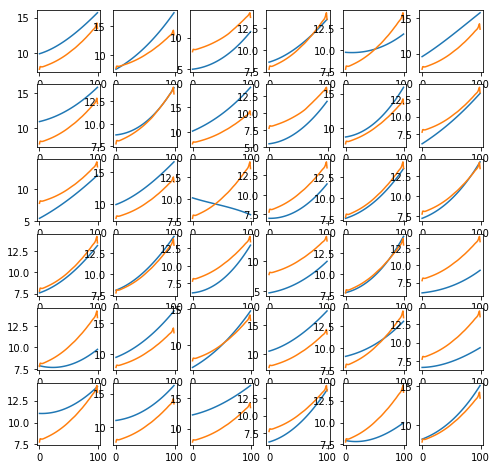

In [61]:
fig, axs = plt.subplots(6, 6, figsize=(8, 8))
axs.reshape(-1)
for i in range (0,6):
    for j in range(0,6):
        k = np.random.randint(0, y1_results4.shape[0])
        ax = axs[i,j]
        ax.plot(y2[k])
        ax.plot(y1_results4[k])

In [64]:
x = np.linspace(0,1,100)

y1 = []
y2 = []
a = []
b = []
c = []
d = []

for i in range(5000):

    a_ = np.random.normal(8, 1.5, 1)
    b_ = np.random.normal(2, 2, 1)
    c_ = np.random.normal(4, 1, 1)
    d_ = np.random.normal(0, 0.5, 1)

    y1_, y2_ = function_gen(x, a_, b_, c_, d_)
    
    y1.append(y1_)
    y2.append(y2_)
    a.append(a_)
    b.append(b_)
    c.append(c_)
    d.append(d_)
y2

[array([ 9.99211949, 10.0102918 , 10.02960945, 10.05007166, 10.07167763,
        10.09442656, 10.11831764, 10.14335008, 10.16952307, 10.19683583,
        10.22528755, 10.25487743, 10.28560467, 10.31746847, 10.35046803,
        10.38460256, 10.41987125, 10.4562733 , 10.49380793, 10.53247431,
        10.57227167, 10.61319919, 10.65525608, 10.69844153, 10.74275476,
        10.78819496, 10.83476133, 10.88245306, 10.93126938, 10.98120946,
        11.03227252, 11.08445775, 11.13776436, 11.19219154, 11.24773849,
        11.30440443, 11.36218854, 11.42109003, 11.4811081 , 11.54224195,
        11.60449078, 11.66785379, 11.73233018, 11.79791915, 11.86461991,
        11.93243165, 12.00135357, 12.07138488, 12.14252477, 12.21477245,
        12.28812712, 12.36258797, 12.43815422, 12.51482505, 12.59259967,
        12.67147728, 12.75145708, 12.83253828, 12.91472006, 12.99800164,
        13.08238221, 13.16786098, 13.25443714, 13.3421099 , 13.43087845,
        13.520742  , 13.61169975, 13.7037509 , 13.7

In [66]:
auto_test = rnn_auto(LSTM, 64, 1, 1, 10, 100)
auto_test.fit(np.atleast_3d(y1), np.atleast_3d(y2), epochs=2500, batch_size=2000)

Epoch 1/2500
5000/5000 [==============================] - 3s 583us/step - loss: 116.2322
Epoch 2/2500
5000/5000 [==============================] - 2s 388us/step - loss: 115.9495
Epoch 3/2500
5000/5000 [==============================] - 2s 383us/step - loss: 115.6411
Epoch 4/2500
5000/5000 [==============================] - 2s 389us/step - loss: 115.3278
Epoch 5/2500
5000/5000 [==============================] - 2s 384us/step - loss: 115.0116
Epoch 6/2500
5000/5000 [==============================] - 2s 392us/step - loss: 114.6935
Epoch 7/2500
5000/5000 [==============================] - 2s 389us/step - loss: 114.3745
Epoch 8/2500
5000/5000 [==============================] - 2s 385us/step - loss: 114.0527
Epoch 9/2500
5000/5000 [==============================] - 2s 388us/step - loss: 113.7281
Epoch 10/2500
5000/5000 [==============================] - 2s 395us/step - loss: 113.4012
Epoch 11/2500
5000/5000 [==============================] - 2s 388us/step - loss: 113.0692
Epoch 12/2500
5000/

5000/5000 [==============================] - 2s 388us/step - loss: 53.3883
Epoch 93/2500
5000/5000 [==============================] - 2s 389us/step - loss: 52.5599
Epoch 94/2500
5000/5000 [==============================] - 2s 386us/step - loss: 51.7389
Epoch 95/2500
5000/5000 [==============================] - 2s 388us/step - loss: 50.9237
Epoch 96/2500
5000/5000 [==============================] - 2s 385us/step - loss: 50.1190
Epoch 97/2500
5000/5000 [==============================] - 2s 387us/step - loss: 49.3219
Epoch 98/2500
5000/5000 [==============================] - 2s 386us/step - loss: 48.5333
Epoch 99/2500
5000/5000 [==============================] - 2s 387us/step - loss: 47.7518
Epoch 100/2500
5000/5000 [==============================] - 2s 387us/step - loss: 46.9804
Epoch 101/2500
5000/5000 [==============================] - 2s 388us/step - loss: 46.2215
Epoch 102/2500
5000/5000 [==============================] - 2s 385us/step - loss: 45.4696
Epoch 103/2500
5000/5000 [======

5000/5000 [==============================] - 2s 411us/step - loss: 16.1286
Epoch 184/2500
5000/5000 [==============================] - 2s 393us/step - loss: 16.0029
Epoch 185/2500
5000/5000 [==============================] - 2s 394us/step - loss: 15.8790
Epoch 186/2500
5000/5000 [==============================] - 2s 383us/step - loss: 15.7585
Epoch 187/2500
5000/5000 [==============================] - 2s 384us/step - loss: 15.6416
Epoch 188/2500
5000/5000 [==============================] - 2s 386us/step - loss: 15.5265
Epoch 189/2500
5000/5000 [==============================] - 2s 384us/step - loss: 15.4137
Epoch 190/2500
5000/5000 [==============================] - 2s 390us/step - loss: 15.3044
Epoch 191/2500
5000/5000 [==============================] - 2s 388us/step - loss: 15.1969
Epoch 192/2500
5000/5000 [==============================] - 2s 383us/step - loss: 15.0927
Epoch 193/2500
5000/5000 [==============================] - 2s 390us/step - loss: 14.9901
Epoch 194/2500
5000/5000 

5000/5000 [==============================] - 2s 395us/step - loss: 11.0147
Epoch 275/2500
5000/5000 [==============================] - 2s 390us/step - loss: 10.9927
Epoch 276/2500
5000/5000 [==============================] - 2s 386us/step - loss: 10.9706
Epoch 277/2500
5000/5000 [==============================] - 2s 380us/step - loss: 10.9476
Epoch 278/2500
5000/5000 [==============================] - 2s 381us/step - loss: 10.9247
Epoch 279/2500
5000/5000 [==============================] - 2s 386us/step - loss: 10.9023
Epoch 280/2500
5000/5000 [==============================] - 2s 390us/step - loss: 10.8795
Epoch 281/2500
5000/5000 [==============================] - 2s 384us/step - loss: 10.8583
Epoch 282/2500
5000/5000 [==============================] - 2s 384us/step - loss: 10.8372
Epoch 283/2500
5000/5000 [==============================] - 2s 384us/step - loss: 10.8171
Epoch 284/2500
5000/5000 [==============================] - 2s 389us/step - loss: 10.7991
Epoch 285/2500
5000/5000 

5000/5000 [==============================] - 2s 383us/step - loss: 9.4455
Epoch 366/2500
5000/5000 [==============================] - 2s 390us/step - loss: 9.3914
Epoch 367/2500
5000/5000 [==============================] - 2s 384us/step - loss: 9.3318
Epoch 368/2500
5000/5000 [==============================] - 2s 387us/step - loss: 9.2738
Epoch 369/2500
5000/5000 [==============================] - 2s 389us/step - loss: 9.2198
Epoch 370/2500
5000/5000 [==============================] - 2s 388us/step - loss: 9.1722
Epoch 371/2500
5000/5000 [==============================] - 2s 388us/step - loss: 9.1293
Epoch 372/2500
5000/5000 [==============================] - 2s 393us/step - loss: 9.0920
Epoch 373/2500
5000/5000 [==============================] - 2s 388us/step - loss: 9.0568
Epoch 374/2500
5000/5000 [==============================] - 2s 395us/step - loss: 9.0231
Epoch 375/2500
5000/5000 [==============================] - 2s 387us/step - loss: 8.9923
Epoch 376/2500
5000/5000 [==========

5000/5000 [==============================] - 2s 390us/step - loss: 6.2416
Epoch 458/2500
5000/5000 [==============================] - 2s 388us/step - loss: 6.2176
Epoch 459/2500
5000/5000 [==============================] - 2s 386us/step - loss: 6.1937
Epoch 460/2500
5000/5000 [==============================] - 2s 389us/step - loss: 6.1714
Epoch 461/2500
5000/5000 [==============================] - 2s 386us/step - loss: 6.1507
Epoch 462/2500
5000/5000 [==============================] - 2s 385us/step - loss: 6.1294
Epoch 463/2500
5000/5000 [==============================] - 2s 388us/step - loss: 6.1074
Epoch 464/2500
5000/5000 [==============================] - 2s 387us/step - loss: 6.0864
Epoch 465/2500
5000/5000 [==============================] - 2s 383us/step - loss: 6.0656
Epoch 466/2500
5000/5000 [==============================] - 2s 388us/step - loss: 6.0468
Epoch 467/2500
5000/5000 [==============================] - 2s 382us/step - loss: 6.0269
Epoch 468/2500
5000/5000 [==========

5000/5000 [==============================] - 2s 390us/step - loss: 4.8576
Epoch 550/2500
5000/5000 [==============================] - 2s 381us/step - loss: 4.8464
Epoch 551/2500
5000/5000 [==============================] - 2s 383us/step - loss: 4.8352
Epoch 552/2500
5000/5000 [==============================] - 2s 387us/step - loss: 4.8229
Epoch 553/2500
5000/5000 [==============================] - 2s 384us/step - loss: 4.8132
Epoch 554/2500
5000/5000 [==============================] - 2s 383us/step - loss: 4.8040
Epoch 555/2500
5000/5000 [==============================] - 2s 385us/step - loss: 4.7921
Epoch 556/2500
5000/5000 [==============================] - 2s 388us/step - loss: 4.7821
Epoch 557/2500
5000/5000 [==============================] - 2s 384us/step - loss: 4.7722
Epoch 558/2500
5000/5000 [==============================] - 2s 382us/step - loss: 4.7612
Epoch 559/2500
5000/5000 [==============================] - 2s 385us/step - loss: 4.7511
Epoch 560/2500
5000/5000 [==========

5000/5000 [==============================] - 2s 382us/step - loss: 3.9833
Epoch 642/2500
5000/5000 [==============================] - 2s 387us/step - loss: 3.9734
Epoch 643/2500
5000/5000 [==============================] - 2s 385us/step - loss: 3.9655
Epoch 644/2500
5000/5000 [==============================] - 2s 393us/step - loss: 3.9554
Epoch 645/2500
5000/5000 [==============================] - 2s 387us/step - loss: 3.9502
Epoch 646/2500
5000/5000 [==============================] - 2s 386us/step - loss: 3.9401
Epoch 647/2500
5000/5000 [==============================] - 2s 390us/step - loss: 3.9329
Epoch 648/2500
5000/5000 [==============================] - 2s 382us/step - loss: 3.9275
Epoch 649/2500
5000/5000 [==============================] - 2s 388us/step - loss: 3.9214
Epoch 650/2500
5000/5000 [==============================] - 2s 389us/step - loss: 3.9129
Epoch 651/2500
5000/5000 [==============================] - 2s 390us/step - loss: 3.9013
Epoch 652/2500
5000/5000 [==========

5000/5000 [==============================] - 2s 383us/step - loss: 3.4073
Epoch 734/2500
5000/5000 [==============================] - 2s 383us/step - loss: 3.4001
Epoch 735/2500
5000/5000 [==============================] - 2s 383us/step - loss: 3.3954
Epoch 736/2500
5000/5000 [==============================] - 2s 390us/step - loss: 3.3926
Epoch 737/2500
5000/5000 [==============================] - 2s 384us/step - loss: 3.3872
Epoch 738/2500
5000/5000 [==============================] - 2s 384us/step - loss: 3.3802
Epoch 739/2500
5000/5000 [==============================] - 2s 387us/step - loss: 3.3775
Epoch 740/2500
5000/5000 [==============================] - 2s 387us/step - loss: 3.3698
Epoch 741/2500
5000/5000 [==============================] - 2s 388us/step - loss: 3.3647
Epoch 742/2500
5000/5000 [==============================] - 2s 384us/step - loss: 3.3610
Epoch 743/2500
5000/5000 [==============================] - 2s 380us/step - loss: 3.3559
Epoch 744/2500
5000/5000 [==========

5000/5000 [==============================] - 2s 381us/step - loss: 2.9772
Epoch 826/2500
5000/5000 [==============================] - 2s 386us/step - loss: 2.9747
Epoch 827/2500
5000/5000 [==============================] - 2s 390us/step - loss: 2.9688
Epoch 828/2500
5000/5000 [==============================] - 2s 384us/step - loss: 2.9666
Epoch 829/2500
5000/5000 [==============================] - 2s 385us/step - loss: 2.9602
Epoch 830/2500
5000/5000 [==============================] - 2s 387us/step - loss: 2.9572
Epoch 831/2500
5000/5000 [==============================] - 2s 387us/step - loss: 2.9526
Epoch 832/2500
5000/5000 [==============================] - 2s 393us/step - loss: 2.9476
Epoch 833/2500
5000/5000 [==============================] - 2s 388us/step - loss: 2.9450
Epoch 834/2500
5000/5000 [==============================] - 2s 385us/step - loss: 2.9399
Epoch 835/2500
5000/5000 [==============================] - 2s 392us/step - loss: 2.9359
Epoch 836/2500
5000/5000 [==========

5000/5000 [==============================] - 2s 390us/step - loss: 2.5778
Epoch 918/2500
5000/5000 [==============================] - 2s 388us/step - loss: 2.5744
Epoch 919/2500
5000/5000 [==============================] - 2s 384us/step - loss: 2.5675
Epoch 920/2500
5000/5000 [==============================] - 2s 386us/step - loss: 2.5626
Epoch 921/2500
5000/5000 [==============================] - 2s 386us/step - loss: 2.5573
Epoch 922/2500
5000/5000 [==============================] - 2s 390us/step - loss: 2.5510
Epoch 923/2500
5000/5000 [==============================] - 2s 394us/step - loss: 2.5489
Epoch 924/2500
5000/5000 [==============================] - 2s 386us/step - loss: 2.5427
Epoch 925/2500
5000/5000 [==============================] - 2s 383us/step - loss: 2.5381
Epoch 926/2500
5000/5000 [==============================] - 2s 388us/step - loss: 2.5350
Epoch 927/2500
5000/5000 [==============================] - 2s 390us/step - loss: 2.5300
Epoch 928/2500
5000/5000 [==========

5000/5000 [==============================] - 2s 388us/step - loss: 2.1886
Epoch 1010/2500
5000/5000 [==============================] - 2s 387us/step - loss: 2.1864
Epoch 1011/2500
5000/5000 [==============================] - 2s 389us/step - loss: 2.1823
Epoch 1012/2500
5000/5000 [==============================] - 2s 385us/step - loss: 2.1793
Epoch 1013/2500
5000/5000 [==============================] - 2s 386us/step - loss: 2.1762
Epoch 1014/2500
5000/5000 [==============================] - 2s 391us/step - loss: 2.1718
Epoch 1015/2500
5000/5000 [==============================] - 2s 390us/step - loss: 2.1692
Epoch 1016/2500
5000/5000 [==============================] - 2s 386us/step - loss: 2.1678
Epoch 1017/2500
5000/5000 [==============================] - 2s 391us/step - loss: 2.1654
Epoch 1018/2500
5000/5000 [==============================] - 2s 381us/step - loss: 2.1599
Epoch 1019/2500
5000/5000 [==============================] - 2s 383us/step - loss: 2.1571
Epoch 1020/2500
5000/5000 

5000/5000 [==============================] - 2s 381us/step - loss: 1.9283
Epoch 1101/2500
5000/5000 [==============================] - 2s 386us/step - loss: 1.9264
Epoch 1102/2500
5000/5000 [==============================] - 2s 384us/step - loss: 1.9236
Epoch 1103/2500
5000/5000 [==============================] - 2s 387us/step - loss: 1.9218
Epoch 1104/2500
5000/5000 [==============================] - 2s 388us/step - loss: 1.9199
Epoch 1105/2500
5000/5000 [==============================] - 2s 384us/step - loss: 1.9181
Epoch 1106/2500
5000/5000 [==============================] - 2s 384us/step - loss: 1.9181
Epoch 1107/2500
5000/5000 [==============================] - 2s 385us/step - loss: 1.9121
Epoch 1108/2500
5000/5000 [==============================] - 2s 389us/step - loss: 1.9105
Epoch 1109/2500
5000/5000 [==============================] - 2s 382us/step - loss: 1.9087
Epoch 1110/2500
5000/5000 [==============================] - 2s 387us/step - loss: 1.9057
Epoch 1111/2500
5000/5000 

5000/5000 [==============================] - 2s 386us/step - loss: 1.7387
Epoch 1192/2500
5000/5000 [==============================] - 2s 391us/step - loss: 1.7384
Epoch 1193/2500
5000/5000 [==============================] - 2s 385us/step - loss: 1.7363
Epoch 1194/2500
5000/5000 [==============================] - 2s 388us/step - loss: 1.7347
Epoch 1195/2500
5000/5000 [==============================] - 2s 388us/step - loss: 1.7304
Epoch 1196/2500
5000/5000 [==============================] - 2s 388us/step - loss: 1.7271
Epoch 1197/2500
5000/5000 [==============================] - 2s 385us/step - loss: 1.7261
Epoch 1198/2500
5000/5000 [==============================] - 2s 390us/step - loss: 1.7260
Epoch 1199/2500
5000/5000 [==============================] - 2s 392us/step - loss: 1.7217
Epoch 1200/2500
5000/5000 [==============================] - 2s 383us/step - loss: 1.7215
Epoch 1201/2500
5000/5000 [==============================] - 2s 385us/step - loss: 1.7197
Epoch 1202/2500
5000/5000 

5000/5000 [==============================] - 2s 389us/step - loss: 1.5785
Epoch 1283/2500
5000/5000 [==============================] - 2s 386us/step - loss: 1.5720
Epoch 1284/2500
5000/5000 [==============================] - 2s 381us/step - loss: 1.5698
Epoch 1285/2500
5000/5000 [==============================] - 2s 395us/step - loss: 1.5666
Epoch 1286/2500
5000/5000 [==============================] - 2s 386us/step - loss: 1.5659
Epoch 1287/2500
5000/5000 [==============================] - 2s 382us/step - loss: 1.5629
Epoch 1288/2500
5000/5000 [==============================] - 2s 390us/step - loss: 1.5649
Epoch 1289/2500
5000/5000 [==============================] - 2s 392us/step - loss: 1.5614
Epoch 1290/2500
5000/5000 [==============================] - 2s 386us/step - loss: 1.5615
Epoch 1291/2500
5000/5000 [==============================] - 2s 393us/step - loss: 1.5567
Epoch 1292/2500
5000/5000 [==============================] - 2s 388us/step - loss: 1.5550
Epoch 1293/2500
5000/5000 

5000/5000 [==============================] - 2s 384us/step - loss: 1.4216
Epoch 1374/2500
5000/5000 [==============================] - 2s 384us/step - loss: 1.4192
Epoch 1375/2500
5000/5000 [==============================] - 2s 382us/step - loss: 1.4187
Epoch 1376/2500
5000/5000 [==============================] - 2s 388us/step - loss: 1.4159
Epoch 1377/2500
5000/5000 [==============================] - 2s 385us/step - loss: 1.4184
Epoch 1378/2500
5000/5000 [==============================] - 2s 386us/step - loss: 1.4160
Epoch 1379/2500
5000/5000 [==============================] - 2s 386us/step - loss: 1.4144
Epoch 1380/2500
5000/5000 [==============================] - 2s 390us/step - loss: 1.4112
Epoch 1381/2500
5000/5000 [==============================] - 2s 386us/step - loss: 1.4101
Epoch 1382/2500
5000/5000 [==============================] - 2s 387us/step - loss: 1.4065
Epoch 1383/2500
5000/5000 [==============================] - 2s 387us/step - loss: 1.4111
Epoch 1384/2500
5000/5000 

5000/5000 [==============================] - 2s 392us/step - loss: 1.3056
Epoch 1465/2500
5000/5000 [==============================] - 2s 388us/step - loss: 1.3058
Epoch 1466/2500
5000/5000 [==============================] - 2s 390us/step - loss: 1.3003
Epoch 1467/2500
5000/5000 [==============================] - 2s 383us/step - loss: 1.3021
Epoch 1468/2500
5000/5000 [==============================] - 2s 386us/step - loss: 1.3000
Epoch 1469/2500
5000/5000 [==============================] - 2s 391us/step - loss: 1.2983
Epoch 1470/2500
5000/5000 [==============================] - 2s 387us/step - loss: 1.2947
Epoch 1471/2500
5000/5000 [==============================] - 2s 384us/step - loss: 1.2917
Epoch 1472/2500
5000/5000 [==============================] - 2s 385us/step - loss: 1.2909
Epoch 1473/2500
5000/5000 [==============================] - 2s 381us/step - loss: 1.2951
Epoch 1474/2500
5000/5000 [==============================] - 2s 385us/step - loss: 1.2975
Epoch 1475/2500
5000/5000 

5000/5000 [==============================] - 2s 381us/step - loss: 1.1994
Epoch 1556/2500
5000/5000 [==============================] - 2s 387us/step - loss: 1.1968
Epoch 1557/2500
5000/5000 [==============================] - 2s 389us/step - loss: 1.1962
Epoch 1558/2500
5000/5000 [==============================] - 2s 386us/step - loss: 1.1934
Epoch 1559/2500
5000/5000 [==============================] - 2s 390us/step - loss: 1.1911
Epoch 1560/2500
5000/5000 [==============================] - 2s 386us/step - loss: 1.1904
Epoch 1561/2500
5000/5000 [==============================] - 2s 385us/step - loss: 1.1902
Epoch 1562/2500
5000/5000 [==============================] - 2s 387us/step - loss: 1.1898
Epoch 1563/2500
5000/5000 [==============================] - 2s 386us/step - loss: 1.1863
Epoch 1564/2500
5000/5000 [==============================] - 2s 386us/step - loss: 1.1853
Epoch 1565/2500
5000/5000 [==============================] - 2s 389us/step - loss: 1.1838
Epoch 1566/2500
5000/5000 

5000/5000 [==============================] - 2s 385us/step - loss: 1.0962
Epoch 1647/2500
5000/5000 [==============================] - 2s 388us/step - loss: 1.0960
Epoch 1648/2500
5000/5000 [==============================] - 2s 385us/step - loss: 1.0938
Epoch 1649/2500
5000/5000 [==============================] - 2s 389us/step - loss: 1.0927
Epoch 1650/2500
5000/5000 [==============================] - 2s 388us/step - loss: 1.0910
Epoch 1651/2500
5000/5000 [==============================] - 2s 389us/step - loss: 1.0898
Epoch 1652/2500
5000/5000 [==============================] - 2s 385us/step - loss: 1.0914
Epoch 1653/2500
5000/5000 [==============================] - 2s 382us/step - loss: 1.0897
Epoch 1654/2500
5000/5000 [==============================] - 2s 386us/step - loss: 1.0897
Epoch 1655/2500
5000/5000 [==============================] - 2s 382us/step - loss: 1.0895
Epoch 1656/2500
5000/5000 [==============================] - 2s 382us/step - loss: 1.0910
Epoch 1657/2500
5000/5000 

5000/5000 [==============================] - 2s 390us/step - loss: 1.0006
Epoch 1738/2500
5000/5000 [==============================] - 2s 386us/step - loss: 1.0009
Epoch 1739/2500
5000/5000 [==============================] - 2s 380us/step - loss: 0.9977
Epoch 1740/2500
5000/5000 [==============================] - 2s 385us/step - loss: 0.9983
Epoch 1741/2500
5000/5000 [==============================] - 2s 383us/step - loss: 0.9970
Epoch 1742/2500
5000/5000 [==============================] - 2s 387us/step - loss: 0.9959
Epoch 1743/2500
5000/5000 [==============================] - 2s 390us/step - loss: 0.9957
Epoch 1744/2500
5000/5000 [==============================] - 2s 383us/step - loss: 0.9923
Epoch 1745/2500
5000/5000 [==============================] - 2s 387us/step - loss: 0.9922
Epoch 1746/2500
5000/5000 [==============================] - 2s 388us/step - loss: 0.9966
Epoch 1747/2500
5000/5000 [==============================] - 2s 382us/step - loss: 0.9982
Epoch 1748/2500
5000/5000 

5000/5000 [==============================] - 2s 385us/step - loss: 0.9111
Epoch 1829/2500
5000/5000 [==============================] - 2s 380us/step - loss: 0.9116
Epoch 1830/2500
5000/5000 [==============================] - 2s 386us/step - loss: 0.9097
Epoch 1831/2500
5000/5000 [==============================] - 2s 390us/step - loss: 0.9086
Epoch 1832/2500
5000/5000 [==============================] - 2s 384us/step - loss: 0.9095
Epoch 1833/2500
5000/5000 [==============================] - 2s 386us/step - loss: 0.9094
Epoch 1834/2500
5000/5000 [==============================] - 2s 389us/step - loss: 0.9073
Epoch 1835/2500
5000/5000 [==============================] - 2s 389us/step - loss: 0.9065
Epoch 1836/2500
5000/5000 [==============================] - 2s 385us/step - loss: 0.9031
Epoch 1837/2500
5000/5000 [==============================] - 2s 383us/step - loss: 0.9034
Epoch 1838/2500
5000/5000 [==============================] - 2s 384us/step - loss: 0.9016
Epoch 1839/2500
5000/5000 

5000/5000 [==============================] - 2s 388us/step - loss: 0.8308
Epoch 1920/2500
5000/5000 [==============================] - 2s 382us/step - loss: 0.8305
Epoch 1921/2500
5000/5000 [==============================] - 2s 390us/step - loss: 0.8329
Epoch 1922/2500
5000/5000 [==============================] - 2s 383us/step - loss: 0.8299
Epoch 1923/2500
5000/5000 [==============================] - 2s 391us/step - loss: 0.8290
Epoch 1924/2500
5000/5000 [==============================] - 2s 398us/step - loss: 0.8286
Epoch 1925/2500
5000/5000 [==============================] - 2s 381us/step - loss: 0.8290
Epoch 1926/2500
5000/5000 [==============================] - 2s 383us/step - loss: 0.8245
Epoch 1927/2500
5000/5000 [==============================] - 2s 383us/step - loss: 0.8251
Epoch 1928/2500
5000/5000 [==============================] - 2s 401us/step - loss: 0.8253
Epoch 1929/2500
5000/5000 [==============================] - 2s 387us/step - loss: 0.8243
Epoch 1930/2500
5000/5000 

5000/5000 [==============================] - 2s 380us/step - loss: 0.7576
Epoch 2011/2500
5000/5000 [==============================] - 2s 383us/step - loss: 0.7573
Epoch 2012/2500
5000/5000 [==============================] - 2s 385us/step - loss: 0.7547
Epoch 2013/2500
5000/5000 [==============================] - 2s 385us/step - loss: 0.7528
Epoch 2014/2500
5000/5000 [==============================] - 2s 385us/step - loss: 0.7552
Epoch 2015/2500
5000/5000 [==============================] - 2s 383us/step - loss: 0.7527
Epoch 2016/2500
5000/5000 [==============================] - 2s 391us/step - loss: 0.7509
Epoch 2017/2500
5000/5000 [==============================] - 2s 389us/step - loss: 0.7517
Epoch 2018/2500
5000/5000 [==============================] - 2s 385us/step - loss: 0.7521
Epoch 2019/2500
5000/5000 [==============================] - 2s 378us/step - loss: 0.7511
Epoch 2020/2500
5000/5000 [==============================] - 2s 388us/step - loss: 0.7502
Epoch 2021/2500
5000/5000 

5000/5000 [==============================] - 2s 386us/step - loss: 0.6876
Epoch 2102/2500
5000/5000 [==============================] - 2s 381us/step - loss: 0.6852
Epoch 2103/2500
5000/5000 [==============================] - 2s 384us/step - loss: 0.6845
Epoch 2104/2500
5000/5000 [==============================] - 2s 382us/step - loss: 0.6847
Epoch 2105/2500
5000/5000 [==============================] - 2s 387us/step - loss: 0.6871
Epoch 2106/2500
5000/5000 [==============================] - 2s 380us/step - loss: 0.6822
Epoch 2107/2500
5000/5000 [==============================] - 2s 395us/step - loss: 0.6812
Epoch 2108/2500
5000/5000 [==============================] - 2s 385us/step - loss: 0.6802
Epoch 2109/2500
5000/5000 [==============================] - 2s 389us/step - loss: 0.6805
Epoch 2110/2500
5000/5000 [==============================] - 2s 387us/step - loss: 0.6831
Epoch 2111/2500
5000/5000 [==============================] - 2s 387us/step - loss: 0.6795
Epoch 2112/2500
5000/5000 

5000/5000 [==============================] - 2s 389us/step - loss: 0.6176
Epoch 2193/2500
5000/5000 [==============================] - 2s 388us/step - loss: 0.6163
Epoch 2194/2500
5000/5000 [==============================] - 2s 390us/step - loss: 0.6186
Epoch 2195/2500
5000/5000 [==============================] - 2s 383us/step - loss: 0.6164
Epoch 2196/2500
5000/5000 [==============================] - 2s 385us/step - loss: 0.6153
Epoch 2197/2500
5000/5000 [==============================] - 2s 382us/step - loss: 0.6161
Epoch 2198/2500
5000/5000 [==============================] - 2s 387us/step - loss: 0.6143
Epoch 2199/2500
5000/5000 [==============================] - 2s 386us/step - loss: 0.6130
Epoch 2200/2500
5000/5000 [==============================] - 2s 384us/step - loss: 0.6165
Epoch 2201/2500
5000/5000 [==============================] - 2s 388us/step - loss: 0.6120
Epoch 2202/2500
5000/5000 [==============================] - 2s 384us/step - loss: 0.6116
Epoch 2203/2500
5000/5000 

5000/5000 [==============================] - 2s 385us/step - loss: 0.5633
Epoch 2284/2500
5000/5000 [==============================] - 2s 385us/step - loss: 0.5579
Epoch 2285/2500
5000/5000 [==============================] - 2s 385us/step - loss: 0.5616
Epoch 2286/2500
5000/5000 [==============================] - 2s 384us/step - loss: 0.5568
Epoch 2287/2500
5000/5000 [==============================] - 2s 382us/step - loss: 0.5558
Epoch 2288/2500
5000/5000 [==============================] - 2s 387us/step - loss: 0.5567
Epoch 2289/2500
5000/5000 [==============================] - 2s 391us/step - loss: 0.5554
Epoch 2290/2500
5000/5000 [==============================] - 2s 385us/step - loss: 0.5544
Epoch 2291/2500
5000/5000 [==============================] - 2s 390us/step - loss: 0.5552
Epoch 2292/2500
5000/5000 [==============================] - 2s 389us/step - loss: 0.5536
Epoch 2293/2500
5000/5000 [==============================] - 2s 384us/step - loss: 0.5535
Epoch 2294/2500
5000/5000 

5000/5000 [==============================] - 2s 385us/step - loss: 0.5066
Epoch 2375/2500
5000/5000 [==============================] - 2s 389us/step - loss: 0.5054
Epoch 2376/2500
5000/5000 [==============================] - 2s 391us/step - loss: 0.5049
Epoch 2377/2500
5000/5000 [==============================] - 2s 389us/step - loss: 0.5056
Epoch 2378/2500
5000/5000 [==============================] - 2s 385us/step - loss: 0.5130
Epoch 2379/2500
5000/5000 [==============================] - 2s 387us/step - loss: 0.5062
Epoch 2380/2500
5000/5000 [==============================] - 2s 383us/step - loss: 0.5076
Epoch 2381/2500
5000/5000 [==============================] - 2s 391us/step - loss: 0.5040
Epoch 2382/2500
5000/5000 [==============================] - 2s 386us/step - loss: 0.5080
Epoch 2383/2500
5000/5000 [==============================] - 2s 388us/step - loss: 0.5022
Epoch 2384/2500
5000/5000 [==============================] - 2s 383us/step - loss: 0.5017
Epoch 2385/2500
5000/5000 

5000/5000 [==============================] - 2s 388us/step - loss: 0.4613
Epoch 2466/2500
5000/5000 [==============================] - 2s 386us/step - loss: 0.4620
Epoch 2467/2500
5000/5000 [==============================] - 2s 386us/step - loss: 0.4571
Epoch 2468/2500
5000/5000 [==============================] - 2s 386us/step - loss: 0.4576
Epoch 2469/2500
5000/5000 [==============================] - 2s 386us/step - loss: 0.4563
Epoch 2470/2500
5000/5000 [==============================] - 2s 388us/step - loss: 0.4574
Epoch 2471/2500
5000/5000 [==============================] - 2s 390us/step - loss: 0.4556
Epoch 2472/2500
5000/5000 [==============================] - 2s 395us/step - loss: 0.4626
Epoch 2473/2500
5000/5000 [==============================] - 2s 392us/step - loss: 0.4580
Epoch 2474/2500
5000/5000 [==============================] - 2s 381us/step - loss: 0.4640
Epoch 2475/2500
5000/5000 [==============================] - 2s 387us/step - loss: 0.4545
Epoch 2476/2500
5000/5000 

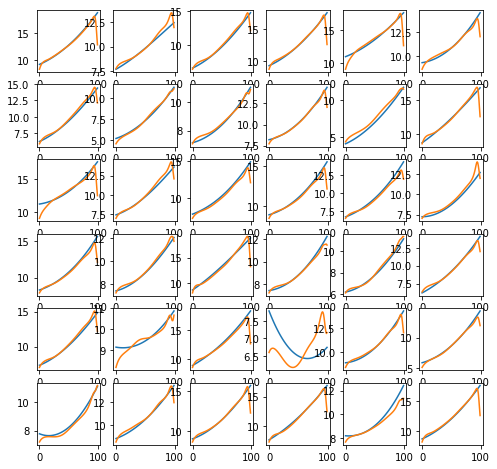

In [67]:
auto_test.save('auto_test')
y1_results5 = auto_test.predict(np.atleast_3d(y1))
fig, axs = plt.subplots(6, 6, figsize=(8, 8))
axs.reshape(-1)
for i in range (0,6):
    for j in range(0,6):
        k = np.random.randint(0, y1_results5.shape[0])
        ax = axs[i,j]
        ax.plot(y2[k])
        ax.plot(y1_results5[k])

In [69]:
x = np.linspace(0,1,100)

y1 = []
y2 = []
a = []
b = []
c = []
d = []

for i in range(2500):

    a_ = np.random.normal(8, 1.5, 1)
    b_ = np.random.normal(2, 2, 1)
    c_ = np.random.normal(4, 1, 1)
    d_ = np.random.normal(0, 0.5, 1)

    y1_, y2_ = function_gen(x, a_, b_, c_, d_)
    
    y1.append(y1_)
    y2.append(y2_)
    a.append(a_)
    b.append(b_)
    c.append(c_)
    d.append(d_)


In [70]:
auto_test = rnn_auto(LSTM, 64, 1, 1, 10, 100)
auto_test.fit(np.atleast_3d(y1), np.atleast_3d(y2), epochs=2500, batch_size=2000)

Epoch 1/2500
2500/2500 [==============================] - 2s 872us/step - loss: 112.1742
Epoch 2/2500
2500/2500 [==============================] - 1s 549us/step - loss: 112.0285
Epoch 3/2500
2500/2500 [==============================] - 1s 552us/step - loss: 111.8802
Epoch 4/2500
2500/2500 [==============================] - 1s 546us/step - loss: 111.7294
Epoch 5/2500
2500/2500 [==============================] - 1s 556us/step - loss: 111.5750
Epoch 6/2500
2500/2500 [==============================] - 1s 544us/step - loss: 111.4171
Epoch 7/2500
2500/2500 [==============================] - 1s 547us/step - loss: 111.2560
Epoch 8/2500
2500/2500 [==============================] - 1s 549us/step - loss: 111.0896
Epoch 9/2500
2500/2500 [==============================] - 1s 536us/step - loss: 110.9197
Epoch 10/2500
2500/2500 [==============================] - 1s 543us/step - loss: 110.7451
Epoch 11/2500
2500/2500 [==============================] - 1s 545us/step - loss: 110.5657
Epoch 12/2500
2500/

2500/2500 [==============================] - 1s 550us/step - loss: 65.5851
Epoch 93/2500
2500/2500 [==============================] - 1s 547us/step - loss: 64.8002
Epoch 94/2500
2500/2500 [==============================] - 1s 546us/step - loss: 64.0254
Epoch 95/2500
2500/2500 [==============================] - 1s 542us/step - loss: 63.2532
Epoch 96/2500
2500/2500 [==============================] - 1s 548us/step - loss: 62.4883
Epoch 97/2500
2500/2500 [==============================] - 1s 542us/step - loss: 61.7316
Epoch 98/2500
2500/2500 [==============================] - 1s 552us/step - loss: 60.9805
Epoch 99/2500
2500/2500 [==============================] - 1s 544us/step - loss: 60.2374
Epoch 100/2500
2500/2500 [==============================] - 1s 548us/step - loss: 59.5032
Epoch 101/2500
2500/2500 [==============================] - 1s 551us/step - loss: 58.7752
Epoch 102/2500
2500/2500 [==============================] - 1s 544us/step - loss: 58.0588
Epoch 103/2500
2500/2500 [======

2500/2500 [==============================] - 1s 549us/step - loss: 24.6809
Epoch 184/2500
2500/2500 [==============================] - 1s 541us/step - loss: 24.4764
Epoch 185/2500
2500/2500 [==============================] - 1s 540us/step - loss: 24.2760
Epoch 186/2500
2500/2500 [==============================] - 1s 549us/step - loss: 24.0788
Epoch 187/2500
2500/2500 [==============================] - 1s 545us/step - loss: 23.8840
Epoch 188/2500
2500/2500 [==============================] - 1s 546us/step - loss: 23.6926
Epoch 189/2500
2500/2500 [==============================] - 1s 541us/step - loss: 23.5040
Epoch 190/2500
2500/2500 [==============================] - 1s 546us/step - loss: 23.3180
Epoch 191/2500
2500/2500 [==============================] - 1s 541us/step - loss: 23.1346
Epoch 192/2500
2500/2500 [==============================] - 1s 542us/step - loss: 22.9547
Epoch 193/2500
2500/2500 [==============================] - 1s 544us/step - loss: 22.7772
Epoch 194/2500
2500/2500 

2500/2500 [==============================] - 1s 545us/step - loss: 14.2228
Epoch 275/2500
2500/2500 [==============================] - 1s 552us/step - loss: 14.1627
Epoch 276/2500
2500/2500 [==============================] - 1s 545us/step - loss: 14.1038
Epoch 277/2500
2500/2500 [==============================] - 1s 548us/step - loss: 14.0467
Epoch 278/2500
2500/2500 [==============================] - 1s 547us/step - loss: 13.9900
Epoch 279/2500
2500/2500 [==============================] - 1s 545us/step - loss: 13.9330
Epoch 280/2500
2500/2500 [==============================] - 1s 550us/step - loss: 13.8773
Epoch 281/2500
2500/2500 [==============================] - 1s 555us/step - loss: 13.8222
Epoch 282/2500
2500/2500 [==============================] - 1s 545us/step - loss: 13.7687
Epoch 283/2500
2500/2500 [==============================] - 1s 541us/step - loss: 13.7140
Epoch 284/2500
2500/2500 [==============================] - 1s 550us/step - loss: 13.6611
Epoch 285/2500
2500/2500 

2500/2500 [==============================] - 1s 541us/step - loss: 11.0004
Epoch 366/2500
2500/2500 [==============================] - 1s 544us/step - loss: 10.9818
Epoch 367/2500
2500/2500 [==============================] - 1s 547us/step - loss: 10.9644
Epoch 368/2500
2500/2500 [==============================] - 1s 549us/step - loss: 10.9465
Epoch 369/2500
2500/2500 [==============================] - 1s 547us/step - loss: 10.9284
Epoch 370/2500
2500/2500 [==============================] - 1s 547us/step - loss: 10.9121
Epoch 371/2500
2500/2500 [==============================] - 1s 544us/step - loss: 10.8947
Epoch 372/2500
2500/2500 [==============================] - 1s 548us/step - loss: 10.8780
Epoch 373/2500
2500/2500 [==============================] - 1s 553us/step - loss: 10.8611
Epoch 374/2500
2500/2500 [==============================] - 1s 544us/step - loss: 10.8451
Epoch 375/2500
2500/2500 [==============================] - 1s 550us/step - loss: 10.8280
Epoch 376/2500
2500/2500 

2500/2500 [==============================] - 1s 545us/step - loss: 9.8669
Epoch 457/2500
2500/2500 [==============================] - 1s 549us/step - loss: 9.8551
Epoch 458/2500
2500/2500 [==============================] - 1s 539us/step - loss: 9.8432
Epoch 459/2500
2500/2500 [==============================] - 1s 546us/step - loss: 9.8311
Epoch 460/2500
2500/2500 [==============================] - 1s 545us/step - loss: 9.8201
Epoch 461/2500
2500/2500 [==============================] - 1s 548us/step - loss: 9.8082
Epoch 462/2500
2500/2500 [==============================] - 1s 549us/step - loss: 9.7956
Epoch 463/2500
2500/2500 [==============================] - 1s 551us/step - loss: 9.7836
Epoch 464/2500
2500/2500 [==============================] - 1s 543us/step - loss: 9.7710
Epoch 465/2500
2500/2500 [==============================] - 1s 548us/step - loss: 9.7588
Epoch 466/2500
2500/2500 [==============================] - 1s 544us/step - loss: 9.7466
Epoch 467/2500
2500/2500 [==========

2500/2500 [==============================] - 1s 545us/step - loss: 7.8290
Epoch 549/2500
2500/2500 [==============================] - 1s 540us/step - loss: 7.8090
Epoch 550/2500
2500/2500 [==============================] - 1s 546us/step - loss: 7.7898
Epoch 551/2500
2500/2500 [==============================] - 1s 542us/step - loss: 7.7716
Epoch 552/2500
2500/2500 [==============================] - 1s 550us/step - loss: 7.7528
Epoch 553/2500
2500/2500 [==============================] - 1s 548us/step - loss: 7.7344
Epoch 554/2500
2500/2500 [==============================] - 1s 545us/step - loss: 7.7137
Epoch 555/2500
2500/2500 [==============================] - 1s 542us/step - loss: 7.6947
Epoch 556/2500
2500/2500 [==============================] - 1s 551us/step - loss: 7.6758
Epoch 557/2500
2500/2500 [==============================] - 1s 545us/step - loss: 7.6571
Epoch 558/2500
2500/2500 [==============================] - 1s 548us/step - loss: 7.6382
Epoch 559/2500
2500/2500 [==========

2500/2500 [==============================] - 1s 547us/step - loss: 6.0305
Epoch 641/2500
2500/2500 [==============================] - 1s 547us/step - loss: 6.0125
Epoch 642/2500
2500/2500 [==============================] - 1s 544us/step - loss: 5.9921
Epoch 643/2500
2500/2500 [==============================] - 1s 542us/step - loss: 5.9753
Epoch 644/2500
2500/2500 [==============================] - 1s 549us/step - loss: 5.9552
Epoch 645/2500
2500/2500 [==============================] - 1s 551us/step - loss: 5.9365
Epoch 646/2500
2500/2500 [==============================] - 1s 545us/step - loss: 5.9167
Epoch 647/2500
2500/2500 [==============================] - 1s 542us/step - loss: 5.8991
Epoch 648/2500
2500/2500 [==============================] - 1s 548us/step - loss: 5.8789
Epoch 649/2500
2500/2500 [==============================] - 1s 552us/step - loss: 5.8597
Epoch 650/2500
2500/2500 [==============================] - 1s 545us/step - loss: 5.8399
Epoch 651/2500
2500/2500 [==========

2500/2500 [==============================] - 1s 547us/step - loss: 4.7679
Epoch 733/2500
2500/2500 [==============================] - 1s 546us/step - loss: 4.7551
Epoch 734/2500
2500/2500 [==============================] - 1s 548us/step - loss: 4.7492
Epoch 735/2500
2500/2500 [==============================] - 1s 548us/step - loss: 4.7414
Epoch 736/2500
2500/2500 [==============================] - 1s 548us/step - loss: 4.7315
Epoch 737/2500
2500/2500 [==============================] - 1s 542us/step - loss: 4.7210
Epoch 738/2500
2500/2500 [==============================] - 1s 547us/step - loss: 4.7086
Epoch 739/2500
2500/2500 [==============================] - 1s 550us/step - loss: 4.7024
Epoch 740/2500
2500/2500 [==============================] - 1s 544us/step - loss: 4.6956
Epoch 741/2500
2500/2500 [==============================] - 1s 543us/step - loss: 4.6850
Epoch 742/2500
2500/2500 [==============================] - 1s 554us/step - loss: 4.6790
Epoch 743/2500
2500/2500 [==========

2500/2500 [==============================] - 1s 549us/step - loss: 4.1059
Epoch 825/2500
2500/2500 [==============================] - 1s 539us/step - loss: 4.1020
Epoch 826/2500
2500/2500 [==============================] - 1s 542us/step - loss: 4.0980
Epoch 827/2500
2500/2500 [==============================] - 1s 546us/step - loss: 4.0875
Epoch 828/2500
2500/2500 [==============================] - 1s 548us/step - loss: 4.0833
Epoch 829/2500
2500/2500 [==============================] - 1s 551us/step - loss: 4.0783
Epoch 830/2500
2500/2500 [==============================] - 1s 545us/step - loss: 4.0704
Epoch 831/2500
2500/2500 [==============================] - 1s 540us/step - loss: 4.0639
Epoch 832/2500
2500/2500 [==============================] - 1s 547us/step - loss: 4.0590
Epoch 833/2500
2500/2500 [==============================] - 1s 547us/step - loss: 4.0535
Epoch 834/2500
2500/2500 [==============================] - 1s 544us/step - loss: 4.0509
Epoch 835/2500
2500/2500 [==========

2500/2500 [==============================] - 1s 552us/step - loss: 3.6327
Epoch 917/2500
2500/2500 [==============================] - 1s 547us/step - loss: 3.6274
Epoch 918/2500
2500/2500 [==============================] - 1s 545us/step - loss: 3.6202
Epoch 919/2500
2500/2500 [==============================] - 1s 544us/step - loss: 3.6160
Epoch 920/2500
2500/2500 [==============================] - 1s 542us/step - loss: 3.6126
Epoch 921/2500
2500/2500 [==============================] - 1s 551us/step - loss: 3.6124
Epoch 922/2500
2500/2500 [==============================] - 1s 551us/step - loss: 3.6051
Epoch 923/2500
2500/2500 [==============================] - 1s 548us/step - loss: 3.6044
Epoch 924/2500
2500/2500 [==============================] - 1s 547us/step - loss: 3.5993
Epoch 925/2500
2500/2500 [==============================] - 1s 551us/step - loss: 3.5915
Epoch 926/2500
2500/2500 [==============================] - 1s 547us/step - loss: 3.5883
Epoch 927/2500
2500/2500 [==========

2500/2500 [==============================] - 1s 547us/step - loss: 3.2983
Epoch 1009/2500
2500/2500 [==============================] - 1s 548us/step - loss: 3.2921
Epoch 1010/2500
2500/2500 [==============================] - 1s 516us/step - loss: 3.2922
Epoch 1011/2500
2500/2500 [==============================] - 1s 538us/step - loss: 3.2890
Epoch 1012/2500
2500/2500 [==============================] - 1s 554us/step - loss: 3.2815
Epoch 1013/2500
2500/2500 [==============================] - 1s 548us/step - loss: 3.2853
Epoch 1014/2500
2500/2500 [==============================] - 1s 535us/step - loss: 3.2795
Epoch 1015/2500
2500/2500 [==============================] - 1s 550us/step - loss: 3.2764
Epoch 1016/2500
2500/2500 [==============================] - 1s 547us/step - loss: 3.2723
Epoch 1017/2500
2500/2500 [==============================] - 1s 544us/step - loss: 3.2747
Epoch 1018/2500
2500/2500 [==============================] - 1s 545us/step - loss: 3.2716
Epoch 1019/2500
2500/2500 

2500/2500 [==============================] - 1s 547us/step - loss: 3.0347
Epoch 1100/2500
2500/2500 [==============================] - 1s 548us/step - loss: 3.0239
Epoch 1101/2500
2500/2500 [==============================] - 1s 547us/step - loss: 3.0206
Epoch 1102/2500
2500/2500 [==============================] - 1s 551us/step - loss: 3.0177
Epoch 1103/2500
2500/2500 [==============================] - 1s 552us/step - loss: 3.0138
Epoch 1104/2500
2500/2500 [==============================] - 1s 547us/step - loss: 3.0162
Epoch 1105/2500
2500/2500 [==============================] - 1s 545us/step - loss: 3.0129
Epoch 1106/2500
2500/2500 [==============================] - 1s 550us/step - loss: 3.0078
Epoch 1107/2500
2500/2500 [==============================] - 1s 541us/step - loss: 3.0090
Epoch 1108/2500
2500/2500 [==============================] - 1s 543us/step - loss: 3.0041
Epoch 1109/2500
2500/2500 [==============================] - 1s 544us/step - loss: 3.0027
Epoch 1110/2500
2500/2500 

2500/2500 [==============================] - 1s 543us/step - loss: 2.8076
Epoch 1191/2500
2500/2500 [==============================] - 1s 543us/step - loss: 2.8089
Epoch 1192/2500
2500/2500 [==============================] - 1s 545us/step - loss: 2.8030
Epoch 1193/2500
2500/2500 [==============================] - 1s 549us/step - loss: 2.8028
Epoch 1194/2500
2500/2500 [==============================] - 1s 551us/step - loss: 2.7948
Epoch 1195/2500
2500/2500 [==============================] - 1s 549us/step - loss: 2.7937
Epoch 1196/2500
2500/2500 [==============================] - 1s 547us/step - loss: 2.7930
Epoch 1197/2500
2500/2500 [==============================] - 1s 550us/step - loss: 2.7861
Epoch 1198/2500
2500/2500 [==============================] - 1s 550us/step - loss: 2.7857
Epoch 1199/2500
2500/2500 [==============================] - 1s 543us/step - loss: 2.7850
Epoch 1200/2500
2500/2500 [==============================] - 1s 544us/step - loss: 2.7808
Epoch 1201/2500
2500/2500 

2500/2500 [==============================] - 1s 552us/step - loss: 2.6133
Epoch 1282/2500
2500/2500 [==============================] - 1s 546us/step - loss: 2.6044
Epoch 1283/2500
2500/2500 [==============================] - 1s 555us/step - loss: 2.6023
Epoch 1284/2500
2500/2500 [==============================] - 1s 545us/step - loss: 2.5996
Epoch 1285/2500
2500/2500 [==============================] - 1s 545us/step - loss: 2.6015
Epoch 1286/2500
2500/2500 [==============================] - 1s 545us/step - loss: 2.6005
Epoch 1287/2500
2500/2500 [==============================] - 1s 549us/step - loss: 2.5956
Epoch 1288/2500
2500/2500 [==============================] - 1s 555us/step - loss: 2.5951
Epoch 1289/2500
2500/2500 [==============================] - 1s 551us/step - loss: 2.5964
Epoch 1290/2500
2500/2500 [==============================] - 1s 553us/step - loss: 2.5898
Epoch 1291/2500
2500/2500 [==============================] - 1s 563us/step - loss: 2.5864
Epoch 1292/2500
2500/2500 

2500/2500 [==============================] - 1s 554us/step - loss: 2.4247
Epoch 1373/2500
2500/2500 [==============================] - 1s 547us/step - loss: 2.4260
Epoch 1374/2500
2500/2500 [==============================] - 1s 544us/step - loss: 2.4223
Epoch 1375/2500
2500/2500 [==============================] - 1s 551us/step - loss: 2.4168
Epoch 1376/2500
2500/2500 [==============================] - 1s 550us/step - loss: 2.4221
Epoch 1377/2500
2500/2500 [==============================] - 1s 551us/step - loss: 2.4188
Epoch 1378/2500
2500/2500 [==============================] - 1s 557us/step - loss: 2.4206
Epoch 1379/2500
2500/2500 [==============================] - 1s 560us/step - loss: 2.4130
Epoch 1380/2500
2500/2500 [==============================] - 1s 560us/step - loss: 2.4156
Epoch 1381/2500
2500/2500 [==============================] - 1s 550us/step - loss: 2.4115
Epoch 1382/2500
2500/2500 [==============================] - 1s 563us/step - loss: 2.4083
Epoch 1383/2500
2500/2500 

2500/2500 [==============================] - 1s 552us/step - loss: 2.2540
Epoch 1464/2500
2500/2500 [==============================] - 1s 554us/step - loss: 2.2569
Epoch 1465/2500
2500/2500 [==============================] - 1s 540us/step - loss: 2.2522
Epoch 1466/2500
2500/2500 [==============================] - 1s 541us/step - loss: 2.2542
Epoch 1467/2500
2500/2500 [==============================] - 1s 537us/step - loss: 2.2607
Epoch 1468/2500
2500/2500 [==============================] - 1s 545us/step - loss: 2.2536
Epoch 1469/2500
2500/2500 [==============================] - 1s 546us/step - loss: 2.2501
Epoch 1470/2500
2500/2500 [==============================] - 1s 556us/step - loss: 2.2438
Epoch 1471/2500
2500/2500 [==============================] - 1s 559us/step - loss: 2.2421
Epoch 1472/2500
2500/2500 [==============================] - 1s 548us/step - loss: 2.2419
Epoch 1473/2500
2500/2500 [==============================] - 1s 547us/step - loss: 2.2416
Epoch 1474/2500
2500/2500 

2500/2500 [==============================] - 1s 549us/step - loss: 2.1059
Epoch 1555/2500
2500/2500 [==============================] - 1s 548us/step - loss: 2.1057
Epoch 1556/2500
2500/2500 [==============================] - 1s 548us/step - loss: 2.1045
Epoch 1557/2500
2500/2500 [==============================] - 1s 548us/step - loss: 2.1011
Epoch 1558/2500
2500/2500 [==============================] - 1s 550us/step - loss: 2.0983
Epoch 1559/2500
2500/2500 [==============================] - 1s 547us/step - loss: 2.1002
Epoch 1560/2500
2500/2500 [==============================] - 1s 548us/step - loss: 2.0974
Epoch 1561/2500
2500/2500 [==============================] - 1s 544us/step - loss: 2.0912
Epoch 1562/2500
2500/2500 [==============================] - 1s 549us/step - loss: 2.0910
Epoch 1563/2500
2500/2500 [==============================] - 1s 549us/step - loss: 2.0900
Epoch 1564/2500
2500/2500 [==============================] - 1s 544us/step - loss: 2.0908
Epoch 1565/2500
2500/2500 

2500/2500 [==============================] - 1s 551us/step - loss: 1.9823
Epoch 1646/2500
2500/2500 [==============================] - 1s 543us/step - loss: 1.9793
Epoch 1647/2500
2500/2500 [==============================] - 1s 547us/step - loss: 1.9766
Epoch 1648/2500
2500/2500 [==============================] - 1s 545us/step - loss: 1.9736
Epoch 1649/2500
2500/2500 [==============================] - 1s 544us/step - loss: 1.9731
Epoch 1650/2500
2500/2500 [==============================] - 1s 556us/step - loss: 1.9717
Epoch 1651/2500
2500/2500 [==============================] - 1s 551us/step - loss: 1.9676
Epoch 1652/2500
2500/2500 [==============================] - 1s 551us/step - loss: 1.9755
Epoch 1653/2500
2500/2500 [==============================] - 1s 541us/step - loss: 1.9682
Epoch 1654/2500
2500/2500 [==============================] - 1s 554us/step - loss: 1.9684
Epoch 1655/2500
2500/2500 [==============================] - 1s 544us/step - loss: 1.9678
Epoch 1656/2500
2500/2500 

2500/2500 [==============================] - 1s 553us/step - loss: 1.8618
Epoch 1737/2500
2500/2500 [==============================] - 1s 545us/step - loss: 1.8578
Epoch 1738/2500
2500/2500 [==============================] - 1s 545us/step - loss: 1.8582
Epoch 1739/2500
2500/2500 [==============================] - 1s 548us/step - loss: 1.8614
Epoch 1740/2500
2500/2500 [==============================] - 1s 550us/step - loss: 1.8545
Epoch 1741/2500
2500/2500 [==============================] - 1s 539us/step - loss: 1.8519
Epoch 1742/2500
2500/2500 [==============================] - 1s 552us/step - loss: 1.8543
Epoch 1743/2500
2500/2500 [==============================] - 1s 547us/step - loss: 1.8521
Epoch 1744/2500
2500/2500 [==============================] - 1s 545us/step - loss: 1.8493
Epoch 1745/2500
2500/2500 [==============================] - 1s 547us/step - loss: 1.8474
Epoch 1746/2500
2500/2500 [==============================] - 1s 552us/step - loss: 1.8449
Epoch 1747/2500
2500/2500 

2500/2500 [==============================] - 1s 545us/step - loss: 1.7422
Epoch 1828/2500
2500/2500 [==============================] - 1s 550us/step - loss: 1.7436
Epoch 1829/2500
2500/2500 [==============================] - 1s 553us/step - loss: 1.7333
Epoch 1830/2500
2500/2500 [==============================] - 1s 545us/step - loss: 1.7321
Epoch 1831/2500
2500/2500 [==============================] - 1s 552us/step - loss: 1.7352
Epoch 1832/2500
2500/2500 [==============================] - 1s 549us/step - loss: 1.7336
Epoch 1833/2500
2500/2500 [==============================] - 1s 546us/step - loss: 1.7325
Epoch 1834/2500
2500/2500 [==============================] - 1s 545us/step - loss: 1.7327
Epoch 1835/2500
2500/2500 [==============================] - 1s 549us/step - loss: 1.7288
Epoch 1836/2500
2500/2500 [==============================] - 1s 550us/step - loss: 1.7282
Epoch 1837/2500
2500/2500 [==============================] - 1s 551us/step - loss: 1.7298
Epoch 1838/2500
2500/2500 

2500/2500 [==============================] - 1s 550us/step - loss: 1.6424
Epoch 1919/2500
2500/2500 [==============================] - 1s 551us/step - loss: 1.6391
Epoch 1920/2500
2500/2500 [==============================] - 1s 547us/step - loss: 1.6383
Epoch 1921/2500
2500/2500 [==============================] - 1s 544us/step - loss: 1.6361
Epoch 1922/2500
2500/2500 [==============================] - 1s 548us/step - loss: 1.6394
Epoch 1923/2500
2500/2500 [==============================] - 1s 547us/step - loss: 1.6339
Epoch 1924/2500
2500/2500 [==============================] - 1s 545us/step - loss: 1.6354
Epoch 1925/2500
2500/2500 [==============================] - 1s 546us/step - loss: 1.6333
Epoch 1926/2500
2500/2500 [==============================] - 1s 542us/step - loss: 1.6298
Epoch 1927/2500
2500/2500 [==============================] - 1s 552us/step - loss: 1.6363
Epoch 1928/2500
2500/2500 [==============================] - 1s 550us/step - loss: 1.6338
Epoch 1929/2500
2500/2500 

2500/2500 [==============================] - 1s 553us/step - loss: 1.5516
Epoch 2010/2500
2500/2500 [==============================] - 1s 547us/step - loss: 1.5510
Epoch 2011/2500


KeyboardInterrupt: 

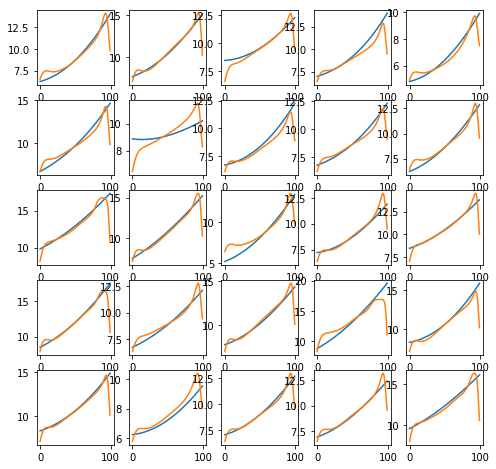

In [71]:
auto_test.save('auto_test')
y1_results5 = auto_test.predict(np.atleast_3d(y1))
fig, axs = plt.subplots(5, 5, figsize=(8, 8))
axs.reshape(-1)
for i in range (0,5):
    for j in range(0,5):
        k = np.random.randint(0, y1_results5.shape[0])
        ax = axs[i,j]
        ax.plot(y2[k])
        ax.plot(y1_results5[k])

TypeError: cannot unpack non-iterable float object

In [98]:
x = np.linspace(0,1,100)

y1 = []
y2 = []
a = []
b = []
c = []
d = []
e = np.random.uniform(0,10)
f = np.random.uniform(0,10)
g = np.random.uniform(0,10)
for i in range(5000):

    a_ = np.random.normal(8, 1.5, 1)
    b_ = np.random.normal(2, 2, 1)
    c_ = np.random.normal(4, 1, 1)
    d_ = np.random.normal(0, 0.5, 1)

    y1_, y2_ = function_gen(x, a_, b_, c_, d_, e, f, g)
    
    y1.append(y1_)
    y2.append(y2_)
    a.append(a_)
    b.append(b_)
    c.append(c_)
    d.append(d_)

In [87]:
auto_test = rnn_auto(LSTM, 128, 1, 1, 10, 100)
auto_test.fit(np.atleast_3d(y1), np.atleast_3d(y2), epochs=3000, batch_size=2000)

Epoch 1/3000
5000/5000 [==============================] - 3s 623us/step - loss: 106.8083
Epoch 2/3000
5000/5000 [==============================] - 3s 530us/step - loss: 106.3990
Epoch 3/3000
5000/5000 [==============================] - 3s 539us/step - loss: 105.9867
Epoch 4/3000
5000/5000 [==============================] - 3s 525us/step - loss: 105.5718
Epoch 5/3000
5000/5000 [==============================] - 3s 517us/step - loss: 105.1501
Epoch 6/3000
5000/5000 [==============================] - 3s 533us/step - loss: 104.7219
Epoch 7/3000
5000/5000 [==============================] - 3s 523us/step - loss: 104.2863
Epoch 8/3000
5000/5000 [==============================] - 3s 526us/step - loss: 103.8400
Epoch 9/3000
5000/5000 [==============================] - 3s 521us/step - loss: 103.3807
Epoch 10/3000
5000/5000 [==============================] - 3s 540us/step - loss: 102.9092
Epoch 11/3000
5000/5000 [==============================] - 3s 531us/step - loss: 102.4270
Epoch 12/3000
5000/

Epoch 93/3000
5000/5000 [==============================] - 3s 522us/step - loss: 17.0523
Epoch 94/3000
5000/5000 [==============================] - 3s 520us/step - loss: 16.8145
Epoch 95/3000
5000/5000 [==============================] - 3s 517us/step - loss: 16.5880
Epoch 96/3000
5000/5000 [==============================] - 3s 526us/step - loss: 16.3681
Epoch 97/3000
5000/5000 [==============================] - 3s 510us/step - loss: 16.1614
Epoch 98/3000
5000/5000 [==============================] - 3s 539us/step - loss: 15.9656
Epoch 99/3000
5000/5000 [==============================] - 3s 511us/step - loss: 15.7771
Epoch 100/3000
5000/5000 [==============================] - 3s 533us/step - loss: 15.5990
Epoch 101/3000
5000/5000 [==============================] - 3s 513us/step - loss: 15.4265
Epoch 102/3000
5000/5000 [==============================] - 3s 512us/step - loss: 15.2637
Epoch 103/3000
5000/5000 [==============================] - 3s 522us/step - loss: 15.1045
Epoch 104/3000
50

5000/5000 [==============================] - 3s 513us/step - loss: 11.2764
Epoch 185/3000
5000/5000 [==============================] - 3s 513us/step - loss: 11.2673
Epoch 186/3000
5000/5000 [==============================] - 3s 511us/step - loss: 11.2581
Epoch 187/3000
5000/5000 [==============================] - 3s 519us/step - loss: 11.2486
Epoch 188/3000
5000/5000 [==============================] - 3s 526us/step - loss: 11.2398
Epoch 189/3000
5000/5000 [==============================] - 3s 523us/step - loss: 11.2305
Epoch 190/3000
5000/5000 [==============================] - 3s 519us/step - loss: 11.2223
Epoch 191/3000
5000/5000 [==============================] - 3s 531us/step - loss: 11.2149
Epoch 192/3000
5000/5000 [==============================] - 3s 519us/step - loss: 11.2077
Epoch 193/3000
5000/5000 [==============================] - 3s 525us/step - loss: 11.2012
Epoch 194/3000
5000/5000 [==============================] - 3s 516us/step - loss: 11.1943
Epoch 195/3000
5000/5000 

5000/5000 [==============================] - 3s 527us/step - loss: 10.4349
Epoch 276/3000
5000/5000 [==============================] - 3s 526us/step - loss: 10.4174
Epoch 277/3000
5000/5000 [==============================] - 3s 520us/step - loss: 10.3958
Epoch 278/3000
5000/5000 [==============================] - 3s 518us/step - loss: 10.3674
Epoch 279/3000
5000/5000 [==============================] - 3s 519us/step - loss: 10.3495
Epoch 280/3000
5000/5000 [==============================] - 3s 530us/step - loss: 10.3238
Epoch 281/3000
5000/5000 [==============================] - 3s 511us/step - loss: 10.2938
Epoch 282/3000
5000/5000 [==============================] - 3s 518us/step - loss: 10.2747
Epoch 283/3000
5000/5000 [==============================] - 3s 507us/step - loss: 10.2537
Epoch 284/3000
5000/5000 [==============================] - 3s 516us/step - loss: 10.2261
Epoch 285/3000
5000/5000 [==============================] - 3s 526us/step - loss: 10.2082
Epoch 286/3000
5000/5000 

Epoch 367/3000
5000/5000 [==============================] - 3s 513us/step - loss: 8.5115
Epoch 368/3000
5000/5000 [==============================] - 3s 512us/step - loss: 8.4956
Epoch 369/3000
5000/5000 [==============================] - 3s 512us/step - loss: 8.4816
Epoch 370/3000
5000/5000 [==============================] - 3s 518us/step - loss: 8.4598
Epoch 371/3000
5000/5000 [==============================] - 3s 518us/step - loss: 8.4402
Epoch 372/3000
5000/5000 [==============================] - 3s 508us/step - loss: 8.4240
Epoch 373/3000
5000/5000 [==============================] - 3s 539us/step - loss: 8.4085
Epoch 374/3000
5000/5000 [==============================] - 3s 530us/step - loss: 8.3830
Epoch 375/3000
5000/5000 [==============================] - 3s 513us/step - loss: 8.3682
Epoch 376/3000
5000/5000 [==============================] - 3s 512us/step - loss: 8.3552
Epoch 377/3000
5000/5000 [==============================] - 3s 512us/step - loss: 8.3290
Epoch 378/3000
5000/5

5000/5000 [==============================] - 3s 508us/step - loss: 7.1597
Epoch 460/3000
5000/5000 [==============================] - 3s 506us/step - loss: 7.1515
Epoch 461/3000
5000/5000 [==============================] - 3s 521us/step - loss: 7.1474
Epoch 462/3000
5000/5000 [==============================] - 3s 516us/step - loss: 7.1489
Epoch 463/3000
5000/5000 [==============================] - 3s 520us/step - loss: 7.1305
Epoch 464/3000
5000/5000 [==============================] - 3s 516us/step - loss: 7.1245
Epoch 465/3000
5000/5000 [==============================] - 3s 518us/step - loss: 7.1195
Epoch 466/3000
5000/5000 [==============================] - 3s 535us/step - loss: 7.1115
Epoch 467/3000
5000/5000 [==============================] - 3s 524us/step - loss: 7.1060
Epoch 468/3000
5000/5000 [==============================] - 3s 513us/step - loss: 7.0996
Epoch 469/3000
5000/5000 [==============================] - 3s 517us/step - loss: 7.0898
Epoch 470/3000
5000/5000 [==========

5000/5000 [==============================] - 3s 513us/step - loss: 6.6852
Epoch 552/3000
5000/5000 [==============================] - 3s 520us/step - loss: 6.6827
Epoch 553/3000
5000/5000 [==============================] - 3s 515us/step - loss: 6.6770
Epoch 554/3000
5000/5000 [==============================] - 3s 514us/step - loss: 6.6702
Epoch 555/3000
5000/5000 [==============================] - 3s 515us/step - loss: 6.6739
Epoch 556/3000
5000/5000 [==============================] - 3s 523us/step - loss: 6.6578
Epoch 557/3000
5000/5000 [==============================] - 3s 523us/step - loss: 6.6519
Epoch 558/3000
5000/5000 [==============================] - 3s 519us/step - loss: 6.6530
Epoch 559/3000
5000/5000 [==============================] - 3s 538us/step - loss: 6.6447
Epoch 560/3000
5000/5000 [==============================] - 3s 527us/step - loss: 6.6391
Epoch 561/3000
5000/5000 [==============================] - 3s 514us/step - loss: 6.6327
Epoch 562/3000
5000/5000 [==========

5000/5000 [==============================] - 3s 511us/step - loss: 6.3546
Epoch 644/3000
5000/5000 [==============================] - 3s 515us/step - loss: 6.3535
Epoch 645/3000
5000/5000 [==============================] - 3s 520us/step - loss: 6.3495
Epoch 646/3000
5000/5000 [==============================] - 3s 528us/step - loss: 6.3452
Epoch 647/3000
5000/5000 [==============================] - 3s 513us/step - loss: 6.3433
Epoch 648/3000
5000/5000 [==============================] - 3s 517us/step - loss: 6.3407
Epoch 649/3000
5000/5000 [==============================] - 3s 520us/step - loss: 6.3381
Epoch 650/3000
5000/5000 [==============================] - 3s 514us/step - loss: 6.3408
Epoch 651/3000
5000/5000 [==============================] - 3s 512us/step - loss: 6.3314
Epoch 652/3000
5000/5000 [==============================] - 3s 529us/step - loss: 6.3321
Epoch 653/3000
5000/5000 [==============================] - 3s 519us/step - loss: 6.3271
Epoch 654/3000
5000/5000 [==========

5000/5000 [==============================] - 3s 517us/step - loss: 6.1536
Epoch 736/3000
5000/5000 [==============================] - 3s 513us/step - loss: 6.1514
Epoch 737/3000
5000/5000 [==============================] - 3s 518us/step - loss: 6.1428
Epoch 738/3000
5000/5000 [==============================] - 3s 506us/step - loss: 6.1449
Epoch 739/3000
5000/5000 [==============================] - 3s 521us/step - loss: 6.1384
Epoch 740/3000
5000/5000 [==============================] - 3s 512us/step - loss: 6.1386
Epoch 741/3000
5000/5000 [==============================] - 3s 519us/step - loss: 6.1335
Epoch 742/3000
5000/5000 [==============================] - 3s 512us/step - loss: 6.1332
Epoch 743/3000
5000/5000 [==============================] - 3s 509us/step - loss: 6.1358
Epoch 744/3000
5000/5000 [==============================] - 3s 532us/step - loss: 6.1267
Epoch 745/3000
5000/5000 [==============================] - 3s 526us/step - loss: 6.1265
Epoch 746/3000
5000/5000 [==========

5000/5000 [==============================] - 3s 510us/step - loss: 5.9839
Epoch 828/3000
5000/5000 [==============================] - 3s 514us/step - loss: 5.9766
Epoch 829/3000
5000/5000 [==============================] - 3s 522us/step - loss: 5.9721
Epoch 830/3000
5000/5000 [==============================] - 3s 517us/step - loss: 5.9769
Epoch 831/3000
5000/5000 [==============================] - 3s 509us/step - loss: 5.9705
Epoch 832/3000
5000/5000 [==============================] - 3s 518us/step - loss: 5.9711
Epoch 833/3000
5000/5000 [==============================] - 3s 514us/step - loss: 5.9777
Epoch 834/3000
5000/5000 [==============================] - 3s 524us/step - loss: 5.9964
Epoch 835/3000
5000/5000 [==============================] - 3s 516us/step - loss: 5.9787
Epoch 836/3000
5000/5000 [==============================] - 3s 522us/step - loss: 5.9754
Epoch 837/3000
5000/5000 [==============================] - 3s 520us/step - loss: 5.9837
Epoch 838/3000
5000/5000 [==========

5000/5000 [==============================] - 3s 525us/step - loss: 5.8732
Epoch 920/3000
5000/5000 [==============================] - 3s 525us/step - loss: 5.8566
Epoch 921/3000
5000/5000 [==============================] - 3s 511us/step - loss: 5.8613
Epoch 922/3000
5000/5000 [==============================] - 3s 511us/step - loss: 5.8582
Epoch 923/3000
5000/5000 [==============================] - 3s 525us/step - loss: 5.8567
Epoch 924/3000
5000/5000 [==============================] - 3s 507us/step - loss: 5.8539
Epoch 925/3000
5000/5000 [==============================] - 3s 527us/step - loss: 5.8544
Epoch 926/3000
5000/5000 [==============================] - 3s 514us/step - loss: 5.8500
Epoch 927/3000
5000/5000 [==============================] - 3s 512us/step - loss: 5.8514
Epoch 928/3000
5000/5000 [==============================] - 3s 513us/step - loss: 5.8493
Epoch 929/3000
5000/5000 [==============================] - 3s 524us/step - loss: 5.8486
Epoch 930/3000
5000/5000 [==========

5000/5000 [==============================] - 3s 522us/step - loss: 5.7565
Epoch 1012/3000
5000/5000 [==============================] - 3s 519us/step - loss: 5.7608
Epoch 1013/3000
5000/5000 [==============================] - 3s 530us/step - loss: 5.7535
Epoch 1014/3000
5000/5000 [==============================] - 3s 518us/step - loss: 5.7568
Epoch 1015/3000
5000/5000 [==============================] - 3s 515us/step - loss: 5.7526
Epoch 1016/3000
5000/5000 [==============================] - 3s 523us/step - loss: 5.7522
Epoch 1017/3000
5000/5000 [==============================] - 3s 514us/step - loss: 5.7593
Epoch 1018/3000
5000/5000 [==============================] - 3s 518us/step - loss: 5.7615
Epoch 1019/3000
5000/5000 [==============================] - 3s 514us/step - loss: 5.7499
Epoch 1020/3000
5000/5000 [==============================] - 3s 509us/step - loss: 5.7574
Epoch 1021/3000
5000/5000 [==============================] - 3s 515us/step - loss: 5.7471
Epoch 1022/3000
5000/5000 

5000/5000 [==============================] - 3s 510us/step - loss: 5.6714
Epoch 1103/3000
5000/5000 [==============================] - 3s 519us/step - loss: 5.6729
Epoch 1104/3000
5000/5000 [==============================] - 3s 522us/step - loss: 5.6685
Epoch 1105/3000
5000/5000 [==============================] - 3s 507us/step - loss: 5.6693
Epoch 1106/3000
5000/5000 [==============================] - 3s 510us/step - loss: 5.6692
Epoch 1107/3000
5000/5000 [==============================] - 3s 522us/step - loss: 5.6684
Epoch 1108/3000
5000/5000 [==============================] - 3s 506us/step - loss: 5.6664
Epoch 1109/3000
5000/5000 [==============================] - 3s 514us/step - loss: 5.6651
Epoch 1110/3000
5000/5000 [==============================] - 3s 512us/step - loss: 5.6678
Epoch 1111/3000
5000/5000 [==============================] - 3s 510us/step - loss: 5.6684
Epoch 1112/3000
5000/5000 [==============================] - 3s 515us/step - loss: 5.6640
Epoch 1113/3000
5000/5000 

5000/5000 [==============================] - 3s 517us/step - loss: 5.6207
Epoch 1194/3000
5000/5000 [==============================] - 3s 512us/step - loss: 5.6028
Epoch 1195/3000
5000/5000 [==============================] - 3s 521us/step - loss: 5.6038
Epoch 1196/3000
5000/5000 [==============================] - 3s 520us/step - loss: 5.6097
Epoch 1197/3000
5000/5000 [==============================] - 3s 511us/step - loss: 5.6042
Epoch 1198/3000
5000/5000 [==============================] - 3s 509us/step - loss: 5.6006
Epoch 1199/3000
5000/5000 [==============================] - 3s 518us/step - loss: 5.6024
Epoch 1200/3000
5000/5000 [==============================] - 3s 510us/step - loss: 5.6025
Epoch 1201/3000
5000/5000 [==============================] - 3s 537us/step - loss: 5.5979
Epoch 1202/3000
5000/5000 [==============================] - 3s 516us/step - loss: 5.5990
Epoch 1203/3000
5000/5000 [==============================] - 3s 522us/step - loss: 5.6104
Epoch 1204/3000
5000/5000 

5000/5000 [==============================] - 3s 523us/step - loss: 5.5361
Epoch 1285/3000
5000/5000 [==============================] - 3s 525us/step - loss: 5.5366
Epoch 1286/3000
5000/5000 [==============================] - 3s 520us/step - loss: 5.5362
Epoch 1287/3000
5000/5000 [==============================] - 3s 520us/step - loss: 5.5344
Epoch 1288/3000
5000/5000 [==============================] - 3s 519us/step - loss: 5.5356
Epoch 1289/3000
5000/5000 [==============================] - 3s 523us/step - loss: 5.5326
Epoch 1290/3000
5000/5000 [==============================] - 3s 509us/step - loss: 5.5340
Epoch 1291/3000
5000/5000 [==============================] - 3s 512us/step - loss: 5.5321
Epoch 1292/3000
5000/5000 [==============================] - 3s 525us/step - loss: 5.5318
Epoch 1293/3000
5000/5000 [==============================] - 3s 510us/step - loss: 5.5300
Epoch 1294/3000
5000/5000 [==============================] - 3s 516us/step - loss: 5.5324
Epoch 1295/3000
5000/5000 

5000/5000 [==============================] - 3s 512us/step - loss: 5.4810
Epoch 1376/3000
5000/5000 [==============================] - 3s 508us/step - loss: 5.4815
Epoch 1377/3000
5000/5000 [==============================] - 3s 513us/step - loss: 5.4805
Epoch 1378/3000
5000/5000 [==============================] - 3s 515us/step - loss: 5.4807
Epoch 1379/3000
5000/5000 [==============================] - 3s 512us/step - loss: 5.4801
Epoch 1380/3000
5000/5000 [==============================] - 3s 519us/step - loss: 5.4789
Epoch 1381/3000
5000/5000 [==============================] - 3s 513us/step - loss: 5.4810
Epoch 1382/3000
5000/5000 [==============================] - 3s 524us/step - loss: 5.4772
Epoch 1383/3000
5000/5000 [==============================] - 3s 516us/step - loss: 5.4789
Epoch 1384/3000
5000/5000 [==============================] - 3s 523us/step - loss: 5.4782
Epoch 1385/3000
5000/5000 [==============================] - 3s 516us/step - loss: 5.4786
Epoch 1386/3000
5000/5000 

5000/5000 [==============================] - 3s 519us/step - loss: 5.4389
Epoch 1467/3000
5000/5000 [==============================] - 3s 523us/step - loss: 5.4425
Epoch 1468/3000
5000/5000 [==============================] - 3s 528us/step - loss: 5.4363
Epoch 1469/3000
5000/5000 [==============================] - 3s 520us/step - loss: 5.4373
Epoch 1470/3000
5000/5000 [==============================] - 3s 515us/step - loss: 5.4349
Epoch 1471/3000
5000/5000 [==============================] - 3s 517us/step - loss: 5.4345
Epoch 1472/3000
5000/5000 [==============================] - 3s 517us/step - loss: 5.4343
Epoch 1473/3000
5000/5000 [==============================] - 3s 514us/step - loss: 5.4364
Epoch 1474/3000
5000/5000 [==============================] - 3s 518us/step - loss: 5.4354
Epoch 1475/3000
5000/5000 [==============================] - 3s 517us/step - loss: 5.4337
Epoch 1476/3000
5000/5000 [==============================] - 3s 521us/step - loss: 5.4332
Epoch 1477/3000
5000/5000 

5000/5000 [==============================] - 3s 525us/step - loss: 5.4079
Epoch 1558/3000
5000/5000 [==============================] - 3s 520us/step - loss: 5.3990
Epoch 1559/3000
5000/5000 [==============================] - 3s 517us/step - loss: 5.3994
Epoch 1560/3000
5000/5000 [==============================] - 3s 522us/step - loss: 5.4043
Epoch 1561/3000
5000/5000 [==============================] - 3s 522us/step - loss: 5.4042
Epoch 1562/3000
5000/5000 [==============================] - 3s 515us/step - loss: 5.4022
Epoch 1563/3000
5000/5000 [==============================] - 3s 520us/step - loss: 5.4010
Epoch 1564/3000
5000/5000 [==============================] - 3s 522us/step - loss: 5.4013
Epoch 1565/3000
5000/5000 [==============================] - 3s 509us/step - loss: 5.3962
Epoch 1566/3000
5000/5000 [==============================] - 3s 512us/step - loss: 5.3943
Epoch 1567/3000
5000/5000 [==============================] - 3s 505us/step - loss: 5.3966
Epoch 1568/3000
5000/5000 

5000/5000 [==============================] - 3s 521us/step - loss: 5.3612
Epoch 1649/3000
5000/5000 [==============================] - 3s 520us/step - loss: 5.3651
Epoch 1650/3000
5000/5000 [==============================] - 3s 531us/step - loss: 5.3638
Epoch 1651/3000
5000/5000 [==============================] - 3s 518us/step - loss: 5.3605
Epoch 1652/3000
5000/5000 [==============================] - 3s 540us/step - loss: 5.3611
Epoch 1653/3000
5000/5000 [==============================] - 3s 524us/step - loss: 5.3607
Epoch 1654/3000
5000/5000 [==============================] - 3s 516us/step - loss: 5.3632
Epoch 1655/3000
5000/5000 [==============================] - 3s 518us/step - loss: 5.3613
Epoch 1656/3000
5000/5000 [==============================] - 3s 512us/step - loss: 5.3623
Epoch 1657/3000
5000/5000 [==============================] - 3s 520us/step - loss: 5.3599
Epoch 1658/3000
5000/5000 [==============================] - 3s 523us/step - loss: 5.3597
Epoch 1659/3000
5000/5000 

5000/5000 [==============================] - 3s 516us/step - loss: 5.3282
Epoch 1740/3000
5000/5000 [==============================] - 3s 516us/step - loss: 5.3246
Epoch 1741/3000
5000/5000 [==============================] - 3s 516us/step - loss: 5.3255
Epoch 1742/3000
5000/5000 [==============================] - 3s 526us/step - loss: 5.3250
Epoch 1743/3000
5000/5000 [==============================] - 3s 519us/step - loss: 5.3232
Epoch 1744/3000
5000/5000 [==============================] - 3s 518us/step - loss: 5.3255
Epoch 1745/3000
5000/5000 [==============================] - 3s 525us/step - loss: 5.3252
Epoch 1746/3000
5000/5000 [==============================] - 3s 508us/step - loss: 5.3234
Epoch 1747/3000
5000/5000 [==============================] - 3s 507us/step - loss: 5.3241
Epoch 1748/3000
5000/5000 [==============================] - 3s 514us/step - loss: 5.3239
Epoch 1749/3000
5000/5000 [==============================] - 3s 515us/step - loss: 5.3243
Epoch 1750/3000
5000/5000 

5000/5000 [==============================] - 3s 512us/step - loss: 5.2921
Epoch 1831/3000
5000/5000 [==============================] - 3s 520us/step - loss: 5.2900
Epoch 1832/3000
5000/5000 [==============================] - 3s 514us/step - loss: 5.2861
Epoch 1833/3000
5000/5000 [==============================] - 3s 512us/step - loss: 5.2877
Epoch 1834/3000
5000/5000 [==============================] - 3s 532us/step - loss: 5.2866
Epoch 1835/3000
5000/5000 [==============================] - 3s 523us/step - loss: 5.2856
Epoch 1836/3000
5000/5000 [==============================] - 3s 516us/step - loss: 5.2859
Epoch 1837/3000
5000/5000 [==============================] - 3s 540us/step - loss: 5.2865
Epoch 1838/3000
5000/5000 [==============================] - 3s 511us/step - loss: 5.2881
Epoch 1839/3000
5000/5000 [==============================] - 3s 509us/step - loss: 5.2837
Epoch 1840/3000
5000/5000 [==============================] - 3s 514us/step - loss: 5.2855
Epoch 1841/3000
5000/5000 

5000/5000 [==============================] - 3s 519us/step - loss: 5.2559
Epoch 1922/3000
5000/5000 [==============================] - 3s 517us/step - loss: 5.2516
Epoch 1923/3000
5000/5000 [==============================] - 3s 508us/step - loss: 5.2549
Epoch 1924/3000
5000/5000 [==============================] - 3s 516us/step - loss: 5.2572
Epoch 1925/3000
5000/5000 [==============================] - 3s 512us/step - loss: 5.2522
Epoch 1926/3000
5000/5000 [==============================] - 3s 527us/step - loss: 5.2513
Epoch 1927/3000
5000/5000 [==============================] - 3s 531us/step - loss: 5.2536
Epoch 1928/3000
5000/5000 [==============================] - 3s 538us/step - loss: 5.2538
Epoch 1929/3000
5000/5000 [==============================] - 3s 520us/step - loss: 5.2530
Epoch 1930/3000
5000/5000 [==============================] - 3s 525us/step - loss: 5.2497
Epoch 1931/3000
5000/5000 [==============================] - 3s 520us/step - loss: 5.2518
Epoch 1932/3000
5000/5000 

5000/5000 [==============================] - 3s 520us/step - loss: 5.2215
Epoch 2013/3000
5000/5000 [==============================] - 3s 523us/step - loss: 5.2221
Epoch 2014/3000
5000/5000 [==============================] - 3s 528us/step - loss: 5.2239
Epoch 2015/3000
5000/5000 [==============================] - 3s 525us/step - loss: 5.2232
Epoch 2016/3000
5000/5000 [==============================] - 3s 509us/step - loss: 5.2204
Epoch 2017/3000
5000/5000 [==============================] - 3s 515us/step - loss: 5.2243
Epoch 2018/3000
5000/5000 [==============================] - 3s 518us/step - loss: 5.2246
Epoch 2019/3000
5000/5000 [==============================] - 3s 525us/step - loss: 5.2206
Epoch 2020/3000
5000/5000 [==============================] - 3s 535us/step - loss: 5.2252
Epoch 2021/3000
5000/5000 [==============================] - 3s 512us/step - loss: 5.2243
Epoch 2022/3000
5000/5000 [==============================] - 3s 518us/step - loss: 5.2228
Epoch 2023/3000
5000/5000 

5000/5000 [==============================] - 3s 515us/step - loss: 5.2013
Epoch 2104/3000
5000/5000 [==============================] - 3s 515us/step - loss: 5.1989
Epoch 2105/3000
5000/5000 [==============================] - 3s 516us/step - loss: 5.1981
Epoch 2106/3000
5000/5000 [==============================] - 3s 519us/step - loss: 5.2006
Epoch 2107/3000
5000/5000 [==============================] - 3s 517us/step - loss: 5.1953
Epoch 2108/3000
5000/5000 [==============================] - 3s 512us/step - loss: 5.1976
Epoch 2109/3000
5000/5000 [==============================] - 3s 522us/step - loss: 5.1926
Epoch 2110/3000
5000/5000 [==============================] - 3s 514us/step - loss: 5.1963
Epoch 2111/3000
5000/5000 [==============================] - 3s 522us/step - loss: 5.1926
Epoch 2112/3000
5000/5000 [==============================] - 3s 520us/step - loss: 5.1905
Epoch 2113/3000
5000/5000 [==============================] - 3s 521us/step - loss: 5.1922
Epoch 2114/3000
5000/5000 

5000/5000 [==============================] - 3s 512us/step - loss: 5.1694
Epoch 2195/3000
5000/5000 [==============================] - 3s 516us/step - loss: 5.1657
Epoch 2196/3000
5000/5000 [==============================] - 3s 524us/step - loss: 5.1661
Epoch 2197/3000
5000/5000 [==============================] - 3s 516us/step - loss: 5.1641
Epoch 2198/3000
5000/5000 [==============================] - 3s 521us/step - loss: 5.1637
Epoch 2199/3000
5000/5000 [==============================] - 3s 515us/step - loss: 5.1638
Epoch 2200/3000
5000/5000 [==============================] - 3s 517us/step - loss: 5.1622
Epoch 2201/3000
5000/5000 [==============================] - 3s 522us/step - loss: 5.1631
Epoch 2202/3000
5000/5000 [==============================] - 3s 525us/step - loss: 5.1631
Epoch 2203/3000
5000/5000 [==============================] - 3s 521us/step - loss: 5.1594
Epoch 2204/3000
5000/5000 [==============================] - 3s 527us/step - loss: 5.1623
Epoch 2205/3000
5000/5000 

5000/5000 [==============================] - 3s 515us/step - loss: 5.1395
Epoch 2286/3000
5000/5000 [==============================] - 3s 512us/step - loss: 5.1375
Epoch 2287/3000
5000/5000 [==============================] - 3s 520us/step - loss: 5.1371
Epoch 2288/3000
5000/5000 [==============================] - 3s 519us/step - loss: 5.1359
Epoch 2289/3000
5000/5000 [==============================] - 3s 521us/step - loss: 5.1369
Epoch 2290/3000
5000/5000 [==============================] - 3s 509us/step - loss: 5.1344
Epoch 2291/3000
5000/5000 [==============================] - 3s 522us/step - loss: 5.1365
Epoch 2292/3000
5000/5000 [==============================] - 3s 518us/step - loss: 5.1384
Epoch 2293/3000
5000/5000 [==============================] - 3s 512us/step - loss: 5.1373
Epoch 2294/3000
5000/5000 [==============================] - 3s 535us/step - loss: 5.1363
Epoch 2295/3000
5000/5000 [==============================] - 3s 522us/step - loss: 5.1364
Epoch 2296/3000
5000/5000 

5000/5000 [==============================] - 3s 510us/step - loss: 5.1169
Epoch 2377/3000
5000/5000 [==============================] - 3s 514us/step - loss: 5.1163
Epoch 2378/3000
5000/5000 [==============================] - 3s 517us/step - loss: 5.1130
Epoch 2379/3000
5000/5000 [==============================] - 3s 515us/step - loss: 5.1173
Epoch 2380/3000
5000/5000 [==============================] - 3s 520us/step - loss: 5.1156
Epoch 2381/3000
5000/5000 [==============================] - 3s 509us/step - loss: 5.1145
Epoch 2382/3000
5000/5000 [==============================] - 3s 525us/step - loss: 5.1162
Epoch 2383/3000
5000/5000 [==============================] - 3s 516us/step - loss: 5.1094
Epoch 2384/3000
5000/5000 [==============================] - 3s 508us/step - loss: 5.1113
Epoch 2385/3000
5000/5000 [==============================] - 3s 513us/step - loss: 5.1093
Epoch 2386/3000
5000/5000 [==============================] - 3s 521us/step - loss: 5.1105
Epoch 2387/3000
5000/5000 

5000/5000 [==============================] - 3s 511us/step - loss: 5.0888
Epoch 2468/3000
5000/5000 [==============================] - 3s 519us/step - loss: 5.0893
Epoch 2469/3000
5000/5000 [==============================] - 3s 532us/step - loss: 5.0881
Epoch 2470/3000
5000/5000 [==============================] - 3s 520us/step - loss: 5.0873
Epoch 2471/3000
5000/5000 [==============================] - 3s 514us/step - loss: 5.0896
Epoch 2472/3000
5000/5000 [==============================] - 3s 515us/step - loss: 5.0894
Epoch 2473/3000
5000/5000 [==============================] - 3s 519us/step - loss: 5.0866
Epoch 2474/3000
5000/5000 [==============================] - 3s 516us/step - loss: 5.0886
Epoch 2475/3000
5000/5000 [==============================] - 3s 520us/step - loss: 5.0885
Epoch 2476/3000
5000/5000 [==============================] - 3s 514us/step - loss: 5.0861
Epoch 2477/3000
5000/5000 [==============================] - 3s 506us/step - loss: 5.0883
Epoch 2478/3000
5000/5000 

5000/5000 [==============================] - 3s 517us/step - loss: 5.0691
Epoch 2559/3000
5000/5000 [==============================] - 3s 524us/step - loss: 5.0708
Epoch 2560/3000
5000/5000 [==============================] - 3s 514us/step - loss: 5.0720
Epoch 2561/3000
5000/5000 [==============================] - 3s 514us/step - loss: 5.0738
Epoch 2562/3000
5000/5000 [==============================] - 3s 522us/step - loss: 5.0693
Epoch 2563/3000
5000/5000 [==============================] - 3s 518us/step - loss: 5.0701
Epoch 2564/3000
5000/5000 [==============================] - 3s 522us/step - loss: 5.0771
Epoch 2565/3000
5000/5000 [==============================] - 3s 513us/step - loss: 5.0634
Epoch 2566/3000
5000/5000 [==============================] - 3s 505us/step - loss: 5.0705
Epoch 2567/3000
5000/5000 [==============================] - 3s 520us/step - loss: 5.0688
Epoch 2568/3000
5000/5000 [==============================] - 3s 522us/step - loss: 5.0678
Epoch 2569/3000
5000/5000 

5000/5000 [==============================] - 3s 527us/step - loss: 5.0433
Epoch 2650/3000
5000/5000 [==============================] - 3s 509us/step - loss: 5.0448
Epoch 2651/3000
5000/5000 [==============================] - 3s 515us/step - loss: 5.0457
Epoch 2652/3000
5000/5000 [==============================] - 3s 522us/step - loss: 5.0437
Epoch 2653/3000
5000/5000 [==============================] - 3s 525us/step - loss: 5.0434
Epoch 2654/3000
5000/5000 [==============================] - 3s 531us/step - loss: 5.0440
Epoch 2655/3000
5000/5000 [==============================] - 3s 510us/step - loss: 5.0424
Epoch 2656/3000
5000/5000 [==============================] - 3s 509us/step - loss: 5.0424
Epoch 2657/3000
5000/5000 [==============================] - 3s 522us/step - loss: 5.0421
Epoch 2658/3000
5000/5000 [==============================] - 3s 512us/step - loss: 5.0425
Epoch 2659/3000
5000/5000 [==============================] - 3s 514us/step - loss: 5.0421
Epoch 2660/3000
5000/5000 

5000/5000 [==============================] - 3s 523us/step - loss: 5.0239
Epoch 2741/3000
5000/5000 [==============================] - 3s 509us/step - loss: 5.0258
Epoch 2742/3000
5000/5000 [==============================] - 3s 513us/step - loss: 5.0226
Epoch 2743/3000
5000/5000 [==============================] - 3s 514us/step - loss: 5.0243
Epoch 2744/3000
5000/5000 [==============================] - 3s 521us/step - loss: 5.0255
Epoch 2745/3000
5000/5000 [==============================] - 3s 519us/step - loss: 5.0279
Epoch 2746/3000
5000/5000 [==============================] - 3s 508us/step - loss: 5.0237
Epoch 2747/3000
5000/5000 [==============================] - 3s 520us/step - loss: 5.0286
Epoch 2748/3000
5000/5000 [==============================] - 3s 519us/step - loss: 5.0197
Epoch 2749/3000
5000/5000 [==============================] - 3s 516us/step - loss: 5.0295
Epoch 2750/3000
5000/5000 [==============================] - 3s 508us/step - loss: 5.0210
Epoch 2751/3000
5000/5000 

5000/5000 [==============================] - 3s 526us/step - loss: 5.0056
Epoch 2832/3000
5000/5000 [==============================] - 3s 518us/step - loss: 5.0024
Epoch 2833/3000
5000/5000 [==============================] - 3s 516us/step - loss: 5.0040
Epoch 2834/3000
5000/5000 [==============================] - 3s 520us/step - loss: 5.0017
Epoch 2835/3000
5000/5000 [==============================] - 3s 523us/step - loss: 5.0040
Epoch 2836/3000
5000/5000 [==============================] - 3s 511us/step - loss: 5.0011
Epoch 2837/3000
5000/5000 [==============================] - 3s 514us/step - loss: 5.0038
Epoch 2838/3000
5000/5000 [==============================] - 3s 515us/step - loss: 5.0018
Epoch 2839/3000
5000/5000 [==============================] - 3s 513us/step - loss: 5.0025
Epoch 2840/3000
5000/5000 [==============================] - 3s 524us/step - loss: 5.0024
Epoch 2841/3000
5000/5000 [==============================] - 3s 520us/step - loss: 5.0007
Epoch 2842/3000
5000/5000 

5000/5000 [==============================] - 3s 513us/step - loss: 4.9824
Epoch 2923/3000
5000/5000 [==============================] - 3s 523us/step - loss: 4.9826
Epoch 2924/3000
5000/5000 [==============================] - 3s 522us/step - loss: 4.9810
Epoch 2925/3000
5000/5000 [==============================] - 3s 519us/step - loss: 4.9813
Epoch 2926/3000
5000/5000 [==============================] - 3s 518us/step - loss: 4.9824
Epoch 2927/3000
5000/5000 [==============================] - 3s 521us/step - loss: 4.9838
Epoch 2928/3000
5000/5000 [==============================] - 3s 517us/step - loss: 4.9806
Epoch 2929/3000
5000/5000 [==============================] - 3s 524us/step - loss: 4.9809
Epoch 2930/3000
5000/5000 [==============================] - 3s 516us/step - loss: 4.9810
Epoch 2931/3000
5000/5000 [==============================] - 3s 522us/step - loss: 4.9805
Epoch 2932/3000
5000/5000 [==============================] - 3s 512us/step - loss: 4.9796
Epoch 2933/3000
5000/5000 

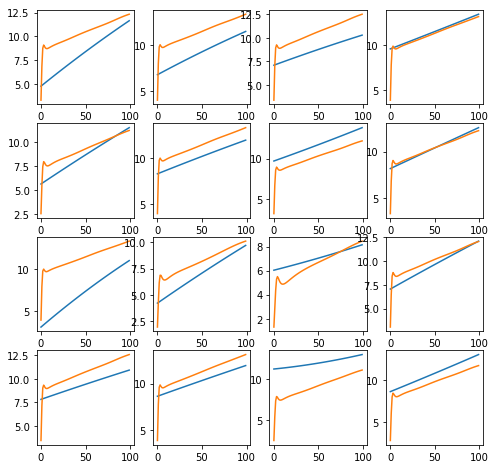

In [89]:
auto_test.save('auto_test')
y1_results6 = auto_test.predict(np.atleast_3d(y1))
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
axs.reshape(-1)
for i in range (0,4):
    for j in range(0,4):
        k = np.random.randint(0, y1_results6.shape[0])
        ax = axs[i,j]
        ax.plot(y2[k])
        ax.plot(y1_results6[k])

In [103]:
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
for i in range (0,4):
    for j in range(0,4):
        k = np.random.randint(0, y1_results6.shape[0])
        ax = axs[i,j]
        ax.plot(y1[k],'r-')
        ax.plot(y2[k],'b-')

In [104]:
x = np.linspace(0,10,100)

y1 = []
y2 = []
a = []
b = []
c = []
d = []
e = np.random.uniform(0,1)
f = np.random.uniform(0,1)
g = np.random.uniform(0,1)
for i in range(5000):

    a_ = np.random.normal(8, 1.5, 1)
    b_ = np.random.normal(2, 2, 1)
    c_ = np.random.normal(4, 1, 1)
    d_ = np.random.normal(0, 0.5, 1)

    y1_, y2_ = function_gen(x, a_, b_, c_, d_, e, f, g)
    
    y1.append(y1_)
    y2.append(y2_)
    a.append(a_)
    b.append(b_)
    c.append(c_)
    d.append(d_)

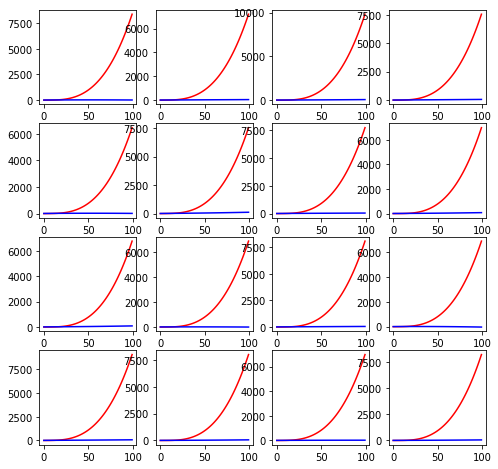

In [108]:
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
for i in range (0,4):
    for j in range(0,4):
        k = np.random.randint(0, y1_results6.shape[0])
        ax = axs[i,j]
        ax.plot(y1[k],'r-')
        ax.plot(y2[k],'b-')

In [106]:
auto_test = rnn_auto(LSTM, 128, 2, 2, 10, 100)
auto_test.fit(np.atleast_3d(y1), np.atleast_3d(y2), epochs=5000, batch_size=2000)

Epoch 1/5000
5000/5000 [==============================] - 7s 1ms/step - loss: 1244.3020
Epoch 2/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 1243.1825
Epoch 3/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 1242.1068
Epoch 4/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 1240.9774
Epoch 5/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 1239.7358
Epoch 6/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 1238.3136
Epoch 7/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 1236.6702
Epoch 8/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 1234.7465
Epoch 9/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 1232.5017
Epoch 10/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 1229.8878
Epoch 11/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 1226.8444
Epoch 12/5000
5000/5000 [=====

5000/5000 [==============================] - 6s 1ms/step - loss: 744.1109
Epoch 94/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 742.4283
Epoch 95/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 740.7904
Epoch 96/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 739.1802
Epoch 97/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 737.6072
Epoch 98/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 736.0688
Epoch 99/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 734.5459
Epoch 100/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 733.0660
Epoch 101/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 731.6113
Epoch 102/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 730.1807
Epoch 103/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 728.7762
Epoch 104/5000
5000/5000 [================

5000/5000 [==============================] - 6s 1ms/step - loss: 663.1030
Epoch 186/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 662.6068
Epoch 187/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 662.1168
Epoch 188/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 661.6261
Epoch 189/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 661.1403
Epoch 190/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 660.6557
Epoch 191/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 660.1776
Epoch 192/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 659.6976
Epoch 193/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 659.2165
Epoch 194/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 658.7449
Epoch 195/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 658.2680
Epoch 196/5000
5000/5000 [==========

5000/5000 [==============================] - 6s 1ms/step - loss: 624.9917
Epoch 278/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 624.6645
Epoch 279/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 624.3354
Epoch 280/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 624.0083
Epoch 281/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 623.6836
Epoch 282/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 623.3567
Epoch 283/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 623.0354
Epoch 284/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 622.7108
Epoch 285/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 622.3903
Epoch 286/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 622.0706
Epoch 287/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 621.7508
Epoch 288/5000
5000/5000 [==========

5000/5000 [==============================] - 6s 1ms/step - loss: 597.9972
Epoch 370/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 597.7289
Epoch 371/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 597.4567
Epoch 372/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 597.1845
Epoch 373/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 596.9149
Epoch 374/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 596.6416
Epoch 375/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 596.3684
Epoch 376/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 596.0978
Epoch 377/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 595.8252
Epoch 378/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 595.5506
Epoch 379/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 595.2781
Epoch 380/5000
5000/5000 [==========

5000/5000 [==============================] - 6s 1ms/step - loss: 574.2711
Epoch 462/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 574.0335
Epoch 463/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 573.7941
Epoch 464/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 573.5564
Epoch 465/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 573.3182
Epoch 466/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 573.0798
Epoch 467/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 572.8430
Epoch 468/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 572.6057
Epoch 469/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 572.3679
Epoch 470/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 572.1301
Epoch 471/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 571.8933
Epoch 472/5000
5000/5000 [==========

5000/5000 [==============================] - 6s 1ms/step - loss: 553.2919
Epoch 554/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 553.0765
Epoch 555/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 552.8629
Epoch 556/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 552.6483
Epoch 557/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 552.4343
Epoch 558/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 552.2188
Epoch 559/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 552.0060
Epoch 560/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 551.7911
Epoch 561/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 551.5753
Epoch 562/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 551.3616
Epoch 563/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 551.1496
Epoch 564/5000
5000/5000 [==========

5000/5000 [==============================] - 6s 1ms/step - loss: 534.3659
Epoch 646/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 534.1569
Epoch 647/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 533.9567
Epoch 648/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 533.7513
Epoch 649/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 533.5530
Epoch 650/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 533.3478
Epoch 651/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 533.1441
Epoch 652/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 532.9387
Epoch 653/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 532.7403
Epoch 654/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 532.5340
Epoch 655/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 532.3407
Epoch 656/5000
5000/5000 [==========

5000/5000 [==============================] - 6s 1ms/step - loss: 516.6330
Epoch 738/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 516.4339
Epoch 739/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 516.2281
Epoch 740/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 516.0234
Epoch 741/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 515.8091
Epoch 742/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 515.5972
Epoch 743/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 515.3736
Epoch 744/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 515.1489
Epoch 745/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 514.9189
Epoch 746/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 514.6886
Epoch 747/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 514.4573
Epoch 748/5000
5000/5000 [==========

5000/5000 [==============================] - 6s 1ms/step - loss: 499.1049
Epoch 830/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 499.3223
Epoch 831/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 498.8759
Epoch 832/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 498.6796
Epoch 833/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 498.5676
Epoch 834/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 498.3253
Epoch 835/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 498.0919
Epoch 836/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 497.8946
Epoch 837/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 497.7448
Epoch 838/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 497.5305
Epoch 839/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 497.4086
Epoch 840/5000
5000/5000 [==========

5000/5000 [==============================] - 6s 1ms/step - loss: 485.0588
Epoch 922/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 484.8573
Epoch 923/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 484.4533
Epoch 924/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 484.2580
Epoch 925/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 483.8556
Epoch 926/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 483.6720
Epoch 927/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 483.3372
Epoch 928/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 483.1247
Epoch 929/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 482.9195
Epoch 930/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 482.5956
Epoch 931/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 482.3564
Epoch 932/5000
5000/5000 [==========

5000/5000 [==============================] - 6s 1ms/step - loss: 471.6558
Epoch 1014/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 471.5094
Epoch 1015/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 471.3647
Epoch 1016/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 471.2200
Epoch 1017/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 471.0744
Epoch 1018/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 470.9301
Epoch 1019/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 470.7853
Epoch 1020/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 470.6424
Epoch 1021/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 470.4974
Epoch 1022/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 470.3553
Epoch 1023/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 470.2095
Epoch 1024/5000
5000/5000 

5000/5000 [==============================] - 6s 1ms/step - loss: 458.0790
Epoch 1105/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 457.8292
Epoch 1106/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 457.7508
Epoch 1107/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 457.5460
Epoch 1108/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 457.3762
Epoch 1109/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 457.2095
Epoch 1110/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 456.9525
Epoch 1111/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 456.7972
Epoch 1112/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 456.6286
Epoch 1113/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 456.4266
Epoch 1114/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 456.2509
Epoch 1115/5000
5000/5000 

5000/5000 [==============================] - 6s 1ms/step - loss: 431.4732
Epoch 1196/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 432.1244
Epoch 1197/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 429.2412
Epoch 1198/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 428.0236
Epoch 1199/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 425.7721
Epoch 1200/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 425.3341
Epoch 1201/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 425.3091
Epoch 1202/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 424.1202
Epoch 1203/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 425.8196
Epoch 1204/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 423.3786
Epoch 1205/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 424.9601
Epoch 1206/5000
5000/5000 

5000/5000 [==============================] - 6s 1ms/step - loss: 398.2372
Epoch 1287/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 397.9960
Epoch 1288/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 397.8723
Epoch 1289/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 397.2479
Epoch 1290/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 397.2397
Epoch 1291/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 396.8338
Epoch 1292/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 396.9514
Epoch 1293/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 396.2774
Epoch 1294/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 396.6744
Epoch 1295/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 398.9745
Epoch 1296/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 398.7905
Epoch 1297/5000
5000/5000 

5000/5000 [==============================] - 6s 1ms/step - loss: 374.1483
Epoch 1378/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 373.0061
Epoch 1379/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 372.7083
Epoch 1380/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 372.2619
Epoch 1381/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 371.9749
Epoch 1382/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 371.6776
Epoch 1383/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 371.7983
Epoch 1384/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 371.8586
Epoch 1385/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 370.7987
Epoch 1386/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 370.2649
Epoch 1387/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 370.5367
Epoch 1388/5000
5000/5000 

5000/5000 [==============================] - 6s 1ms/step - loss: 350.1489
Epoch 1469/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 349.7186
Epoch 1470/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 349.8346
Epoch 1471/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 350.6732
Epoch 1472/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 350.9685
Epoch 1473/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 349.8806
Epoch 1474/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 349.3695
Epoch 1475/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 349.4676
Epoch 1476/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 349.2389
Epoch 1477/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 350.6292
Epoch 1478/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 350.0146
Epoch 1479/5000
5000/5000 

5000/5000 [==============================] - 6s 1ms/step - loss: 332.4413
Epoch 1560/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 334.5120
Epoch 1561/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 332.4134
Epoch 1562/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 333.3900
Epoch 1563/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 332.0962
Epoch 1564/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 331.3574
Epoch 1565/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 330.6310
Epoch 1566/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 331.5195
Epoch 1567/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 330.8626
Epoch 1568/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 329.9702
Epoch 1569/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 330.0743
Epoch 1570/5000
5000/5000 

5000/5000 [==============================] - 6s 1ms/step - loss: 332.1425
Epoch 1651/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 326.3915
Epoch 1652/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 324.3944
Epoch 1653/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 323.3909
Epoch 1654/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 319.0831
Epoch 1655/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 317.9572
Epoch 1656/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 316.3032
Epoch 1657/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 315.3298
Epoch 1658/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 314.8908
Epoch 1659/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 313.7132
Epoch 1660/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 312.9651
Epoch 1661/5000
5000/5000 

5000/5000 [==============================] - 6s 1ms/step - loss: 298.3560
Epoch 1742/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 298.0174
Epoch 1743/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 297.7560
Epoch 1744/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 297.4275
Epoch 1745/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 297.2838
Epoch 1746/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 296.9419
Epoch 1747/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 296.7225
Epoch 1748/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 296.4783
Epoch 1749/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 296.4746
Epoch 1750/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 296.0592
Epoch 1751/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 296.0521
Epoch 1752/5000
5000/5000 

5000/5000 [==============================] - 6s 1ms/step - loss: 284.8530
Epoch 1833/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 284.3887
Epoch 1834/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 285.0278
Epoch 1835/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 285.2667
Epoch 1836/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 283.6938
Epoch 1837/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 282.6334
Epoch 1838/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 283.9754
Epoch 1839/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 285.8258
Epoch 1840/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 282.1451
Epoch 1841/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 282.8129
Epoch 1842/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 283.1784
Epoch 1843/5000
5000/5000 

5000/5000 [==============================] - 6s 1ms/step - loss: 269.8631
Epoch 1924/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 269.7008
Epoch 1925/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 269.5681
Epoch 1926/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 269.4010
Epoch 1927/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 269.3524
Epoch 1928/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 269.1647
Epoch 1929/5000
5000/5000 [==============================] - 5s 1ms/step - loss: 268.9637
Epoch 1930/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 268.8496
Epoch 1931/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 268.6850
Epoch 1932/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 268.5326
Epoch 1933/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 268.3740
Epoch 1934/5000
5000/5000 

5000/5000 [==============================] - 6s 1ms/step - loss: 257.8874
Epoch 2015/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 257.7161
Epoch 2016/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 257.6773
Epoch 2017/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 257.6729
Epoch 2018/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 257.4006
Epoch 2019/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 257.2199
Epoch 2020/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 257.0317
Epoch 2021/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 256.8536
Epoch 2022/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 256.7502
Epoch 2023/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 256.8146
Epoch 2024/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 256.6089
Epoch 2025/5000
5000/5000 

5000/5000 [==============================] - 6s 1ms/step - loss: 245.9333
Epoch 2106/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 245.7504
Epoch 2107/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 245.6007
Epoch 2108/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 245.5022
Epoch 2109/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 245.3882
Epoch 2110/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 245.4614
Epoch 2111/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 245.1314
Epoch 2112/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 245.2514
Epoch 2113/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 245.3958
Epoch 2114/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 245.1650
Epoch 2115/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 244.8905
Epoch 2116/5000
5000/5000 

5000/5000 [==============================] - 6s 1ms/step - loss: 236.1788
Epoch 2197/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 235.5658
Epoch 2198/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 236.2935
Epoch 2199/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 234.6723
Epoch 2200/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 237.1652
Epoch 2201/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 234.5384
Epoch 2202/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 235.4171
Epoch 2203/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 234.8311
Epoch 2204/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 235.0872
Epoch 2205/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 234.2403
Epoch 2206/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 235.0694
Epoch 2207/5000
5000/5000 

5000/5000 [==============================] - 6s 1ms/step - loss: 225.2530
Epoch 2288/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 226.0735
Epoch 2289/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 225.6607
Epoch 2290/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 224.6389
Epoch 2291/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 225.5119
Epoch 2292/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 224.5071
Epoch 2293/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 225.2814
Epoch 2294/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 224.0872
Epoch 2295/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 223.9257
Epoch 2296/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 223.4338
Epoch 2297/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 223.5754
Epoch 2298/5000
5000/5000 

5000/5000 [==============================] - 6s 1ms/step - loss: 215.0953
Epoch 2379/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 215.0000
Epoch 2380/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 214.4820
Epoch 2381/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 214.1500
Epoch 2382/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 214.0997
Epoch 2383/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 214.3603
Epoch 2384/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 214.6870
Epoch 2385/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 213.7816
Epoch 2386/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 214.0513
Epoch 2387/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 214.7487
Epoch 2388/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 214.3860
Epoch 2389/5000
5000/5000 

5000/5000 [==============================] - 6s 1ms/step - loss: 205.1249
Epoch 2470/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 205.2176
Epoch 2471/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 205.5582
Epoch 2472/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 205.0758
Epoch 2473/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 204.7588
Epoch 2474/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 207.2990
Epoch 2475/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 206.2283
Epoch 2476/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 205.9798
Epoch 2477/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 204.8721
Epoch 2478/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 208.9735
Epoch 2479/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 204.8995
Epoch 2480/5000
5000/5000 

5000/5000 [==============================] - 6s 1ms/step - loss: 197.0592
Epoch 2561/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 198.3208
Epoch 2562/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 196.0411
Epoch 2563/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 198.6265
Epoch 2564/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 196.6264
Epoch 2565/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 198.7263
Epoch 2566/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 195.9362
Epoch 2567/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 196.6140
Epoch 2568/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 195.6790
Epoch 2569/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 195.9571
Epoch 2570/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 195.6527
Epoch 2571/5000
5000/5000 

5000/5000 [==============================] - 6s 1ms/step - loss: 187.6536
Epoch 2652/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 187.7652
Epoch 2653/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 187.2260
Epoch 2654/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 187.1832
Epoch 2655/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 187.1339
Epoch 2656/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 186.9819
Epoch 2657/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 186.8409
Epoch 2658/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 186.9636
Epoch 2659/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 188.0714
Epoch 2660/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 186.9912
Epoch 2661/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 189.4472
Epoch 2662/5000
5000/5000 

5000/5000 [==============================] - 6s 1ms/step - loss: 179.6193
Epoch 2743/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 180.9154
Epoch 2744/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 179.2762
Epoch 2745/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 179.3012
Epoch 2746/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 179.4913
Epoch 2747/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 179.9111
Epoch 2748/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 178.7771
Epoch 2749/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 179.0307
Epoch 2750/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 178.5984
Epoch 2751/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 178.4160
Epoch 2752/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 178.3718
Epoch 2753/5000
5000/5000 

5000/5000 [==============================] - 6s 1ms/step - loss: 171.5556
Epoch 2834/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 171.4660
Epoch 2835/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 171.3414
Epoch 2836/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 171.3604
Epoch 2837/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 171.1363
Epoch 2838/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 171.1035
Epoch 2839/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 170.9856
Epoch 2840/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 170.9142
Epoch 2841/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 170.8563
Epoch 2842/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 170.6838
Epoch 2843/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 170.6915
Epoch 2844/5000
5000/5000 

5000/5000 [==============================] - 6s 1ms/step - loss: 164.5516
Epoch 2925/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 164.3769
Epoch 2926/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 164.0221
Epoch 2927/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 164.5405
Epoch 2928/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 163.9903
Epoch 2929/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 164.9032
Epoch 2930/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 163.8593
Epoch 2931/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 164.8161
Epoch 2932/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 164.0062
Epoch 2933/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 164.8324
Epoch 2934/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 164.9691
Epoch 2935/5000
5000/5000 

5000/5000 [==============================] - 6s 1ms/step - loss: 157.5483
Epoch 3016/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 157.3078
Epoch 3017/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 156.8254
Epoch 3018/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 157.1041
Epoch 3019/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 158.3563
Epoch 3020/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 159.1963
Epoch 3021/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 157.3310
Epoch 3022/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 157.0572
Epoch 3023/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 159.1740
Epoch 3024/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 156.8251
Epoch 3025/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 162.1674
Epoch 3026/5000
5000/5000 

5000/5000 [==============================] - 6s 1ms/step - loss: 154.5262
Epoch 3107/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 151.4692
Epoch 3108/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 151.3662
Epoch 3109/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 150.3025
Epoch 3110/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 151.1144
Epoch 3111/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 150.1599
Epoch 3112/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 150.3959
Epoch 3113/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 149.8715
Epoch 3114/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 150.9182
Epoch 3115/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 150.2031
Epoch 3116/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 150.7348
Epoch 3117/5000
5000/5000 

5000/5000 [==============================] - 6s 1ms/step - loss: 145.0543
Epoch 3198/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 145.2360
Epoch 3199/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 144.6503
Epoch 3200/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 143.9905
Epoch 3201/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 143.7830
Epoch 3202/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 143.4045
Epoch 3203/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 143.3278
Epoch 3204/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 143.3151
Epoch 3205/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 143.1422
Epoch 3206/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 143.0706
Epoch 3207/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 143.0078
Epoch 3208/5000
5000/5000 

5000/5000 [==============================] - 6s 1ms/step - loss: 137.7336
Epoch 3289/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 138.3229
Epoch 3290/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 137.4725
Epoch 3291/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 137.5212
Epoch 3292/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 137.2582
Epoch 3293/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 137.2274
Epoch 3294/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 137.2326
Epoch 3295/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 137.5697
Epoch 3296/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 137.0169
Epoch 3297/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 137.5200
Epoch 3298/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 136.9174
Epoch 3299/5000
5000/5000 

5000/5000 [==============================] - 6s 1ms/step - loss: 131.5698
Epoch 3380/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 132.7820
Epoch 3381/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 131.7972
Epoch 3382/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 133.0419
Epoch 3383/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 132.0081
Epoch 3384/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 131.5785
Epoch 3385/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 132.1944
Epoch 3386/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 131.2186
Epoch 3387/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 132.6660
Epoch 3388/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 131.3759
Epoch 3389/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 131.7462
Epoch 3390/5000
5000/5000 

5000/5000 [==============================] - 6s 1ms/step - loss: 126.0781
Epoch 3471/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 125.7844
Epoch 3472/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 125.7740
Epoch 3473/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 125.8002
Epoch 3474/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 125.5121
Epoch 3475/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 125.4197
Epoch 3476/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 125.3703
Epoch 3477/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 125.5210
Epoch 3478/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 125.8670
Epoch 3479/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 125.3058
Epoch 3480/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 125.6336
Epoch 3481/5000
5000/5000 

5000/5000 [==============================] - 6s 1ms/step - loss: 121.8015
Epoch 3562/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 122.3920
Epoch 3563/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 121.1243
Epoch 3564/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 120.7983
Epoch 3565/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 122.8184
Epoch 3566/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 120.4970
Epoch 3567/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 121.1916
Epoch 3568/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 121.9818
Epoch 3569/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 119.9910
Epoch 3570/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 120.5603
Epoch 3571/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 119.9103
Epoch 3572/5000
5000/5000 

5000/5000 [==============================] - 6s 1ms/step - loss: 115.7375
Epoch 3653/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 122.3909
Epoch 3654/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 120.6482
Epoch 3655/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 124.2151
Epoch 3656/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 117.5565
Epoch 3657/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 116.6189
Epoch 3658/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 117.6069
Epoch 3659/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 116.2566
Epoch 3660/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 115.4695
Epoch 3661/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 115.7765
Epoch 3662/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 115.1241
Epoch 3663/5000
5000/5000 

5000/5000 [==============================] - 6s 1ms/step - loss: 110.9356
Epoch 3744/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 110.3323
Epoch 3745/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 110.3649
Epoch 3746/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 110.3494
Epoch 3747/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 110.2126
Epoch 3748/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 110.0398
Epoch 3749/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 110.6075
Epoch 3750/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 109.9937
Epoch 3751/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 110.2136
Epoch 3752/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 109.9911
Epoch 3753/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 109.6305
Epoch 3754/5000
5000/5000 

5000/5000 [==============================] - 6s 1ms/step - loss: 105.4166
Epoch 3835/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 105.7289
Epoch 3836/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 105.2422
Epoch 3837/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 105.2641
Epoch 3838/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 105.5097
Epoch 3839/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 105.0386
Epoch 3840/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 105.2492
Epoch 3841/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 105.8233
Epoch 3842/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 105.4158
Epoch 3843/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 104.7913
Epoch 3844/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 104.7784
Epoch 3845/5000
5000/5000 

5000/5000 [==============================] - 6s 1ms/step - loss: 100.9432
Epoch 3926/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 100.6671
Epoch 3927/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 101.5712
Epoch 3928/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 101.6523
Epoch 3929/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 100.5744
Epoch 3930/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 100.8882
Epoch 3931/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 101.9024
Epoch 3932/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 101.1473
Epoch 3933/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 100.3313
Epoch 3934/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 100.5854
Epoch 3935/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 100.5371
Epoch 3936/5000
5000/5000 

5000/5000 [==============================] - 6s 1ms/step - loss: 97.8105
Epoch 4017/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 96.3427
Epoch 4018/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 96.7849
Epoch 4019/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 96.3538
Epoch 4020/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 96.0898
Epoch 4021/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 96.1253
Epoch 4022/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 96.1501
Epoch 4023/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 96.0638
Epoch 4024/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 95.8834
Epoch 4025/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 95.9010
Epoch 4026/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 96.2048
Epoch 4027/5000
5000/5000 [==========

5000/5000 [==============================] - 6s 1ms/step - loss: 92.2492
Epoch 4109/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 93.0133
Epoch 4110/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 92.1421
Epoch 4111/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 92.1547
Epoch 4112/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 92.2891
Epoch 4113/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 91.9160
Epoch 4114/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 91.7592
Epoch 4115/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 91.7865
Epoch 4116/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 91.6839
Epoch 4117/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 91.8104
Epoch 4118/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 91.6563
Epoch 4119/5000
5000/5000 [==========

5000/5000 [==============================] - 6s 1ms/step - loss: 91.8818
Epoch 4201/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 88.9831
Epoch 4202/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 89.4385
Epoch 4203/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 89.3721
Epoch 4204/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 88.7074
Epoch 4205/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 89.0407
Epoch 4206/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 88.9178
Epoch 4207/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 88.0241
Epoch 4208/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 88.2351
Epoch 4209/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 88.0085
Epoch 4210/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 87.7675
Epoch 4211/5000
5000/5000 [==========

5000/5000 [==============================] - 6s 1ms/step - loss: 89.8617
Epoch 4293/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 88.0127
Epoch 4294/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 85.7227
Epoch 4295/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 86.5609
Epoch 4296/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 84.4798
Epoch 4297/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 85.1811
Epoch 4298/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 84.1306
Epoch 4299/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 84.4113
Epoch 4300/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 83.8732
Epoch 4301/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 83.7929
Epoch 4302/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 83.8605
Epoch 4303/5000
5000/5000 [==========

5000/5000 [==============================] - 6s 1ms/step - loss: 80.5648
Epoch 4385/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 81.4261
Epoch 4386/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 81.4054
Epoch 4387/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 80.4745
Epoch 4388/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 82.3085
Epoch 4389/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 82.5378
Epoch 4390/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 80.4703
Epoch 4391/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 81.6047
Epoch 4392/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 80.9210
Epoch 4393/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 80.7734
Epoch 4394/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 82.5347
Epoch 4395/5000
5000/5000 [==========

5000/5000 [==============================] - 6s 1ms/step - loss: 77.3357
Epoch 4477/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 76.8804
Epoch 4478/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 76.7924
Epoch 4479/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 76.8288
Epoch 4480/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 76.8004
Epoch 4481/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 76.6639
Epoch 4482/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 76.8602
Epoch 4483/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 76.7556
Epoch 4484/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 76.5023
Epoch 4485/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 76.4865
Epoch 4486/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 76.4084
Epoch 4487/5000
5000/5000 [==========

5000/5000 [==============================] - 6s 1ms/step - loss: 73.4941
Epoch 4569/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 74.0550
Epoch 4570/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 75.0032
Epoch 4571/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 75.2847
Epoch 4572/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 73.8507
Epoch 4573/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 73.3486
Epoch 4574/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 73.8167
Epoch 4575/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 73.4428
Epoch 4576/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 73.1409
Epoch 4577/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 73.0695
Epoch 4578/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 73.0322
Epoch 4579/5000
5000/5000 [==========

5000/5000 [==============================] - 6s 1ms/step - loss: 70.2655
Epoch 4661/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 70.4974
Epoch 4662/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 72.1723
Epoch 4663/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 74.0901
Epoch 4664/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 72.8332
Epoch 4665/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 71.0276
Epoch 4666/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 71.1689
Epoch 4667/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 70.3945
Epoch 4668/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 70.7715
Epoch 4669/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 72.3441
Epoch 4670/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 71.0593
Epoch 4671/5000
5000/5000 [==========

5000/5000 [==============================] - 6s 1ms/step - loss: 67.5555
Epoch 4753/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 67.2192
Epoch 4754/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 66.9584
Epoch 4755/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 66.9142
Epoch 4756/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 66.8757
Epoch 4757/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 67.0380
Epoch 4758/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 67.1290
Epoch 4759/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 67.5392
Epoch 4760/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 68.9780
Epoch 4761/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 71.8978
Epoch 4762/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 68.6033
Epoch 4763/5000
5000/5000 [==========

5000/5000 [==============================] - 6s 1ms/step - loss: 65.5470
Epoch 4845/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 66.8584
Epoch 4846/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 64.8907
Epoch 4847/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 65.1828
Epoch 4848/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 64.3452
Epoch 4849/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 64.9477
Epoch 4850/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 64.1900
Epoch 4851/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 64.8268
Epoch 4852/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 64.4061
Epoch 4853/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 64.3685
Epoch 4854/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 64.2926
Epoch 4855/5000
5000/5000 [==========

5000/5000 [==============================] - 6s 1ms/step - loss: 61.2634
Epoch 4937/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 61.5285
Epoch 4938/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 61.7714
Epoch 4939/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 61.7821
Epoch 4940/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 62.3660
Epoch 4941/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 62.8900
Epoch 4942/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 61.6562
Epoch 4943/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 61.1674
Epoch 4944/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 61.1681
Epoch 4945/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 61.4889
Epoch 4946/5000
5000/5000 [==============================] - 6s 1ms/step - loss: 61.3440
Epoch 4947/5000
5000/5000 [==========

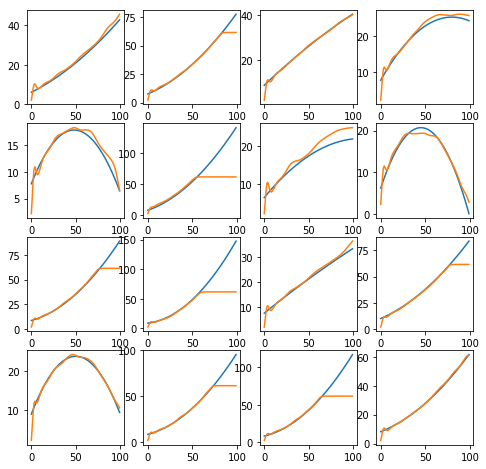

In [107]:
auto_test.save('auto_test')
y1_results6 = auto_test.predict(np.atleast_3d(y1))
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
axs.reshape(-1)
for i in range (0,4):
    for j in range(0,4):
        k = np.random.randint(0, y1_results6.shape[0])
        ax = axs[i,j]
        ax.plot(y2[k])
        ax.plot(y1_results6[k])

In [30]:
x_n = np.random.uniform(0,1)
x_n

0.18650193549428062

In [34]:
np.atleast_3d(y_n1)

array([[[2.51840697]],

       [[8.30664057]],

       [[4.37181466]],

       ...,

       [[8.96849751]],

       [[7.70796708]],

       [[6.97894193]]])

In [37]:
auto_test = rnn_auto(LSTM, 64, 1, 1, 10, 1)
auto_test.fit(np.atleast_3d(y_n1), np.atleast_3d(y_n2), epochs=2500, batch_size=2000)

Epoch 1/2500
1000000/1000000 [==============================] - 21s 21us/step - loss: 111.8810
Epoch 2/2500
1000000/1000000 [==============================] - 19s 19us/step - loss: 84.6019
Epoch 3/2500
1000000/1000000 [==============================] - 19s 19us/step - loss: 33.8545
Epoch 4/2500
1000000/1000000 [==============================] - 19s 19us/step - loss: 9.3755
Epoch 5/2500
1000000/1000000 [==============================] - 19s 19us/step - loss: 5.6370
Epoch 6/2500
1000000/1000000 [==============================] - 19s 19us/step - loss: 5.2993
Epoch 7/2500
 282000/1000000 [=======>......................] - ETA: 14s - loss: 5.1871

KeyboardInterrupt: 

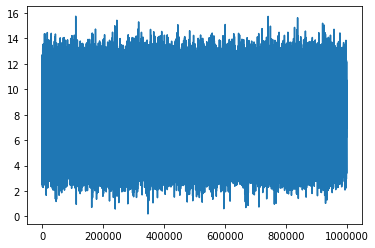

In [38]:
plt.plot(y_n1)

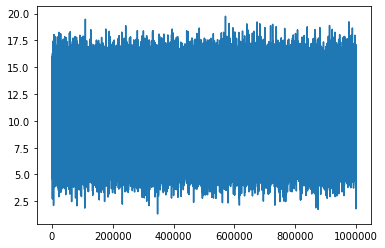

In [39]:
plt.plot(y_n2)